# Making stacked histograms
- processes an `events[year][ch][sample]` object using `make_events_dict()`
- uses `plot_hists()` to make stacked histograms

In [320]:
import glob
import os
import json
import pickle
import yaml
import math

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [321]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [322]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'had': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [323]:
def get_lumi(years, channels):
    lum_ = 0
    for year in years:
        lum = 0
        for ch in channels:
            lum += luminosity[ch][year] / 1000.0

        lum_ += lum / len(channels)    
    return lum_

In [331]:
 # define your regions here
presel = {
        "mu": {
            "lepmiso": "(lep_pt<55) | ( (lep_pt>=55) & (lep_misolation<0.8))",   # needed for the fakes            

#             "jetvetomap": "jetvetomap==1",
#             "msoftdrop": "fj_mass>30",
            "msoftdrop": "fj_mass>40",
            "THWW": "THWW>0.75",
            
#             "tagger>0.50": "THWW<0.5",
#             "FakeValidation": "fj_mass>30 & fj_mass<40",
#             "msoftdrop": "fj_mass<40",
#             "met": "met_pt>20",

#             "bveto": "n_bjets_T>0",
        },
        "ele": {

#             "jetvetomap": "jetvetomap==1",            
#             "msoftdrop": "fj_mass>30",
            "msoftdrop": "fj_mass>40",
            "THWW": "THWW>0.75",

#             "tagger>0.50": "THWW<0.5",
#             "FakeValidation": "fj_mass>30 & fj_mass<40",
#             "met": "met_pt>20",
#             "lepmiso": "(lep_pt<120) | ( (lep_pt>120) & (lep_misolation<0.02))",
#             "bveto": "n_bjets_T>0",
        },
}

channels = [
    "ele",
    "mu",
]
samples = [
    "ggF", 
    "VBF",  
    "WH",
    "ZH",
    "ttH",
    "QCD",
    "WJetsLNu",
    "TTbar",
    "SingleTop",
    "Diboson",
    "EWKvjets",
    "DYJets",
    "WZQQ",

    "Data",
    "Fake",
]

years = [
    "2016",
    "2016APV",
    "2017",
    "2018",
]

### 2017 is good
### 2018 ele is good, 2018 mu doesnt exist
### 2016 ele is good, mu a bit weird but not awful
### 2016APV is good

In [332]:
events_dict = {}

In [333]:
samples_dir = {
    # new jobs
#     "2016":    "../eos/May31_hww_2016",
#     "2016APV": "../eos/May31_hww_2016APV",
#     "2017":    "../eos/May31_hww_2017",
#     "2018":    "../eos/May31_hww_2018",

    # new jobs
#     "2016":    "../eos/June25_hww_2016",
#     "2016APV": "../eos/June25_hww_2016APV",
#     "2017":    "../eos/June25_hww_2017",
#     "2018":    "../eos/June25_hww_2018",

#     "2017":    "../eos/July1_eleisoSF_2017/",
    
#     "2017":    "../eos/July9_triggerSF_2017/",


#     "2016":    "../eos/July18_hww_2016",
#     "2016APV": "../eos/July18_hww_2016APV",
#     "2017":    "../eos/July18_hww_2017",
#     "2018":    "../eos/July18_hww_2018",

    "2016":    "../eos/Oct10_hww_2016",
    "2016APV": "../eos/Oct10_hww_2016APV",
    "2017":    "../eos/Oct10_hww_2017",
    "2018":    "../eos/Oct10_hww_2018",

#     "2018":    "../eos/Aug19_hww_2018",
}

THWW_path = "../../weaver-core-dev/experiments_finetuning/v35_30/model.onnx"

from make_stacked_hists import make_events_dict

events_dict = make_events_dict(years, channels, samples_dir, samples, presel, THWW_path, fake_SF={"ele": 0.75, "mu": 1})

INFO:root:Finding VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil samples and should combine them under VBF
INFO:root:Applying msoftdrop selection on 798 events
INFO:root:Applying THWW selection on 689 events
INFO:root:Will fill the VBF dataframe with the remaining 253 events
INFO:root:tot event weight 2.2697910741257665 

INFO:root:Finding fake_2016_ele_EWK_SF_Down.parquet samples and should combine them under EWKvjets
INFO:root:No parquet file for fake_2016_ele_EWK_SF_Down.parquet
INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:Applying msoftdrop selection on 19 events
INFO:root:Applying THWW selection on 12 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 0 events
INFO:root:tot event weight 0.0 

INFO:root:Finding SingleMuon_Run2016H samples and should combine them under Data
INFO:root:Finding SingleMuon_Run2016F samples and should combine them under Data
INFO:root:Finding EWKWminus_WToLNu samples and should combine 

INFO:root:Applying THWW selection on 4616 events
INFO:root:Will fill the SingleTop dataframe with the remaining 20 events
INFO:root:tot event weight 0.08818600841034617 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-50To100 samples and should combine them under DYJets
INFO:root:Applying msoftdrop selection on 1585 events
INFO:root:Applying THWW selection on 1539 events
INFO:root:Will fill the DYJets dataframe with the remaining 26 events
INFO:root:tot event weight 1.8132959916919125 

INFO:root:Finding QCD_Pt_1800to2400 samples and should combine them under QCD
INFO:root:Applying msoftdrop selection on 408 events
INFO:root:Applying THWW selection on 350 events
INFO:root:Will fill the QCD dataframe with the remaining 1 events
INFO:root:tot event weight 0.0003166747259336538 

INFO:root:Finding fake_2016_mu_EWK_SF_Down.parquet samples and should combine them under EWKvjets
INFO:root:No parquet file for fake_2016_mu_EWK_SF_Down.parquet
INFO:root:Finding WW samples and should combine them und

INFO:root:Finding WJetsToQQ_HT-400to600 samples and should combine them under WZQQ
INFO:root:Applying msoftdrop selection on 35 events
INFO:root:Applying THWW selection on 28 events
INFO:root:Will fill the WZQQ dataframe with the remaining 1 events
INFO:root:tot event weight 1.508073155159401 

INFO:root:Finding WJetsToLNu_HT-400To600 samples and should combine them under WJetsLNu
INFO:root:Applying msoftdrop selection on 11918 events
INFO:root:Applying THWW selection on 10463 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 251 events
INFO:root:tot event weight 133.9090358083963 

INFO:root:Finding QCD_Pt_470to600 samples and should combine them under QCD
INFO:root:Applying msoftdrop selection on 2057 events
INFO:root:Applying THWW selection on 1787 events
INFO:root:Will fill the QCD dataframe with the remaining 12 events
INFO:root:tot event weight 1.8715461699585343 

INFO:root:Finding HZJ_HToWW_M-125 samples and should combine them under ZH
INFO:root:Applying mso

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-650ToInf samples and should combine them under DYJets
INFO:root:Applying lepmiso selection on 58406 events
INFO:root:Applying msoftdrop selection on 58406 events
INFO:root:Applying THWW selection on 44943 events
INFO:root:Will fill the DYJets dataframe with the remaining 442 events
INFO:root:tot event weight 0.15955145071807525 

INFO:root:Finding SingleElectron_Run2016F samples and should combine them under Data
INFO:root:Finding WJetsToQQ_HT-200to400 samples and should combine them under WZQQ
INFO:root:Finding ST_tW_antitop_5f_inclusiveDecays samples and should combine them under SingleTop
INFO:root:Applying lepmiso selection on 1976 events
INFO:root:Applying msoftdrop selection on 1976 events
INFO:root:Applying THWW selection on 1720 events
INFO:root:Will fill the SingleTop dataframe with the remaining 39 events
INFO:root:tot event weight 7.20566286925947 

INFO:root:Finding ZJetsToQQ_HT-200to400 samples and should combine them under WZQQ
IN

INFO:root:Applying THWW selection on 481 events
INFO:root:Will fill the WZQQ dataframe with the remaining 8 events
INFO:root:tot event weight 0.7425658463084365 

INFO:root:Finding ZJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:Applying lepmiso selection on 543 events
INFO:root:Applying msoftdrop selection on 543 events
INFO:root:Applying THWW selection on 478 events
INFO:root:Will fill the WZQQ dataframe with the remaining 6 events
INFO:root:tot event weight 0.5825421728617252 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-400To650 samples and should combine them under DYJets
INFO:root:Applying lepmiso selection on 24094 events
INFO:root:Applying msoftdrop selection on 24094 events
INFO:root:Applying THWW selection on 17629 events
INFO:root:Will fill the DYJets dataframe with the remaining 192 events
INFO:root:tot event weight 0.6238426296323065 

INFO:root:Finding EWKWminus_WToQQ samples and should combine them under EWKvjets
INFO:root:Applying lepmiso select

INFO:root:Applying msoftdrop selection on 330497 events
INFO:root:Applying THWW selection on 315009 events
INFO:root:Will fill the TTbar dataframe with the remaining 3306 events
INFO:root:tot event weight 165.62688190042803 

INFO:root:Finding ST_t-channel_top_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:Applying msoftdrop selection on 9217 events
INFO:root:Applying THWW selection on 8920 events
INFO:root:Will fill the SingleTop dataframe with the remaining 34 events
INFO:root:tot event weight 1.0210902329832108 

INFO:root:Finding ST_s-channel_4f_hadronicDecays samples and should combine them under SingleTop
INFO:root:Finding fake_2016APV_ele_EWK_SF_Down.parquet samples and should combine them under EWKvjets
INFO:root:No parquet file for fake_2016APV_ele_EWK_SF_Down.parquet
INFO:root:Finding WJetsToLNu_HT-1200To2500 samples and should combine them under WJetsLNu
INFO:root:Applying msoftdrop selection on 57860 events
INFO:root:Applying THWW selection on 

INFO:root:Will fill the EWKvjets dataframe with the remaining 1 events
INFO:root:tot event weight 0.03166225543463802 

INFO:root:Finding ZJetsToQQ_HT-400to600 samples and should combine them under WZQQ
INFO:root:Applying msoftdrop selection on 48 events
INFO:root:Applying THWW selection on 29 events
INFO:root:Will fill the WZQQ dataframe with the remaining 0 events
INFO:root:tot event weight 0.0 

INFO:root:Finding ZZ samples and should combine them under Diboson
INFO:root:Applying msoftdrop selection on 119 events
INFO:root:Applying THWW selection on 104 events
INFO:root:Will fill the Diboson dataframe with the remaining 2 events
INFO:root:tot event weight 0.5599891295457438 

INFO:root:Finding fake_2016APV_mu_EWK_SF_Down.parquet samples and should combine them under EWKvjets
INFO:root:No parquet file for fake_2016APV_mu_EWK_SF_Down.parquet
INFO:root:Finding TTToHadronic samples and should combine them under TTbar
INFO:root:Applying msoftdrop selection on 818 events
INFO:root:Applyin

INFO:root:tot event weight 1.2074451843653211 

INFO:root:Finding QCD_Pt_1400to1800 samples and should combine them under QCD
INFO:root:Applying msoftdrop selection on 700 events
INFO:root:Applying THWW selection on 616 events
INFO:root:Will fill the QCD dataframe with the remaining 2 events
INFO:root:tot event weight 0.002331832986897758 

INFO:root:Finding fake_2016APV_mu_EWK_SF_Up.parquet samples and should combine them under EWKvjets
INFO:root:No parquet file for fake_2016APV_mu_EWK_SF_Up.parquet
INFO:root:Finding SingleElectron_Run2016B_ver2_HIPM samples and should combine them under Data
INFO:root:Applying msoftdrop selection on 13459 events
INFO:root:Applying THWW selection on 11828 events
INFO:root:Will fill the Data dataframe with the remaining 240 events
INFO:root:tot event weight 240.0 

INFO:root:Processing the fake background
INFO:root:Finding VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil samples and should combine them under VBF
INFO:root:Applying lepmiso selection on 860 

INFO:root:Applying lepmiso selection on 19041 events
INFO:root:Applying msoftdrop selection on 19041 events
INFO:root:Applying THWW selection on 15329 events
INFO:root:Will fill the DYJets dataframe with the remaining 222 events
INFO:root:tot event weight 8.372638793052507 

INFO:root:Finding fake_2016APV_ele_EWK_SF_Up.parquet samples and should combine them under EWKvjets
INFO:root:No parquet file for fake_2016APV_ele_EWK_SF_Up.parquet
INFO:root:Finding EWKWplus_WToQQ samples and should combine them under EWKvjets
INFO:root:Applying lepmiso selection on 100 events
INFO:root:Applying msoftdrop selection on 100 events
INFO:root:Applying THWW selection on 71 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 1 events
INFO:root:tot event weight 0.11064705182055819 

INFO:root:Finding ST_s-channel_4f_leptonDecays samples and should combine them under SingleTop
INFO:root:Applying lepmiso selection on 7282 events
INFO:root:Applying msoftdrop selection on 7282 events
INFO:ro

INFO:root:tot event weight 254.0 

INFO:root:Finding SingleMuon_Run2016E_HIPM samples and should combine them under Data
INFO:root:Applying lepmiso selection on 10634 events
INFO:root:Applying msoftdrop selection on 10634 events
INFO:root:Applying THWW selection on 8817 events
INFO:root:Will fill the Data dataframe with the remaining 176 events
INFO:root:tot event weight 176.0 

INFO:root:Finding EWKWminus_WToQQ samples and should combine them under EWKvjets
INFO:root:Applying lepmiso selection on 61 events
INFO:root:Applying msoftdrop selection on 61 events
INFO:root:Applying THWW selection on 47 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 0 events
INFO:root:tot event weight 0.0 

INFO:root:Finding QCD_Pt_170to300 samples and should combine them under QCD
INFO:root:Applying lepmiso selection on 114 events
INFO:root:Applying msoftdrop selection on 114 events
INFO:root:Applying THWW selection on 78 events
INFO:root:Will fill the QCD dataframe with the remaining 

INFO:root:Will fill the WH dataframe with the remaining 1100 events
INFO:root:tot event weight 0.7586488548185879 

INFO:root:Finding WJetsToLNu_HT-800To1200 samples and should combine them under WJetsLNu
INFO:root:Applying msoftdrop selection on 111347 events
INFO:root:Applying THWW selection on 105311 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 2563 events
INFO:root:tot event weight 139.84976388433796 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:Applying msoftdrop selection on 354475 events
INFO:root:Applying THWW selection on 336728 events
INFO:root:Will fill the TTbar dataframe with the remaining 3549 events
INFO:root:tot event weight 389.6343335830418 

INFO:root:Finding ST_t-channel_top_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:Applying msoftdrop selection on 23439 events
INFO:root:Applying THWW selection on 22552 events
INFO:root:Will fill the SingleTop dataframe with the re

INFO:root:Will fill the DYJets dataframe with the remaining 1476 events
INFO:root:tot event weight 8.269087912093763 

INFO:root:Finding ST_t-channel_antitop_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:Applying msoftdrop selection on 9525 events
INFO:root:Applying THWW selection on 9152 events
INFO:root:Will fill the SingleTop dataframe with the remaining 41 events
INFO:root:tot event weight 1.459734194242727 

INFO:root:Finding TTTo2L2Nu samples and should combine them under TTbar
INFO:root:Applying msoftdrop selection on 135201 events
INFO:root:Applying THWW selection on 128150 events
INFO:root:Will fill the TTbar dataframe with the remaining 741 events
INFO:root:tot event weight 23.72907509051472 

INFO:root:Finding QCD_Pt_2400to3200 samples and should combine them under QCD
INFO:root:Applying msoftdrop selection on 243 events
INFO:root:Applying THWW selection on 204 events
INFO:root:Will fill the QCD dataframe with the remaining 0 events
INFO:root:t

INFO:root:tot event weight 5.451157772251433 

INFO:root:Finding HZJ_HToWW_M-125 samples and should combine them under ZH
INFO:root:Applying msoftdrop selection on 9371 events
INFO:root:Applying THWW selection on 8252 events
INFO:root:Will fill the ZH dataframe with the remaining 2506 events
INFO:root:tot event weight 1.4859988168942835 

INFO:root:Finding WZ samples and should combine them under Diboson
INFO:root:Applying msoftdrop selection on 596 events
INFO:root:Applying THWW selection on 493 events
INFO:root:Will fill the Diboson dataframe with the remaining 12 events
INFO:root:tot event weight 3.4519031976603913 

INFO:root:Finding QCD_Pt_1400to1800 samples and should combine them under QCD
INFO:root:Applying msoftdrop selection on 690 events
INFO:root:Applying THWW selection on 591 events
INFO:root:Will fill the QCD dataframe with the remaining 0 events
INFO:root:tot event weight 0.0 

INFO:root:Finding SingleMuon_Run2017F samples and should combine them under Data
INFO:root:Pro

INFO:root:tot event weight 2.1397339141815443 

INFO:root:Finding SingleElectron_Run2017C samples and should combine them under Data
INFO:root:Finding DYJetsToLL_LHEFilterPtZ-100To250 samples and should combine them under DYJets
INFO:root:Applying lepmiso selection on 41997 events
INFO:root:Applying msoftdrop selection on 41997 events
INFO:root:Applying THWW selection on 31931 events
INFO:root:Will fill the DYJets dataframe with the remaining 470 events
INFO:root:tot event weight 27.27117555080312 

INFO:root:Finding SingleElectron_Run2017D samples and should combine them under Data
INFO:root:Finding EWKWplus_WToQQ samples and should combine them under EWKvjets
INFO:root:Applying lepmiso selection on 251 events
INFO:root:Applying msoftdrop selection on 251 events
INFO:root:Applying THWW selection on 170 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 6 events
INFO:root:tot event weight 0.4329601208126659 

INFO:root:Finding SingleMuon_Run2017C samples and should co

INFO:root:Finding ZJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:Applying lepmiso selection on 1041 events
INFO:root:Applying msoftdrop selection on 1041 events
INFO:root:Applying THWW selection on 890 events
INFO:root:Will fill the WZQQ dataframe with the remaining 9 events
INFO:root:tot event weight 1.1396794367292442 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-400To650 samples and should combine them under DYJets
INFO:root:Applying lepmiso selection on 43875 events
INFO:root:Applying msoftdrop selection on 43875 events
INFO:root:Applying THWW selection on 31991 events
INFO:root:Will fill the DYJets dataframe with the remaining 289 events
INFO:root:tot event weight 1.4334258984989596 

INFO:root:Finding EWKWminus_WToQQ samples and should combine them under EWKvjets
INFO:root:Applying lepmiso selection on 112 events
INFO:root:Applying msoftdrop selection on 112 events
INFO:root:Applying THWW selection on 67 events
INFO:root:Will fill the EWKvjets dataframe 

INFO:root:tot event weight 1.092035235106046 

INFO:root:Finding WJetsToLNu_HT-800To1200 samples and should combine them under WJetsLNu
INFO:root:Applying msoftdrop selection on 161245 events
INFO:root:Applying THWW selection on 152845 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 3599 events
INFO:root:tot event weight 204.26915057639533 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:Applying msoftdrop selection on 356603 events
INFO:root:Applying THWW selection on 339347 events
INFO:root:Will fill the TTbar dataframe with the remaining 3624 events
INFO:root:tot event weight 575.336838821689 

INFO:root:Finding ST_t-channel_top_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:Applying msoftdrop selection on 31662 events
INFO:root:Applying THWW selection on 30560 events
INFO:root:Will fill the SingleTop dataframe with the remaining 138 events
INFO:root:tot event weight 3.9723815801571787 

INF

INFO:root:Applying THWW selection on 1 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 0 events
INFO:root:tot event weight 0.0 

INFO:root:Finding ZJetsToQQ_HT-400to600 samples and should combine them under WZQQ
INFO:root:Applying msoftdrop selection on 58 events
INFO:root:Applying THWW selection on 41 events
INFO:root:Will fill the WZQQ dataframe with the remaining 2 events
INFO:root:tot event weight 1.7253508906655077 

INFO:root:Finding ZZ samples and should combine them under Diboson
INFO:root:Applying msoftdrop selection on 312 events
INFO:root:Applying THWW selection on 272 events
INFO:root:Will fill the Diboson dataframe with the remaining 3 events
INFO:root:tot event weight 0.8134075593733278 

INFO:root:Finding TTToHadronic samples and should combine them under TTbar
INFO:root:Applying msoftdrop selection on 652 events
INFO:root:Applying THWW selection on 594 events
INFO:root:Will fill the TTbar dataframe with the remaining 10 events
INFO:root:tot event we

INFO:root:Finding WZ samples and should combine them under Diboson
INFO:root:Applying msoftdrop selection on 704 events
INFO:root:Applying THWW selection on 579 events
INFO:root:Will fill the Diboson dataframe with the remaining 15 events
INFO:root:tot event weight 5.385684058316903 

INFO:root:Finding QCD_Pt_1400to1800 samples and should combine them under QCD
INFO:root:Applying msoftdrop selection on 706 events
INFO:root:Applying THWW selection on 603 events
INFO:root:Will fill the QCD dataframe with the remaining 1 events
INFO:root:tot event weight 0.0035206709326463036 

INFO:root:Finding SingleMuon_Run2018B samples and should combine them under Data
INFO:root:Processing the fake background
INFO:root:Finding VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil samples and should combine them under VBF
INFO:root:Applying lepmiso selection on 2473 events
INFO:root:Applying msoftdrop selection on 2473 events
INFO:root:Applying THWW selection on 1999 events
INFO:root:Will fill the VBF datafram

INFO:root:Applying THWW selection on 33619 events
INFO:root:Will fill the DYJets dataframe with the remaining 505 events
INFO:root:tot event weight 36.5552094682688 

INFO:root:Finding EGamma_Run2018A samples and should combine them under Data
INFO:root:Finding fake_2018_mu_EWK_SF_Down.parquet samples and should combine them under EWKvjets
INFO:root:No parquet file for fake_2018_mu_EWK_SF_Down.parquet
INFO:root:Finding EWKWplus_WToQQ samples and should combine them under EWKvjets
INFO:root:Applying lepmiso selection on 213 events
INFO:root:Applying msoftdrop selection on 213 events
INFO:root:Applying THWW selection on 140 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 5 events
INFO:root:tot event weight 0.6884514988738484 

INFO:root:Finding ST_s-channel_4f_leptonDecays samples and should combine them under SingleTop
INFO:root:Applying lepmiso selection on 25487 events
INFO:root:Applying msoftdrop selection on 25487 events
INFO:root:Applying THWW selection on 2432

INFO:root:tot event weight 0.0 

INFO:root:Finding WJetsToLNu_HT-600To800 samples and should combine them under WJetsLNu
INFO:root:Applying lepmiso selection on 145423 events
INFO:root:Applying msoftdrop selection on 145423 events
INFO:root:Applying THWW selection on 131778 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 4044 events
INFO:root:tot event weight 537.1245483529151 

INFO:root:Finding WJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:Applying lepmiso selection on 437 events
INFO:root:Applying msoftdrop selection on 437 events
INFO:root:Applying THWW selection on 349 events
INFO:root:Will fill the WZQQ dataframe with the remaining 9 events
INFO:root:tot event weight 3.3344921311995686 

INFO:root:Finding WJetsToLNu_HT-2500ToInf samples and should combine them under WJetsLNu
INFO:root:Applying lepmiso selection on 89377 events
INFO:root:Applying msoftdrop selection on 89377 events
INFO:root:Applying THWW selection on 68937 events


In [327]:
# # for LP
# for year in ["2018"]:
#     out = make_events_dict([year], channels, f"../eos/June1_LPvalidation_{year}", ["TTbar"], presel)
#     for ch in channels:
#         events_dict[year][ch]["TTbar_LP"] = out[year][ch]["TTbar"]

In [190]:
events_dict["2018"]["ele"]["ggF"]["nominal"].sum()

16.79802232879573

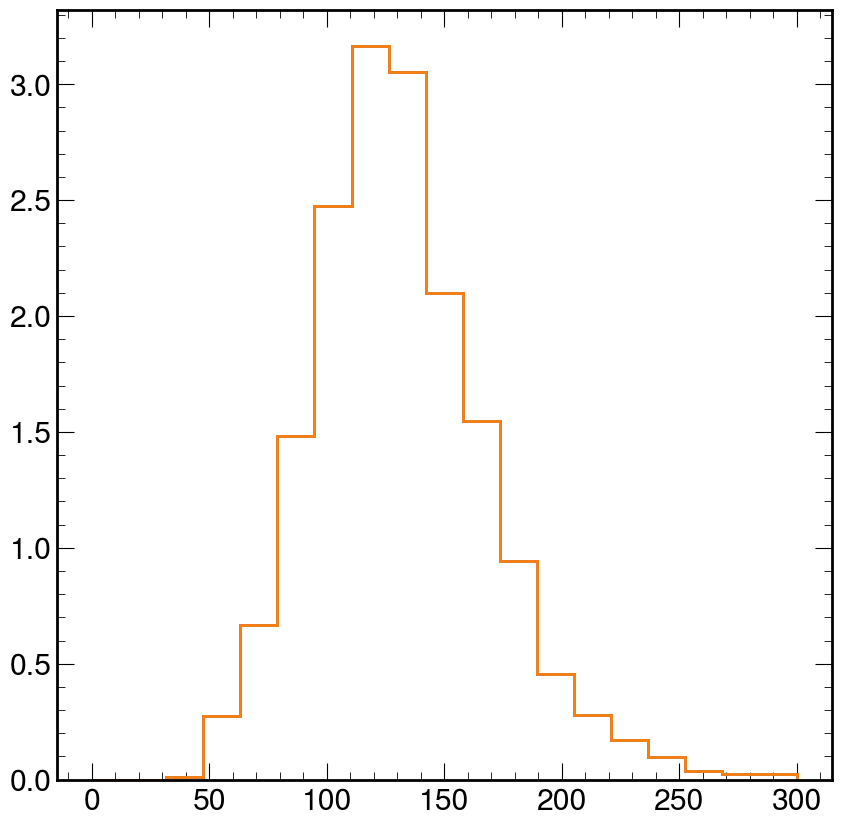

In [152]:
df = events_dict["2018"]["ele"]["ggF"]
plt.hist(
    df["rec_higgs_m"],
    weights=df["nominal"],
    bins=np.linspace(0,300,20),
    histtype="step",
    lw=2,
);
plt.hist(
    df["rec_higgs_m"],
    weights=df["nominal"] * df["EW_weight"],
    bins=np.linspace(0,300,20),
    histtype="step",
    lw=2,
);

In [120]:
def get_soverb(ev, presel, categories_sel, years, channels, precision=0, usefake=False):

    mass_window = [50, 150]

    num_sig = {
        "ggF": 0,
        "VBF": 0,
        "WH": 0,
        "ZH": 0,
        "ttH": 0,
    }
    
    samples = [
        "ggF", 
        "VBF",
        "ttH",
        "WH",
        "ZH",
        "WJetsLNu",
        "TTbar",
        "SingleTop",
        "Diboson",
        "EWKvjets",
        "WZQQ",
        "DYJets",        
        "Data",
    ]

    
    if usefake:
        samples += ["Fake"]
        
        dominant_backgrounds = ["WJetsLNu", "TTbar", "Fake", "DYJets"]        
        
        num_bkg = {
            "WJetsLNu": 0, 
            "TTbar": 0, 
            "Fake": 0,
            "DYJets": 0,
            "Others": 0,
        }
    else:
        samples += ["QCD"]        
        
        dominant_backgrounds = ["WJetsLNu", "TTbar", "QCD", "DYJets"]
        
        num_bkg = {
            "WJetsLNu": 0, 
            "TTbar": 0, 
            "QCD": 0,
            "DYJets": 0,
            "Others": 0,
        }

    deno_sig, deno_bkg = 0, 0
    s, b = 0, 0

    for year in years:
        for ch in channels:
            for sample in samples:
                if sample=="Data":
                    continue

                df = ev[year][ch][sample]

                for region, sel in presel.items():
                    df = df.query(sel)

                for category, category_sel in categories_sel.items():
                    df = df.query(category_sel)
                    
                ######################## composition start
                if sample in utils.signals:
                    deno_sig += df["nominal"].sum()
                    num_sig[sample] += df["nominal"].sum()
                else:
                    deno_bkg += df["nominal"].sum()

                    if sample in dominant_backgrounds:
                        num_bkg[sample] += df["nominal"].sum()
                    else:
                        num_bkg["Others"] += df["nominal"].sum()     
                ######################## composition end

                ######################## soverb start
                df = df[(df["rec_higgs_m"]>=mass_window[0]) & (df["rec_higgs_m"]<=mass_window[1])]

                if sample in utils.signals:                
                    s += df["nominal"].sum()
                else:
                    b += df["nominal"].sum()
                ######################## soverb end

    num_sig = dict(sorted(num_sig.items(), key=lambda item: item[1], reverse=True))
    num_bkg = dict(sorted(num_bkg.items(), key=lambda item: item[1], reverse=True))

    if len(years) == 4:
        lab = "RUN2"
    else:
        lab = "_".join(years)

    print("\033[1m" + f"{list(presel.keys())[0]} ({lab}):" + '\033[0m')
    if len(list(categories_sel.items()))!=0:
        print("Category:", list(categories_sel.keys())[0])

    print("------------------------")

    if "SR" in list(presel.keys())[0]:
        print("\033[1m" + rf"s/sqrt(b) in [{mass_window[0]},{mass_window[1]}]: {s/math.sqrt(b):.2f}" + '\033[0m')
        print("------------------------")

    print(f"Signal: {deno_sig:.2f}")
    for sample in num_sig:
        print(f"- {sample}: {100*(num_sig[sample]/deno_sig):.0f}%")

    print("------------------------")
    print(f"Background: {deno_bkg:.2f}")
    for sample in num_bkg:
        if sample=="":
            if precision == 0:
                print("\033[1m" + f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%")
            elif precision == 1:
                print("\033[1m" + f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.1f}%")                
            elif precision == 2:
                print("\033[1m" + f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.2f}%")
        else:
            if precision == 0:
                print(f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%")
            elif precision == 1:
                print(f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.1f}%")
            elif precision == 2:
                print(f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.2f}%")

In [125]:
presel = {
#     "SR w/o msk_leptonic_taus": "(THWW>0.92) & (n_bjets_T==0)",
    "SR w msk_leptonic_taus": "(THWW>0.905) & (n_bjets_T==0)",

#     "Pre-selection with nloose==ntight": "(THWW>0.75)",
#     "Pre-selection": "(THWW>0.75)",
    
#     "VBF category": f"( (THWW>0.905) & (n_bjets_T==0) ) & ( (mjj>1000) & (deta>3.5) )",
#     "ggF category": f"( (THWW>0.905) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) )",
    
}
categories_sel = {}
get_soverb(events_dict, presel, categories_sel, years, channels, usefake=True)

SR w msk_leptonic_taus (RUN2):
------------------------
s/sqrt(b) in [50,150]: 2.18
------------------------
Signal: 79.35
- ggF: 55%
- VBF: 28%
- WH: 9%
- ZH: 5%
- ttH: 2%
------------------------
Background: 1537.30
- WJetsLNu: 61%
- TTbar: 22%
- Others: 13%
- DYJets: 3%
- Fake: 1%


(2.08, 2.13, 2.13)

INFO:matplotlib.mathtext:Substituting symbol \equiv from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \equiv from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \equiv from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \equiv from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \equiv from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \equiv from STIXGeneral


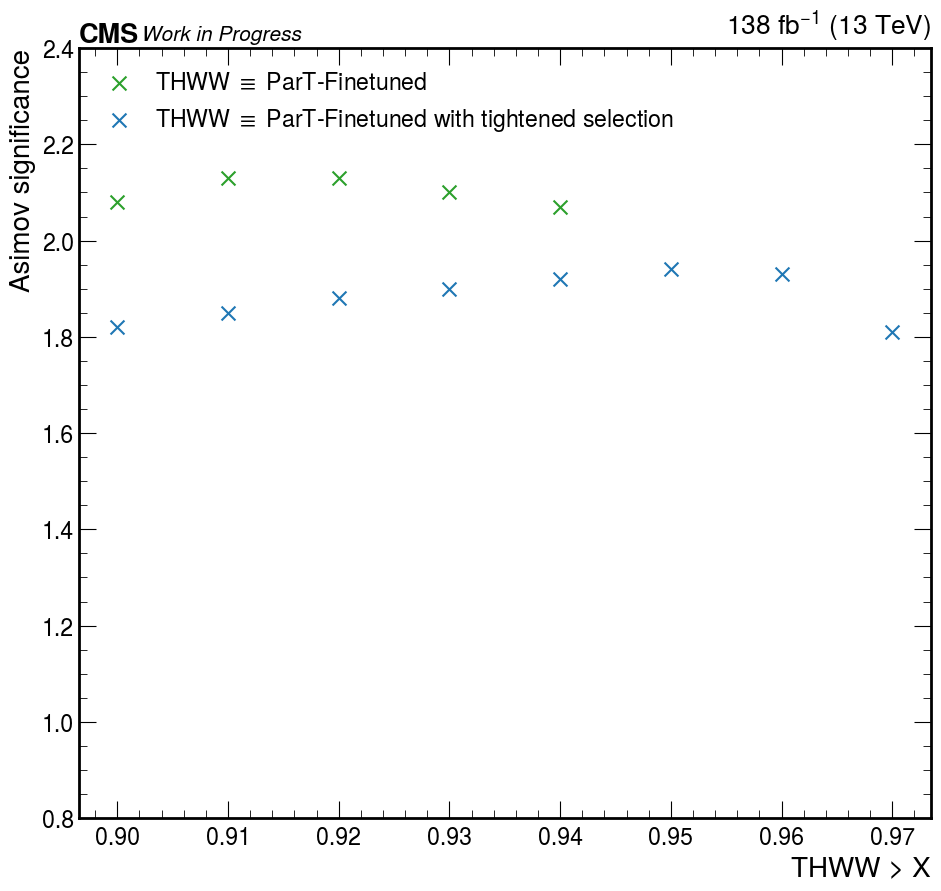

In [93]:
plt.rcParams.update({"font.size": 20})

THWW_cuts = [0.90, 0.91, 0.92, 0.93, 0.94]
THWW_cuts_tighten = [0.90, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97]

sig = [2.08, 2.13, 2.13, 2.10, 2.07]
sig_tighten = [1.82, 1.85, 1.88, 1.90, 1.92, 1.94, 1.93, 1.81]

years = ["2018", "2017", "2016APV", "2016"]
channels = ["ele", "mu"]

fig, ax = plt.subplots(figsize=(11, 10))

ax.scatter(THWW_cuts, sig, marker="x", s=100, label=r"THWW $\equiv$ ParT-Finetuned", color="tab:green")
ax.scatter(THWW_cuts_tighten, sig_tighten, marker="x", s=100, label=r"THWW $\equiv$ ParT-Finetuned with tightened selection", color="tab:blue")

ax.legend(loc="upper left")
ax.set_ylabel("Asimov significance")
ax.set_xlabel("THWW > X")

# x1 = 0.897
# x2 = 0.932
y1 = 0.8
y2 = 2.4

# ax.set_xlim(x1, x2)
ax.set_ylim(y1, y2)

hep.cms.lumitext("%.0f " % get_lumi(years, channels) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/significance/finetuned_tighten_selection.pdf")

In [61]:
def make_composition_table(ev, presel, add_soverb=False, use_Fake=False):

    from collections import OrderedDict
    
    all_MCsamples = [
        "ggF", 
        "VBF",
        "ttH",
        "WH",
        "ZH",        
        "WJetsLNu",
        "TTbar",
        "SingleTop",
        "Diboson",
        "EWKvjets",
        "DYJets",
        "WZQQ",
    ]
    if use_Fake:    
        all_MCsamples += ["Fake"]
        bkg = ["TTbar", "WJetsLNu", "Fake", "Others"]        
    else:
        all_MCsamples += ["QCD"]
        bkg = ["TTbar", "WJetsLNu", "QCD", "Others"]        
    
    sig = ["VBF", "ggF", "WH", "ZH", "ttH"]

    mass_window = [50, 150]
    
    # make table
    print("\\begin{table}[!ht]")
    print("\\begin{center}")
    
    if add_soverb:
        print("\\caption{Event yield contribution from different processes in the search regions for the full Run2 dataset. The last column includes $s/\sqrt{b}$ in a mass window of 100-150\GeV in the mass observable (the Higgs reconstructed mass).}")
    else:
        print("\\caption{Event yield contribution from different processes in the search regions for the full Run2 dataset.}")
        
    if add_soverb:
        print("\\begin{tabular}{c|ccccc|cccc|c}")
    else:
        print("\\begin{tabular}{c|ccccc|cccc}")

    if add_soverb:    
        print("& \\multicolumn{5}{c|}{Signal yield} & \\multicolumn{4}{c|}{Background yield} & \\multicolumn{1}{c}{$s/\sqrt{b}$} \\\\\n")
        if use_Fake:
            print("& VBF & ggF & WH & ZH & \\ttH & \\ttbar & W$+$jets & Fake & Other & \\\\\n")
        else:
            print("& VBF & ggF & WH & ZH & \\ttH & \\ttbar & W$+$jets & QCD & Other & \\\\\n")
    else:
        print("& \\multicolumn{5}{c|}{Signal yield} & \\multicolumn{4}{c}{Background yield} \\\\\n")
        if use_Fake:        
            print("& VBF & ggF & WH & ZH & \\ttH & \\ttbar & W$+$jets & Fake & Other \\\\\n")
        else:
            print("& VBF & ggF & WH & ZH & \\ttH & \\ttbar & W$+$jets & QCD & Other \\\\\n")
            
    print("\\hline")
    print("\\hline")

    years_to_cover = years
    for region, sel in presel.items():
        if "2018" in region:
            years_to_cover = ["2018"]
        elif "2017" in region:
            years_to_cover = ["2017"]
        elif "2017" in region:
            years_to_cover = ["2017"]
        elif "2016APV" in region:
            years_to_cover = ["2016APV"]
        elif "2016" in region:
            years_to_cover = ["2016"]
        else:
            years_to_cover = years
        
        sig_dict = OrderedDict({
            "VBF": 0,
            "ggF": 0,
            "WH": 0,
            "ZH": 0,
            "ttH": 0,            
        })

        if use_Fake:            
            bkg_dict = OrderedDict({
                "TTbar": 0,
                "WJetsLNu": 0, 
                "Fake": 0,
                "Others": 0,    
            })
        else:
            bkg_dict = OrderedDict({
                "TTbar": 0,
                "WJetsLNu": 0, 
                "QCD": 0,
                "Others": 0,    
            })            

        tot_sig, tot_bkg = 0, 0
        s, b = 0, 0   # in mass window [100, 150]
        for year in years_to_cover:
            for ch in channels:
                for sample in all_MCsamples:
                    
                    df = ev[year][ch][sample]
                    
                    if (ch == "mu") and (sample=="Fake"):
                        continue

                    df = df.query(sel)  

                    if sample in sig_dict:
                        tot_sig += df["nominal"].sum()                    
                        sig_dict[sample] += df["nominal"].sum()
                    elif sample in bkg_dict:
                        tot_bkg += df["nominal"].sum()
                        bkg_dict[sample] += df["nominal"].sum()
                    else:
                        tot_bkg += df["nominal"].sum()                        
                        bkg_dict["Others"] += df["nominal"].sum()                    

                    ######################## soverb start
                    df = df[(df["rec_higgs_m"]>=mass_window[0]) & (df["rec_higgs_m"]<=mass_window[1])]

                    if sample in sig_dict:                
                        s += df["nominal"].sum()
                    else:
                        b += df["nominal"].sum()
                    ######################## soverb end

        texdata = "\multirow{2}{*}{" + region + "} & \multicolumn{5}{c|}{"
        texdata += str(round(tot_sig))
        
        if add_soverb:
            texdata += "} & \multicolumn{4}{c|}{"
            texdata += str(round(tot_bkg))
            texdata += "} & \multicolumn{1}{c}{"            
#             texdata += str(round(s/(b**0.5),3))
            texdata += "\multirow{2}{*}{" + str(round(s/(b**0.5),3)) + "}"
            
            texdata += "} \\\\\n"
        else:
            texdata += "} & \multicolumn{4}{c}{"
            texdata += str(round(tot_bkg))
            texdata += "} \\\\\n"
        
#         texdata += "\\cline{2-9} \n"
        
        for sample in sig_dict:
            texdata += f" & {(100*sig_dict[sample]/tot_sig):.0f}\%"
        for sample in bkg_dict:
            if bkg_dict[sample]<0:
                bkg_dict[sample]=0
            texdata += f" & {(100*bkg_dict[sample]/tot_bkg):.0f}\%"
        
        if add_soverb:
            texdata += " & "

        texdata += " \\\\\n"
        print(texdata)
        print("\\hline")

    print("\\hline")
    print("\\end{tabular}")
    print("\\label{tab:}")
    print("\\end{center}")
    print("\\end{table}")      

In [62]:
shift = 50
WP_VBF = 0.905
WP2 = 0.93

presel = {
#     "Pre-selection": f"THWW>0.5", # dummy
    
#     "Signal region": f"(THWW>0.92) & (n_bjets_T==0)",    
#     "Top control region": f"(THWW>0.75) & (n_bjets_T>0)",
#     "W+Jets control region": f"(THWW<0.905) & (THWW>0.75) & (n_bjets_T==0)",

#     "VBF category": f"( ({tagger}>{WP_VBF}) & (n_bjets_T==0) ) & ( (mjj>1000) & (deta>3.5) )",
    
#     r"ggF category $p_T \in $ " + f"[{200+shift}, {300+shift}]": f"( ({tagger}>{WP2}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (rec_higgs_pt<{300+shift}) )",
#     r"ggF category $p_T \in $ " + f"[{300+shift}, {450+shift}]": f"( ({tagger}>{WP2}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (rec_higgs_pt>{300+shift}) & (rec_higgs_pt<{450+shift}) )",
#     r"ggF category $p_T \in $ " + f"[{450+shift}, Inf]": f"( ({tagger}>{WP2}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (rec_higgs_pt>{450+shift}) )",      
    
#     "Top control region (RUN2)": f"(THWW>0.75) & (n_bjets_T>0)",
#     "Top control region (2018)": f"(THWW>0.75) & (n_bjets_T>0)",
#     "Top control region (2017)": f"(THWW>0.75) & (n_bjets_T>0)",
#     "Top control region (2016)": f"(THWW>0.75) & (n_bjets_T>0)",
#     "Top control region (2016APV)": f"(THWW>0.75) & (n_bjets_T>0)",
    
#     "W+Jets control region (RUN2)": f"(THWW<0.90) & (THWW>0.75) & (n_bjets_T==0)",
#     "W+Jets control region (2018)": f"(THWW<0.90) & (THWW>0.75) & (n_bjets_T==0)",
#     "W+Jets control region (2017)": f"(THWW<0.90) & (THWW>0.75) & (n_bjets_T==0)",
#     "W+Jets control region (2016)": f"(THWW<0.90) & (THWW>0.75) & (n_bjets_T==0)",
#     "W+Jets control region (2016APV)": f"(THWW<0.90) & (THWW>0.75) & (n_bjets_T==0)",
    
    r"VBF category (mjj$>$500, deta$>$2.0)": f"( (THWW>0.905) & (n_bjets_T==0) ) & ( (mjj>500) & (deta>2.0) )",
    r"ggF category (mjj$>$500, deta$>$2.0)": f"( (THWW>0.905) & (n_bjets_T==0) ) & ( ( (mjj<500) | (deta<2.0) ) )",
    
    r"VBF category (mjj$>$1000, deta$>$3.5)": f"( (THWW>0.905) & (n_bjets_T==0) ) & ( (mjj>1000) & (deta>3.5) )",
    r"ggF category (mjj$>$1000, deta$>$3.5)": f"( (THWW>0.905) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) )",
}

make_composition_table(events_dict, presel, add_soverb=False, use_Fake=True)

\begin{table}[!ht]
\begin{center}
\caption{Event yield contribution from different processes in the search regions for the full Run2 dataset.}
\begin{tabular}{c|ccccc|ccc}
& \multicolumn{5}{c|}{Signal yield} & \multicolumn{3}{c}{Background yield} \\

& VBF & ggF & WH & ZH & \ttH & \ttbar & W$+$jets & Other \\

\hline
\hline
\multirow{2}{*}{VBF category (mjj$>$500, deta$>$2.0)} & \multicolumn{5}{c|}{24} & \multicolumn{4}{c}{268} \\
 & 56\% & 37\% & 4\% & 2\% & 1\% & 28\% & 56\% & 17\% \\

\hline
\multirow{2}{*}{ggF category (mjj$>$500, deta$>$2.0)} & \multicolumn{5}{c|}{50} & \multicolumn{4}{c}{1194} \\
 & 10\% & 68\% & 12\% & 8\% & 2\% & 23\% & 62\% & 15\% \\

\hline
\multirow{2}{*}{VBF category (mjj$>$1000, deta$>$3.5)} & \multicolumn{5}{c|}{11} & \multicolumn{4}{c}{65} \\
 & 76\% & 20\% & 2\% & 1\% & 0\% & 28\% & 54\% & 18\% \\

\hline
\multirow{2}{*}{ggF category (mjj$>$1000, deta$>$3.5)} & \multicolumn{5}{c|}{63} & \multicolumn{4}{c}{1397} \\
 & 15\% & 64\% & 11\% & 7\% & 2\% & 23\

# Stacked hists

In [197]:
with open("trg_eff_SF.pkl", "rb") as f:
    TRIGGER_SF = pickle.load(f)

In [198]:
def fix_neg_yields(h):
    """
    Will set the bin yields of a process to 0 if the nominal yield is negative, and will
    set the yield to 0 for the full Systematic axis.
    """
    for sample in h.axes["samples"]:
        neg_bins = np.where(h[{"samples": sample}].values() < 0)[0]

        if len(neg_bins) > 0:
            print(f"{sample}, has {len(neg_bins)} bins with negative yield.. will set them to 0")

            sample_index = np.argmax(np.array(h.axes["samples"]) == sample)

            for neg_bin in neg_bins:
                h.view(flow=True)[sample_index, neg_bin + 1] = (0, 0)
                
def compute_met_phi(jet_phi, delta_phi):
    # Calculate MET Phi
    met_phi = jet_phi - delta_phi
    
    # Ensure MET Phi is within the range [-pi, pi]
    met_phi = np.arctan2(np.sin(met_phi), np.cos(met_phi))
    
    return met_phi                

In [337]:
from syst_unc_utils import (
    fill_syst_unc_hists,
    get_total_syst_unc,
    initialize_syst_unc_hists,
)

vars_to_plot = [
    "mjj",
        ############# AN start
#         "FirstFatjet_pt",
#         "fj_lsf3",
#         "fj_mass",
#         "fj_ParT_mass",
#         "fj_pt",
#         "ht",
#         "lep_fj_dr",  
#         "lep_isolation_ele_highpt",
#         "lep_isolation_ele_lowpt",
#         "lep_isolation_mu_highpt",
#         "lep_isolation_mu_lowpt",
#         "lep_met_mt",
#         "lep_misolation_ele_highpt",
#         "lep_misolation_ele_lowpt",
#         "lep_misolation_mu_highpt",
#         "lep_misolation_mu_lowpt",
#         "lep_pt",
#         "lep_eta",
#         "met_fj_dphi",
#         "met_pt",
#         "NumFatjets",
#         "NumOtherJets",
#         "rec_higgs_m",    
#         "rec_W_lnu_m",
#         "rec_W_qq_m",
#         "SecondFatjet_pt",
#         "THWW",
#         "met_phi",
        ############## AN end

        ############## Fake vs QCD
#         "fj_pt",
#         "lep_pt",
#         "lep_eta",
#         "met_pt",
#         "lep_fj_dr",
#         "THWW",
    
        ############## Control regions
#         "fj_pt",
#         "lep_pt",
#         "lep_fj_dr",
#         "met_pt",
#         "rec_higgs_m",

    #     "rec_higgs_pt",

        ############## Fake validation region
#         "fj_pt",
#         "lep_pt",
#         "lep_eta",
#         "met_pt",
    
        # more
#         "fj_lsf3",
#         "rec_higgs_m",
#         "fj_mass",
    #     "fj_ParT_mass",
#         "fj_pt",
    #     "lep_fj_dr",
    #     "met_pt",
    #     "rec_W_lnu_m",
    #     "rec_W_qq_m",
    #     "met_phi",
#         "rec_higgs_pt",
#         "lep_eta",
#     "rho",
#     "pt_ratio",
]

samples_to_plot = [
        "ggF",
        "VBF",
        "ttH",
        "WH",
        "ZH",

#         "QCD",
        "Fake",
    
    #     "Fake_EWK_SF_Up",
    #     "Fake_EWK_SF_Down",
    #     "Fake_FR_stat_Up",
    #     "Fake_FR_stat_Down",

        "SingleTop",
        "Diboson",
        "EWKvjets",

        "Data",

        "WJetsLNu",
    #     "WJetsLNu_unmatched",
    #     "WJetsLNu_matched",

        "DYJets",
        "WZQQ",


        "TTbar",
    #     "TTbar_pt",
    #     "TTbar (2 gen quarks matched)",
    #     "TTbar (other)",   
    #     "TTbar_LP",

    #     "TTbar_allmatched",
    #     "TTbar_unmatched",
]

years_to_plot = [
    "2016",
    "2016APV",
    "2017",
    "2018",
]

channels_to_plot = [
        "ele",
        "mu",
]

plot_syst_unc = True
massbin = 5

if plot_syst_unc:
    import sys

    sys.path.append("../combine/")
    from systematics import get_systematic_dict

    SYST_DICT = get_systematic_dict(years_to_plot)
    
    SYST_UNC_up, SYST_UNC_down = {}, {}
    SYST_hists = initialize_syst_unc_hists(SYST_DICT, {"years_to_plot": years_to_plot, "vars_to_plot": vars_to_plot, "massbin": massbin})

In [340]:
tagger = "THWW"

WP_ggF = 0.93
WP_VBF = 0.905

region_sel = {
    "Pre-selection": "met_pt>20 & deta>3.5",   # dummy
    
#     "Fake validation": "fj_mass>30 & fj_mass<40",
#     "Analysis": "fj_mass>40",
    
#     "Pre-selection": "rho>-5",   # dummy    
#     "Pre-selection": "rho>-5 & fj_mass>40 & fj_mass>10",   # dummy    
    
#     "Pre-selection": "fj_mass>20 & fj_mass<40",   # dummy

#     "SR": f"{tagger}>{WP_VBF} & (n_bjets_T==0)",
#     "Top CR": f"(n_bjets_T>0)",
#     "WJets CR": f"({tagger}<{WP_VBF}) & (n_bjets_T==0)",
}
region, sel = list(region_sel.items())[0]

shift = 50
categories_sel = {
#     "VBF category": f"( ({tagger}>{WP_VBF}) & (n_bjets_T==0) ) & ( (mjj>1000) & (deta>3.5) )",
    
#     r"ggF category $p_T \in $ " + f"[{200+shift}, {300+shift}]": f"( ({tagger}>{WP_ggF}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (rec_higgs_pt<{300+shift}) )",
#     r"ggF category $p_T \in $ " + f"[{300+shift}, {450+shift}]": f"( ({tagger}>{WP_ggF}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (rec_higgs_pt>{300+shift}) & (rec_higgs_pt<{450+shift}) )",
#     r"ggF category $p_T \in $ " + f"[{450+shift}, Inf]": f"( ({tagger}>{WP_ggF}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (rec_higgs_pt>{450+shift}) )",      
}

num, den = 0, 0
threshold = 0

# fill histograms
import utils
from utils import get_axis

# instantiate nominal histograms
hists = {}
for var_to_plot in vars_to_plot:
    
    hists[var_to_plot] = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        utils.get_axis(var_to_plot,massbin),
        storage=hist2.storage.Weight(),
    )

# start filling the histograms
for var_to_plot in vars_to_plot:    
    for year in years_to_plot:
        for ch in channels_to_plot:
            for sample in samples_to_plot:            

                # -------------- some samples may be split during plotting to matched/unmatched
                if "TTbar" in sample:
                    df = events_dict[year][ch]["TTbar"]

                    if "TTbar_allmatched" in sample:
                        print("TTbar_allmatched")
                        df = df[df["fj_isTop_W_lep_b"] == 1]
                    elif "TTbar_unmatched" in sample:
                        print("TTbar_unmatched")
                        df = df[df["fj_isTop_W_lep_b"] != 1]

                elif "WJetsLNu" in sample:
                    df = events_dict[year][ch]["WJetsLNu"]

                    if "WJetsLNu_unmatched" in sample:
                        print("WJetsLNu_unmatched")                        
                        df = df[df["fj_V_isMatched"] != 1]
                    elif "WJetsLNu_matched" in sample:
                        print("WJetsLNu_matched")                        
                        df = df[df["fj_V_isMatched"] == 1]

                else:
                    df = events_dict[year][ch][sample]
                
#                 df["rho"] = np.log(df["fj_mass"]**2 / df["fj_pt"]**2)

#                 df["pt_ratio"] = df["lep_pt"] / df["fj_pt"]
                df = df.query(sel)
                                     
                if len(categories_sel)>=1:
                    category, category_sel = list(categories_sel.items())[0]
                    df = df.query(category_sel)
            
#                 if sample == "EWKvjets":
#                     threshold = 20
#                     den += len(df['nominal'])
#                     num += sum(df["nominal"]>threshold)

#                     df = df[df["nominal"] < threshold]
                
                # ----------- some variables need manual tweaking
                if var_to_plot == "met_phi":

                    def compute_met_phi(jet_phi, delta_phi):
                        met_phi = jet_phi - delta_phi
                        met_phi = np.arctan2(np.sin(met_phi), np.cos(met_phi))  # ensure it is between [-pi, pi]
                        return met_phi

                    df["met_phi"] = compute_met_phi(df["fj_phi"], df["met_fj_dphi"])

                elif "lep_isolation_ele" in var_to_plot:
                    if ch != "ele":
                        continue
                    df = df[(df["lep_pt"] > 120)] if "highpt" in var_to_plot else df[(df["lep_pt"] < 120)]
                    df[var_to_plot] = df["lep_isolation"]

                elif "lep_isolation_mu" in var_to_plot:
                    if ch != "mu":
                        continue
                    df = df[(df["lep_pt"] > 55)] if "highpt" in var_to_plot else df[(df["lep_pt"] < 55)]
                    df[var_to_plot] = df["lep_isolation"]

                elif "lep_misolation_ele" in var_to_plot:
                    if ch != "ele":
                        continue
                    df = df[(df["lep_pt"] > 120)] if "highpt" in var_to_plot else df[(df["lep_pt"] < 120)]
                    df[var_to_plot] = df["lep_misolation"]

                elif "lep_misolation_mu" in var_to_plot:
                    if ch != "mu":
                        continue
                    df = df[(df["lep_pt"] > 55)] if "highpt" in var_to_plot else df[(df["lep_pt"] < 55)]
                    df[var_to_plot] = df["lep_misolation"]

                # ----------- done with the above.  
                
                add_TRG_SF = False
                if (add_TRG_SF) and (sample != "Data"):
                    ptbinning = [2000, 200, 120, 30]
                    etabinning = [-2.5, -1.5, -0.5,  0.5,  1.5,  2.5]

                    for i in range(len(ptbinning)-1):
                        high_pt = ptbinning[i]
                        low_pt = ptbinning[i+1]

                        msk_pt = (df["lep_pt"] >= low_pt) & (df["lep_pt"] < high_pt)

                        for j in range(len(etabinning)-1):
                            low_eta = etabinning[j]
                            high_eta = etabinning[j+1]

                            msk_eta = (abs(df["lep_eta"]) >= low_eta) & (abs(df["lep_eta"]) < high_eta)

                            df["nominal"][msk_pt & msk_eta] *= TRIGGER_SF["UL" + year[2:].replace("APV", "")]["nominal"][i,j]
                        
#                 if "bjets" in region:  # if there's a bjet selection, add btag SF to the nominal weight
#                     if (sample != "Data") and (sample != "Fake"):
#                         df["nominal"] *= df["weight_btag"]
            
#                 if sample == "TTbar":
#                     df["nominal"] /= df["top_reweighting"]
                    
#                 if sample == "Fake":
#                     df["nominal"] *= 0.75
                                        
                hists[var_to_plot].fill(
                    samples=sample,
                    var=df[var_to_plot],
                    weight=df["nominal"],
                )

                if plot_syst_unc:
                    SYST_hists_sig = fill_syst_unc_hists(SYST_DICT, SYST_hists, year, ch, sample, var_to_plot, df)

#     try:
#         print(f"Removing {num} out of {den} EWKvjets events by applying nominal<{threshold} ({(100*num/den):.2f}%)")
#     except:
#         z=1

    fix_neg_yields(hists[var_to_plot])
    if plot_syst_unc:
        SYST_UNC_up[var_to_plot], SYST_UNC_down[var_to_plot] = get_total_syst_unc(
            SYST_hists[var_to_plot]
        )

Fake, has 14 bins with negative yield.. will set them to 0
DYJets, has 5 bins with negative yield.. will set them to 0


Will plot mjj histogram



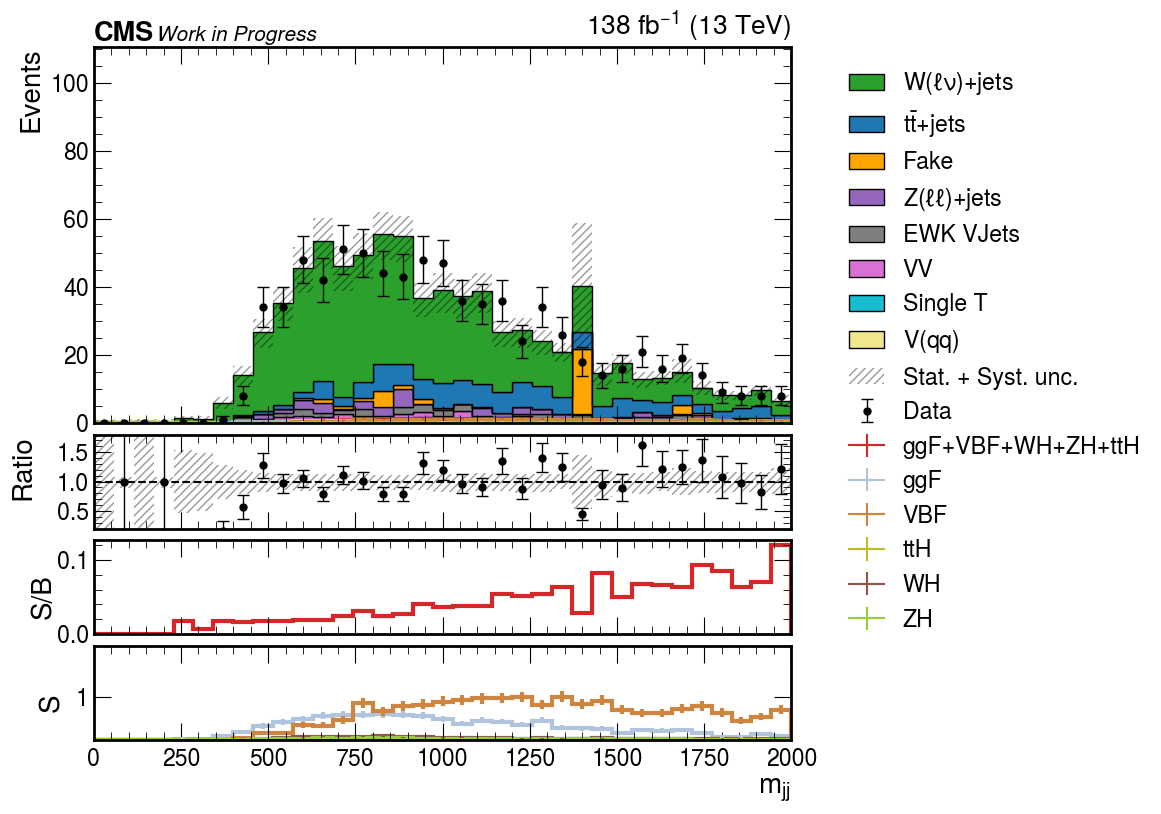

In [341]:
plt.rcParams.update({"font.size": 20})
add_data = False

if "SR" in region or ("Signal region") in region:
    blind_region=[90,160]
    mult = 10
else:
    blind_region=False
    mult = 1

if "VBF category" in categories_sel:
    mult = 5


from utils import plot_hists as plot_hists
# PATH = f"/Users/fmokhtar/Desktop/AN_2024/lol/UL16/without_trigSF"
PATH = f"/Users/fmokhtar/Desktop/AN_2024/lol"
# PATH = f"/Users/fmokhtar/Desktop/AN_2024/lol/"

# if add_TRG_SF:
#     PATH = f"/Users/fmokhtar/Desktop/AN_2024/eletriggerSF/UL{year[2:].replace('APV', '')}/with_trgSF"
# else:
#     PATH = f"/Users/fmokhtar/Desktop/AN_2024/eletriggerSF/UL{year[2:].replace('APV', '')}/without_trgSF"

if not os.path.exists(PATH):
    os.makedirs(PATH)    

nice_ch = {
    "ele": "Electron",
    "mu": "Muon",
}

plot_hists(hists, years_to_plot, channels_to_plot, vars_to_plot,
            add_data=True,
            logy=False,
            mult=mult,
            outpath=PATH,
#             text_=f"{nice_ch[ch]} channel",
            blind_region=blind_region,
#            save_as=f"{years[0]}_{channels[0]}",
#            save_as=f"{ch}",
            plot_Fake_unc=0.25,
            plot_syst_unc=(SYST_UNC_up, SYST_UNC_down) if plot_syst_unc else None,
           add_soverb=True,
           legend_ncol=2,
#            seperate_Fake_unc=True,
          )
print()

# if "QCD" in samples_to_plot:
#     get_soverb(events_dict, presel, categories_sel, years, channels, precision=1)
# else:
#     get_soverb(events_dict, presel, categories_sel, years, channels, precision=1, usefake=True)    

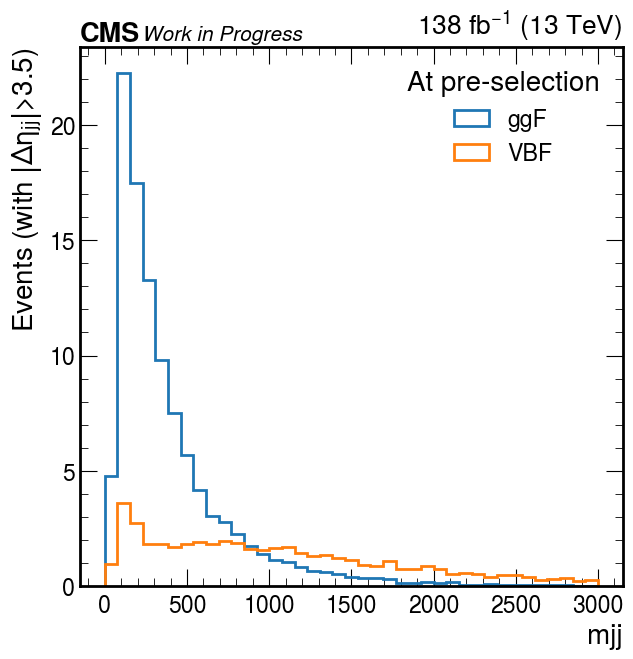

In [362]:

fig, ax = plt.subplots(figsize=(7,7))

l = []
for year in years:
    for ch in channels:
        l.append(events_dict[year][ch]["ggF"])
df = pd.concat(l)
ax.hist(
    df["mjj"],
    weights=df["nominal"],
    bins=np.linspace(0, 3000, 40),
    label="ggF",
    linewidth=2,
    histtype="step",
)
l = []
for year in years:
    for ch in channels:
        l.append(events_dict[year][ch]["VBF"])
df = pd.concat(l)
ax.hist(
    df["mjj"],    
    weights=df["nominal"],
    bins=np.linspace(0, 3000, 40),
    label="VBF",
    linewidth=2,
    histtype="step",
)
ax.legend(title="At pre-selection")        

ax.set_xlabel("mjj")
ax.set_ylabel(r"Events (with $\left| \Delta \eta_{jj} \right|$>3.5)")

hep.cms.lumitext("%.0f " % get_lumi(years, channels) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

plt.savefig("/Users/fmokhtar/Desktop/AN_2024/mjj_deta_preselection.pdf")

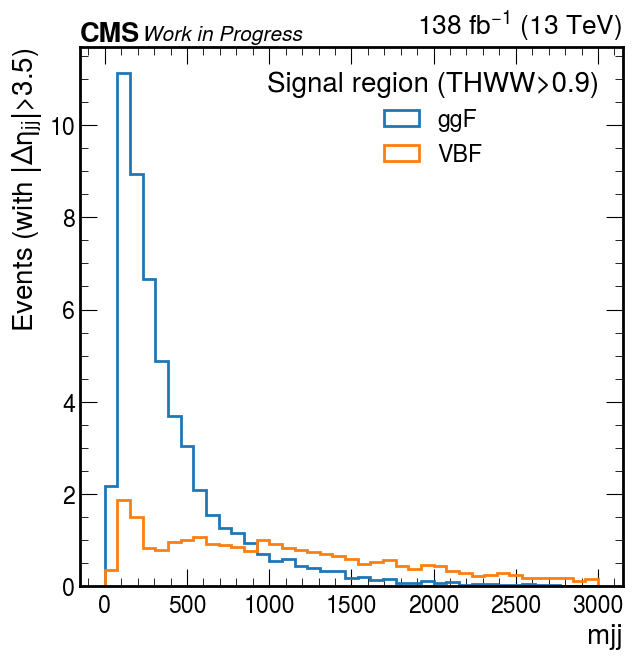

In [363]:

fig, ax = plt.subplots(figsize=(7,7))

l = []
for year in years:
    for ch in channels:
        df = events_dict[year][ch]["ggF"]
        df = df[(df["THWW"]>0.9)]
        l.append(df)
df = pd.concat(l)
ax.hist(
    df["mjj"],
    weights=df["nominal"],
    bins=np.linspace(0, 3000, 40),
    label="ggF",
    linewidth=2,
    histtype="step",
)
l = []
for year in years:
    for ch in channels:
        df = events_dict[year][ch]["VBF"]
        df = df[(df["THWW"]>0.9)]
        l.append(df)
df = pd.concat(l)
ax.hist(
    df["mjj"],    
    weights=df["nominal"],
    bins=np.linspace(0, 3000, 40),
    label="VBF",
    linewidth=2,
    histtype="step",
)
ax.legend(title="Signal region (THWW>0.9)")        

ax.set_xlabel("mjj")
ax.set_ylabel(r"Events (with $\left| \Delta \eta_{jj} \right|$>3.5)")

hep.cms.lumitext("%.0f " % get_lumi(years, channels) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

plt.savefig("/Users/fmokhtar/Desktop/AN_2024/mjj_deta_SR.pdf")

In [1311]:
nom = df["weight_mu"]*df["top_reweighting"]
nom

0      231.099383
1      269.679876
2      223.729588
3      269.266342
4      266.373133
          ...    
144    226.672248
145    262.662048
146    270.760738
147    260.548283
148    217.290516
Length: 149, dtype: float64

In [1313]:
up = nom * df["top_reweighting"]
down = nom / df["top_reweighting"]
print(up)
print(down)

0      192.789296
1      247.828146
2      209.807018
3      252.920687
4      255.960470
          ...    
144    191.426741
145    249.087870
146    260.404342
147    232.534384
148    198.390085
Length: 149, dtype: float64
0      277.022252
1      293.458336
2      238.576045
3      286.668376
4      277.209391
          ...    
144    268.407160
145    276.975959
146    281.529013
147    291.937074
148    237.991573
Length: 149, dtype: float64


In [1331]:
import pickle as pkl
with open("ttt/outfiles/0-1.pkl", "rb") as f:
    out = pkl.load(f)

In [1337]:
out["GluGluHToWW_Pt-200ToInf_M-125"]["2017"]["cutflows"]

{'mu': {'PU_cutoff': 11140.801575541496,
  'Trigger': 1299.7759100794792,
  'METFilters': 1297.4169701337814,
  'OneLep': 1135.5936898589134,
  'NoTaus': 891.207511484623,
  'AtLeastOneFatJet': 737.4046270251274,
  'CandidateJetpT': 428.38349413871765,
  'LepInJet': 273.637033700943,
  'JetLepOverlap': 257.1244540810585,
  'dPhiJetMET': 185.8844677209854,
  'MET': 172.20261603593826,
  'Signal': 172.20261603593826}}

In [1338]:
out["GluGluHToWW_Pt-200ToInf_M-125"]["2017"]["sumgenweight"]   # before PU cut

11317.25

In [ ]:
11140 

In [ ]:
11317

In [1378]:
df = pd.read_parquet("ttt/outfiles/0-1_mu.parquet")
for key in df:
    if "weight_mu_TopPtReweig" in key:
        print(key)

In [1382]:
(df["leptonic_tau_veto"]).sum()

364

In [1328]:
df["weight_mu_TopPtReweightDown"]

0      231.099383
1      269.679876
2      223.729588
3      269.266342
4      266.373133
          ...    
144    226.672248
145    262.662048
146    270.760738
147    260.548283
148    217.290516
Name: weight_mu_TopPtReweightDown, Length: 149, dtype: float64

In [1329]:
df["weight_mu_TopPtReweightUp"]

0      277.022263
1      293.458336
2      238.576043
3      286.668392
4      277.209396
          ...    
144    268.407156
145    276.975967
146    281.529024
147    291.937075
148    237.991584
Name: weight_mu_TopPtReweightUp, Length: 149, dtype: float64

In [1300]:
df["weight_mu_id_muonUp"]

0      0.257303
1      0.452643
2      0.170928
3      0.367452
4      0.469986
         ...   
369    0.449405
370    0.576867
371    0.428918
372    0.461520
373    0.478407
Name: weight_mu_id_muonUp, Length: 374, dtype: float64

In [1301]:
df["weight_mu_id_muon_systUp"]

0      0.257289
1      0.452615
2      0.170922
3      0.367440
4      0.469971
         ...   
369    0.449382
370    0.576837
371    0.428770
372    0.461496
373    0.478382
Name: weight_mu_id_muon_systUp, Length: 374, dtype: float64

In [1302]:
df["weight_mu_id_muon_statUp"]

0      0.257188
1      0.452050
2      0.170572
3      0.366687
4      0.469008
         ...   
369    0.449205
370    0.576610
371    0.425593
372    0.461315
373    0.478194
Name: weight_mu_id_muon_statUp, Length: 374, dtype: float64

In [1202]:
df = pd.read_parquet("ttt/outfiles/0-1_mu.parquet")

In [1206]:
for key in df:
    if "id" in key:
        print(key)

weight_ele_id_electronUp
weight_ele_id_electronDown
weight_mu_id_muonDown
weight_mu_id_muonUp


In [1207]:
df["weight_mu_id_muonUp"]

0      0.260155
1      0.457236
2      0.172878
3      0.371644
4      0.475348
         ...   
369    0.454386
370    0.583260
371    0.449638
372    0.466635
373    0.483709
Name: weight_mu_id_muonUp, Length: 374, dtype: float64

In [1208]:
df["weight_ele_id_electronUp"]

0      0.265232
1      0.480151
2      0.363344
3      0.376317
4      0.463403
         ...   
369    0.468057
370    0.597104
371    0.422063
372    0.483947
373    0.495896
Name: weight_ele_id_electronUp, Length: 374, dtype: float64

In [8]:
samples = [
        "ggF",
        "VBF",
        "ttH",
        "WH",
        "ZH",

        "SingleTop",
        "Diboson",
        "EWKvjets",
        "WJetsLNu",

        "DYJets",
        "WZQQ",

        "TTbar",
]

In [26]:
mass_window = [80, 160]

tagger = "THWW"

tagger_cuts = [0.85, 0.875, 0.9, 0.925, 0.95, 0.975, 0.99]
s_over_b = {}

for var in [
    "rec_higgs_m",
    "fj_ParT_mass",
]:
    
    s_over_b1[var] = []
    print(var)
    for tagger_cut in tagger_cuts:  
        print(tagger_cut)
        s, b = 0, 0
        for year in years:
            print(year)
            for ch in channels:
                for sample in samples:

                    df = events_dict[year][ch][sample]

                    df = df[df[f"{tagger}"]>tagger_cut]

                    ######################## soverb start
                    df = df[(df[var]>=mass_window[0]) & (df[var]<=mass_window[1])]

                    if sample in utils.signals:
                        s += df["nominal"].sum()
                    else:
                        b += df["nominal"].sum()
                    ######################## soverb end
#             break
        s_over_b[var].append(s/math.sqrt(b))

rec_higgs_m
0.875
2016
2016APV
2017
2018
fj_ParT_mass
0.875
2016
2016APV
2017
2018


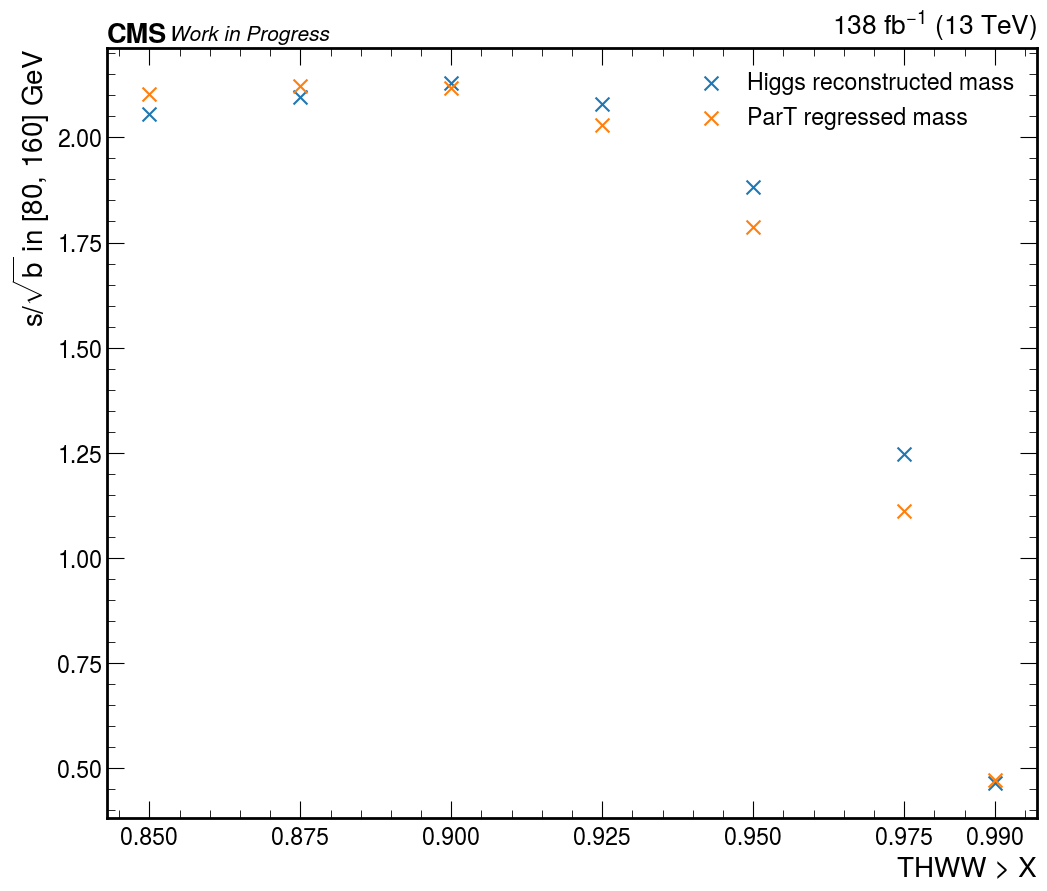

In [45]:
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(12, 10))
for var in [
    "rec_higgs_m",
    "fj_ParT_mass",
]:
    
    if var == "rec_higgs_m":
        lab = "Higgs reconstructed mass"
    else:
        lab = "ParT regressed mass"
        
    ax.scatter(tagger_cuts, s_over_b[var], marker="x", s=100, label=lab)

ax.legend()
ax.set_ylabel(r"$s/\sqrt{b}$ in [80, 160] GeV"); 
ax.set_xlabel(r"THWW > X");

ax.set_xticks(tagger_cuts)

hep.cms.lumitext("%.0f " % get_lumi(years, channels) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig("/Users/fmokhtar/Desktop/AN_2024/soverb-mobs_vs_regressedmass.pdf")

In [36]:
tagger_cuts

[0.85, 0.875, 0.9, 0.925, 0.95, 0.975, 0.99]

In [49]:
finetuned = [0.9811433403854124, 0.9199396034374864, 0.7695137991111439, 0.374305684732186]
fromscratch = [1.1306993005042512, 1.05794272246181, 0.9888320566953892, 0.5175346965932851]

(0.0, 2.4)

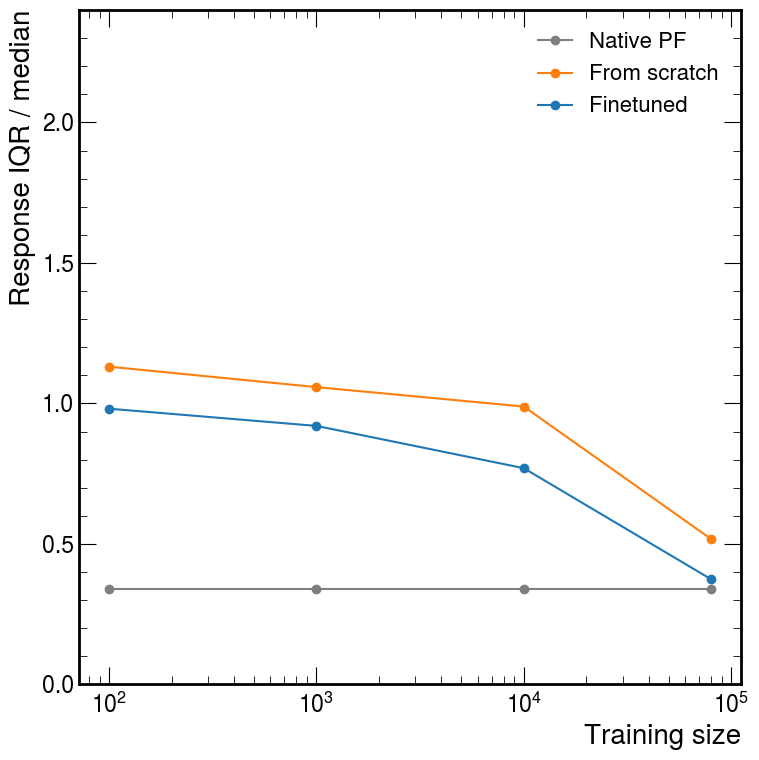

In [116]:
# Plot IQR/M as a function of gen pt    
plt.figure(figsize=(8,8))
ax = plt.gca()

xticks = [100,1_000,10_000,80_000]
plt.plot(xticks, np.array(finetuned) * 0 + 0.3390942375753732, marker="o", label="Native PF", color="tab:grey")

plt.plot(xticks, fromscratch, marker="o", label="From scratch", color="tab:orange")
plt.plot(xticks, finetuned, marker="o", label="Finetuned", color="tab:blue")

plt.xticks(xticks)
plt.xscale("log")
plt.legend(loc=1, fontsize=16)
plt.ylabel("Response IQR / median")
plt.xlabel("Training size")
plt.tight_layout()
plt.ylim(0,2.4)    
# sample_label(ax, sample)
# plt.savefig(f"{outdir}/{sample}_met_IQR.pdf")

In [ ]:
finetuned = [0.9811433403854124, 0.9199396034374864, 0.7695137991111439, 0.374305684732186]
fromscratch = [1.1306993005042512, 1.05794272246181, 0.9888320566953892, 0.5175346965932851]

In [ ]:
# Plot IQR/M as a function of gen pt    
plt.figure(figsize=(8,8))
ax = plt.gca()

xticks = [100,1_000,10_000,80_000]
plt.plot(xticks, fromscratch, marker="o", label="From scratch", color="tab:orange")
plt.plot(xticks, finetuned, marker="o", label="Finetuned", color="tab:blue")

plt.xticks(xticks)
plt.xscale("log")
plt.legend(loc=1, fontsize=16)
plt.ylabel("Response IQR / median")
plt.xlabel("Training size")
plt.tight_layout()
plt.ylim(0,2.4)    
# sample_label(ax, sample)
# plt.savefig(f"{outdir}/{sample}_met_IQR.pdf")

# STXS binning
https://cms-analysis.github.io/HiggsAnalysis-CombinedLimit/tutorial2023_unfolding/unfolding_exercise/#simplified-unfolding


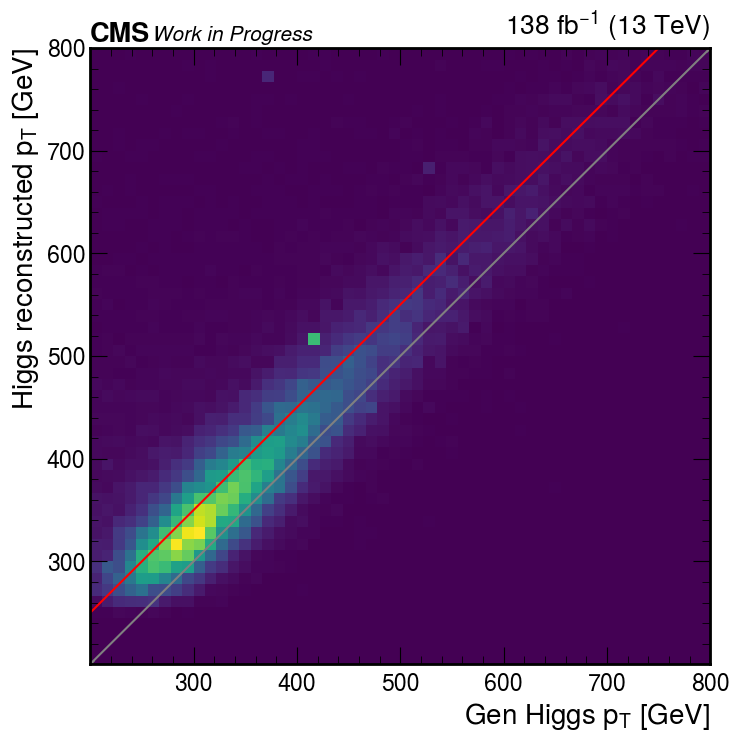

In [71]:
presel = {
    "Pre-selection": f"({tagger}>0.5) & fj_mass>40",   # dummy

#     "bveto": f"n_bjets_T>0",   # dummy    

    
#     "SR": f"{tagger}>0.9 & (n_bjets_T==0) & fj_mass>55",

    
#     "Top CR": f"({tagger}>0) & (n_bjets_T>0) & fj_ParT_mass>100",
#     "Top CR": f"({tagger}>0.5) & (met_pt>50)",    
#     "WJets CR": f"({tagger}<{WP2}) & ({tagger}>{WP1}) & (n_bjets_T==0) & fj_ParT_mass>100",
}

lab_dict = {
    "rec_higgs_pt": r"Higgs reconstructed $p_T$ [GeV]",
    "fj_genH_pt": r"Gen Higgs $p_T$ [GeV]",
    
}


varx = "fj_genH_pt"
vary = "rec_higgs_pt"


years = [
    "2018",
    "2017",
    "2016APV",
    "2016",
]


Xs, Ys, ws = [], [], []

for sample in [
    "ggF", 
    "VBF",
    "ttH",
    "ZH",
    "WH",
]:

    for year in years:
        for ch in channels:
            region, sel = list(presel.items())[0]

            df = events_dict[year][ch][sample]
            df = df.query(sel)

            Xs += list(df[varx])
            Ys += list(df[vary])

            ws += list(df["nominal"])


Xs = np.array(Xs)
Ys = np.array(Ys)
ws = np.array(ws)
            
fig, ax = plt.subplots(figsize=(8,8))

plt.hist2d(
    Xs, 
    Ys,
    bins=np.linspace(200,800,55),
    weights=ws,
)
plt.plot([200, 800], [200, 800], marker="x", color="grey")

shift = 50
plt.plot([200-shift, 800], [200, 800+shift], marker="x", color="red")

ax.set_xticks([300,400,500,600,700,800])
ax.set_yticks([300,400,500,600,700,800])

# ax.set_title(sample, pad=15)
ax.set_xlabel(lab_dict[varx])
ax.set_ylabel(lab_dict[vary])

hep.cms.lumitext("%.0f " % get_lumi(years, channels) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15);

plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/STXS_2d.pdf")

pt shift: 0 [GeV] - Sum across the diagonal: 2.02
pt shift: 50 [GeV] - Sum across the diagonal: 2.26


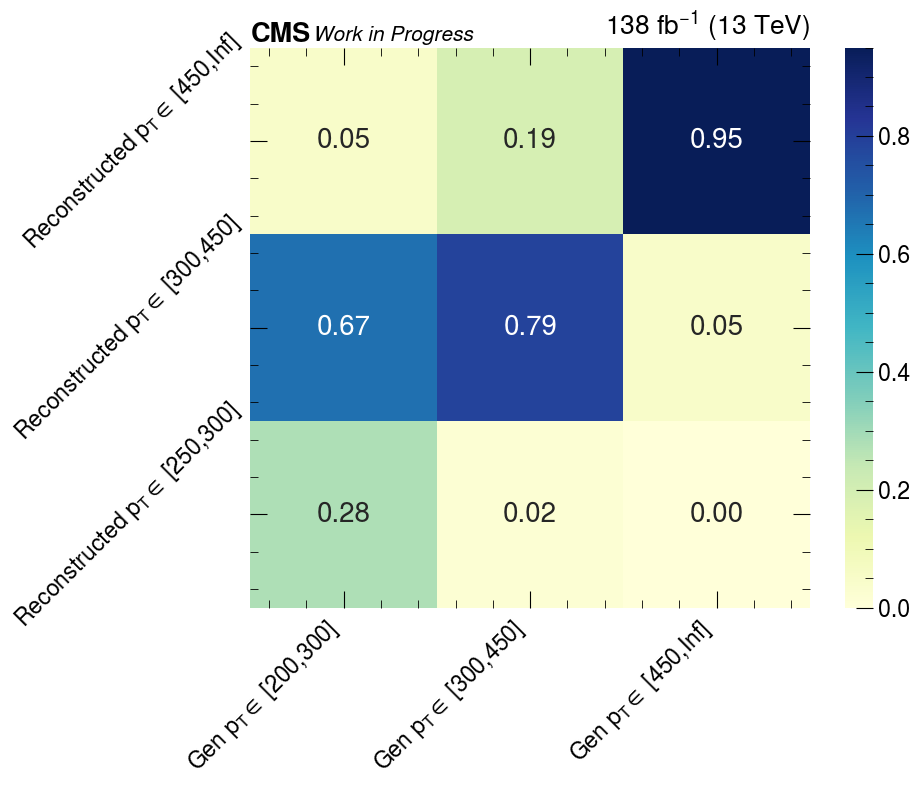

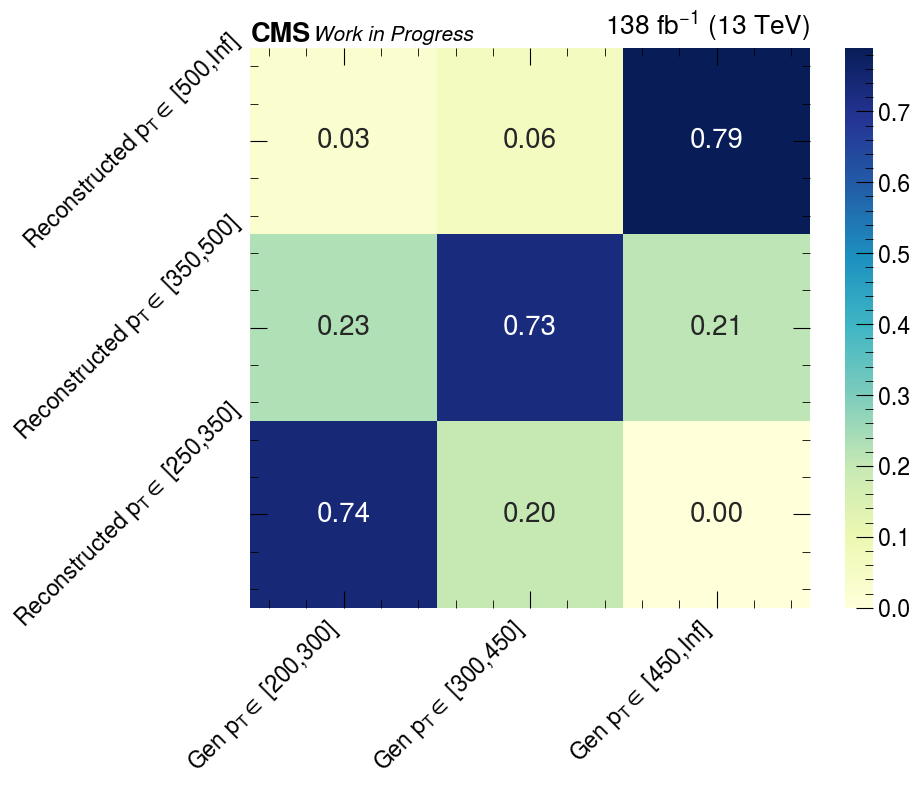

In [72]:
"""
https://cms-analysis.github.io/HiggsAnalysis-CombinedLimit/tutorial2023_unfolding/unfolding_exercise/#simplified-unfolding
"""
    
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

for shift in [
    0,
#     5,
#     10,
#     15,
#     20,
#     25,
#     30,
#     35,
#     40,
#     45,
    50,
#     55,
#     60,
]:


    # Define the bin labels
    gen_labels = [
        r'Gen $p_T \in$ [200,300]',
        r'Gen $p_T \in$ [300,450]',
        r'Gen $p_T \in$ [450,Inf]',
    ]

    reco_labels = [
        r'Reconstructed $p_T \in$' + f' [{450 + shift},Inf]',
        r'Reconstructed $p_T \in$' + f' [{300 + shift},{450+shift}]',
        r'Reconstructed $p_T \in$' + f' [{250},{300+shift}]',
    ]

    stxs_bins = [
        (200,300),
        (300,450),
        (450,3000),
    ]

    reco_bins = [
        (450+shift,3000),
        (300+shift,450+shift),
        (250,300+shift),
    ]

    M = np.zeros((len(stxs_bins),len(reco_bins)))    

    for i, stxs_bin in enumerate(stxs_bins):
    #     print("stxs_bin: ", stxs_bin)
        msk_gen = (Xs > stxs_bin[0]) & (Xs < stxs_bin[1])

        Ys_bin = Ys[msk_gen]

        for j, reco_bin in enumerate(reco_bins):
            msk_reco = (Ys[msk_gen] > reco_bin[0]) & (Ys[msk_gen] < reco_bin[1])

            M[j, i] = round(msk_reco.sum() / len(Ys[msk_gen]), 2)
    #         print("reco_bin", reco_bin, M[j, i])

    #     print("-------------")
    
    print(f"pt shift: {shift} [GeV] -", f"Sum across the diagonal: {np.trace(np.fliplr(M)):.2f}")
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 8))
    # sns.heatmap(M, annot=True, fmt=".2f", cmap='YlGnBu', xticklabels=gen_labels, yticklabels=reco_labels, cbar_kws={'label': 'Probability'})
    sns.heatmap(M, annot=True, fmt=".2f", cmap='YlGnBu', xticklabels=gen_labels, yticklabels=reco_labels)

    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45)

#     ax.set_xlabel(r'Gen $pT$ bins')
#     ax.set_ylabel(r'Reco $p_T$ bins')

    plt.tight_layout()
    
    hep.cms.lumitext("%.0f " % get_lumi(years, channels) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
    hep.cms.text("Work in Progress", ax=ax, fontsize=15);
    
    plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/STXS_migration_matrix_shift{shift}.pdf")

In [68]:
np.trace(np.fliplr(M))

2.26

In [462]:
M

array([[0.03, 0.08, 0.83],
       [0.29, 0.78, 0.17],
       [0.68, 0.15, 0.  ]])

# 2d-correlation mass plots

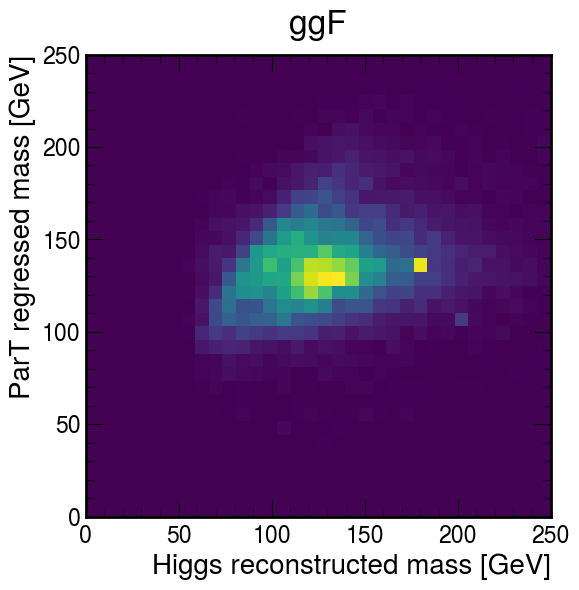

In [424]:
presel = {
    "Pre-selection": f"({tagger}>0.5) & fj_mass>55 & fj_lsf3>0.8",   # dummy

#     "bveto": f"n_bjets_T>0",   # dummy    

    
#     "SR": f"{tagger}>0.9 & (n_bjets_T==0) & fj_mass>55",

    
#     "Top CR": f"({tagger}>0) & (n_bjets_T>0) & fj_ParT_mass>100",
#     "Top CR": f"({tagger}>0.5) & (met_pt>50)",    
#     "WJets CR": f"({tagger}<{WP2}) & ({tagger}>{WP1}) & (n_bjets_T==0) & fj_ParT_mass>100",
}

lab_dict = {
    "rec_higgs_m": r"Higgs reconstructed mass [GeV]",
    "fj_ParT_mass": r"ParT regressed mass [GeV]",
    "fj_mass": r"Higgs candidate soft-drop mass [GeV]",
}


varx = "rec_higgs_m"
vary = "fj_ParT_mass"

for sample in [
    "ggF", 
#     "VBF",
#     "WJetsLNu",
#     "TTbar",
]:

    Xs, Ys, ws = [], [], []
    for year in years:
        for ch in channels:
            region, sel = list(presel.items())[0]

            df = events_dict[year][ch][sample]
            df = df.query(sel)
            
            Xs += list(df[varx])
            Ys += list(df[vary])

            ws += list(df["nominal"])


    fig, ax = plt.subplots(figsize=(6,6))

    plt.hist2d(
        Xs, 
        Ys,
        bins=np.linspace(0,250,35),
        weights=ws,
    )

    ax.set_title(sample, pad=15)
    ax.set_xlabel(lab_dict[varx])
    ax.set_ylabel(lab_dict[vary]);        

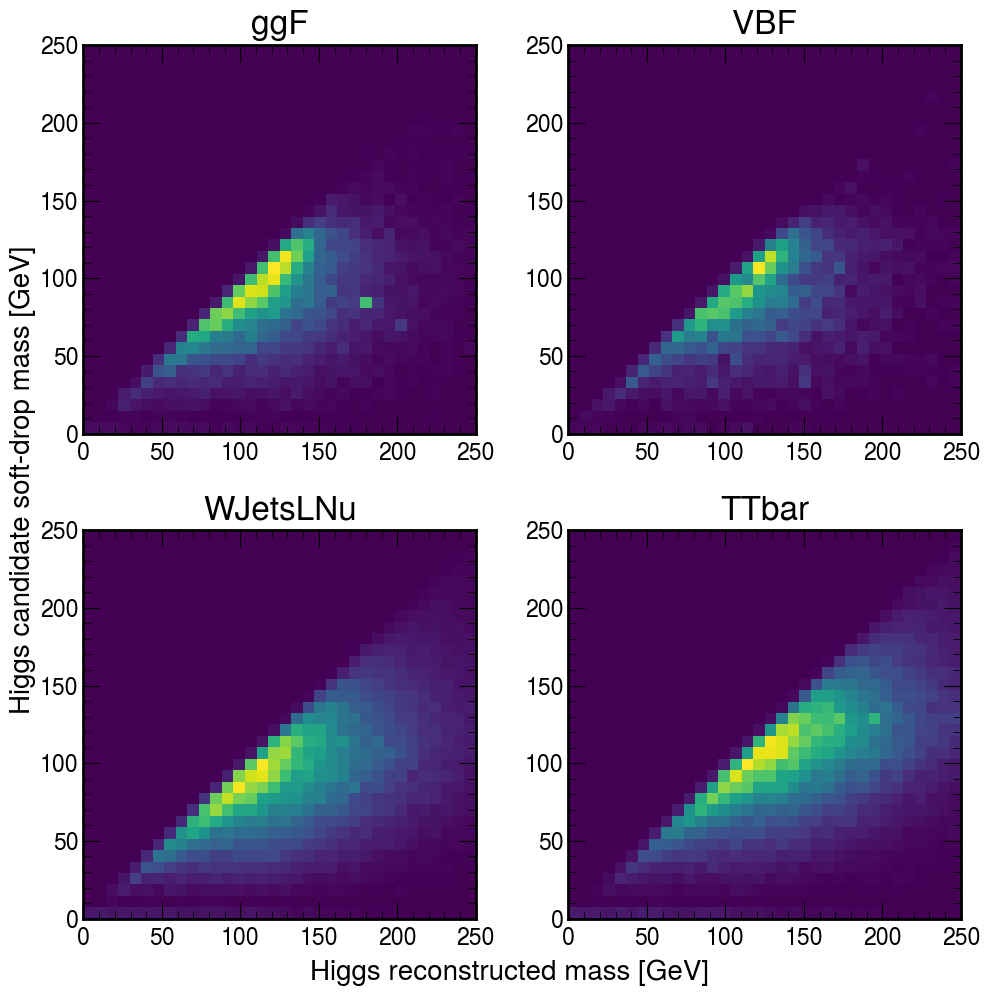

In [427]:
presel = {
    "Pre-selection": f"({tagger}>0.5)",   # dummy

#     "bveto": f"n_bjets_T>0",   # dummy    

    
#     "SR": f"{tagger}>0.9 & (n_bjets_T==0) & fj_mass>55",

    
#     "Top CR": f"({tagger}>0) & (n_bjets_T>0) & fj_ParT_mass>100",
#     "Top CR": f"({tagger}>0.5) & (met_pt>50)",    
#     "WJets CR": f"({tagger}<{WP2}) & ({tagger}>{WP1}) & (n_bjets_T==0) & fj_ParT_mass>100",
}

lab_dict = {
    "rec_higgs_m": r"Higgs reconstructed mass [GeV]",
    "fj_ParT_mass": r"ParT regressed mass [GeV]",
    "fj_mass": r"Higgs candidate soft-drop mass [GeV]",
}


varx = "rec_higgs_m"
vary = "fj_mass"
# vary = "fj_ParT_mass"

fig, axes = plt.subplots(figsize=(10,10), nrows=2, ncols=2)

for sample, axi in {
    "ggF": (0,0),
    "VBF": (0,1),
    "WJetsLNu": (1,0),
    "TTbar": (1,1),
}.items():

    Xs, Ys, ws = [], [], []
    for year in years:
        for ch in channels:
            region, sel = list(presel.items())[0]

            df = events_dict[year][ch][sample]
            df = df.query(sel)
            
            Xs += list(df[varx])
            Ys += list(df[vary])

            ws += list(df["nominal"])

    axes[axi[0],axi[1]].hist2d(
        Xs, 
        Ys,
        bins=np.linspace(0,250,35),
        weights=ws,
    )

    axes[axi[0],axi[1]].set_title(sample, pad=8)

fig.text(0.5, 0, lab_dict[varx], ha='center')
fig.text(0, 0.5, lab_dict[vary], va='center', rotation='vertical')

plt.tight_layout()
plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/lol/2d_1.pdf")

# Mass sculpting

In [243]:
presel = {
    "Pre-selection": f"(fj_mass>40)",   # dummy    
}

channels = ["ele", "mu"]
# channels = ["ele"]
years = ["2018", "2017", "2016", "2016APV"]
# years = ["2018"]

import utils

massbin = 10

samples = [
    "ggF",
    "VBF",
    "TTbar",
    "WJetsLNu",
]

# var = "rec_higgs_m"
# var = "fj_ParT_mass"
var = "fj_mass"

hists = {}
for sample in samples:

    if var == "rec_higgs_m":
        hists[sample] = hist2.Hist(
            hist2.axis.StrCategory([], name="THWW", growth=True),
            hist2.axis.Variable(list(range(45, 255, massbin)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True),
            storage=hist2.storage.Weight(),
        )
    elif var == "fj_ParT_mass":
        hists[sample] = hist2.Hist(
            hist2.axis.StrCategory([], name="THWW", growth=True),
            hist2.axis.Variable(list(range(55, 255, massbin)), name="var", label=r"ParT mass [GeV]", overflow=True),
            storage=hist2.storage.Weight(),
        )
        
    elif var == "fj_mass":
        hists[sample] = hist2.Hist(
            hist2.axis.StrCategory([], name="THWW", growth=True),
            hist2.axis.Variable(list(range(40, 255, massbin)), name="var", label=r"Higgs candidate soft-drop mass [GeV]", overflow=True),
            storage=hist2.storage.Weight(),
        )
    else:
        continue
        
    for year in years:
        for ch in channels:
            if ch=="mu":
                if sample=="Fake":
                    continue
            region, sel = list(presel.items())[0]

            df = events_dict[year][ch][sample]
            df = df.query(sel)

            if "TTbar" in sample:
                df["nominal"] *= df["top_reweighting"]

            for cut in [0, 0.2, 0.5, 0.7, 0.9]:
                msk = df["THWW"]>cut

                x = df[var][msk]
                w = df["nominal
                       "][msk]

                hists[sample].fill(
                    THWW=f"THWW>{cut}",
                    var=x,
                    weight=w,
                )

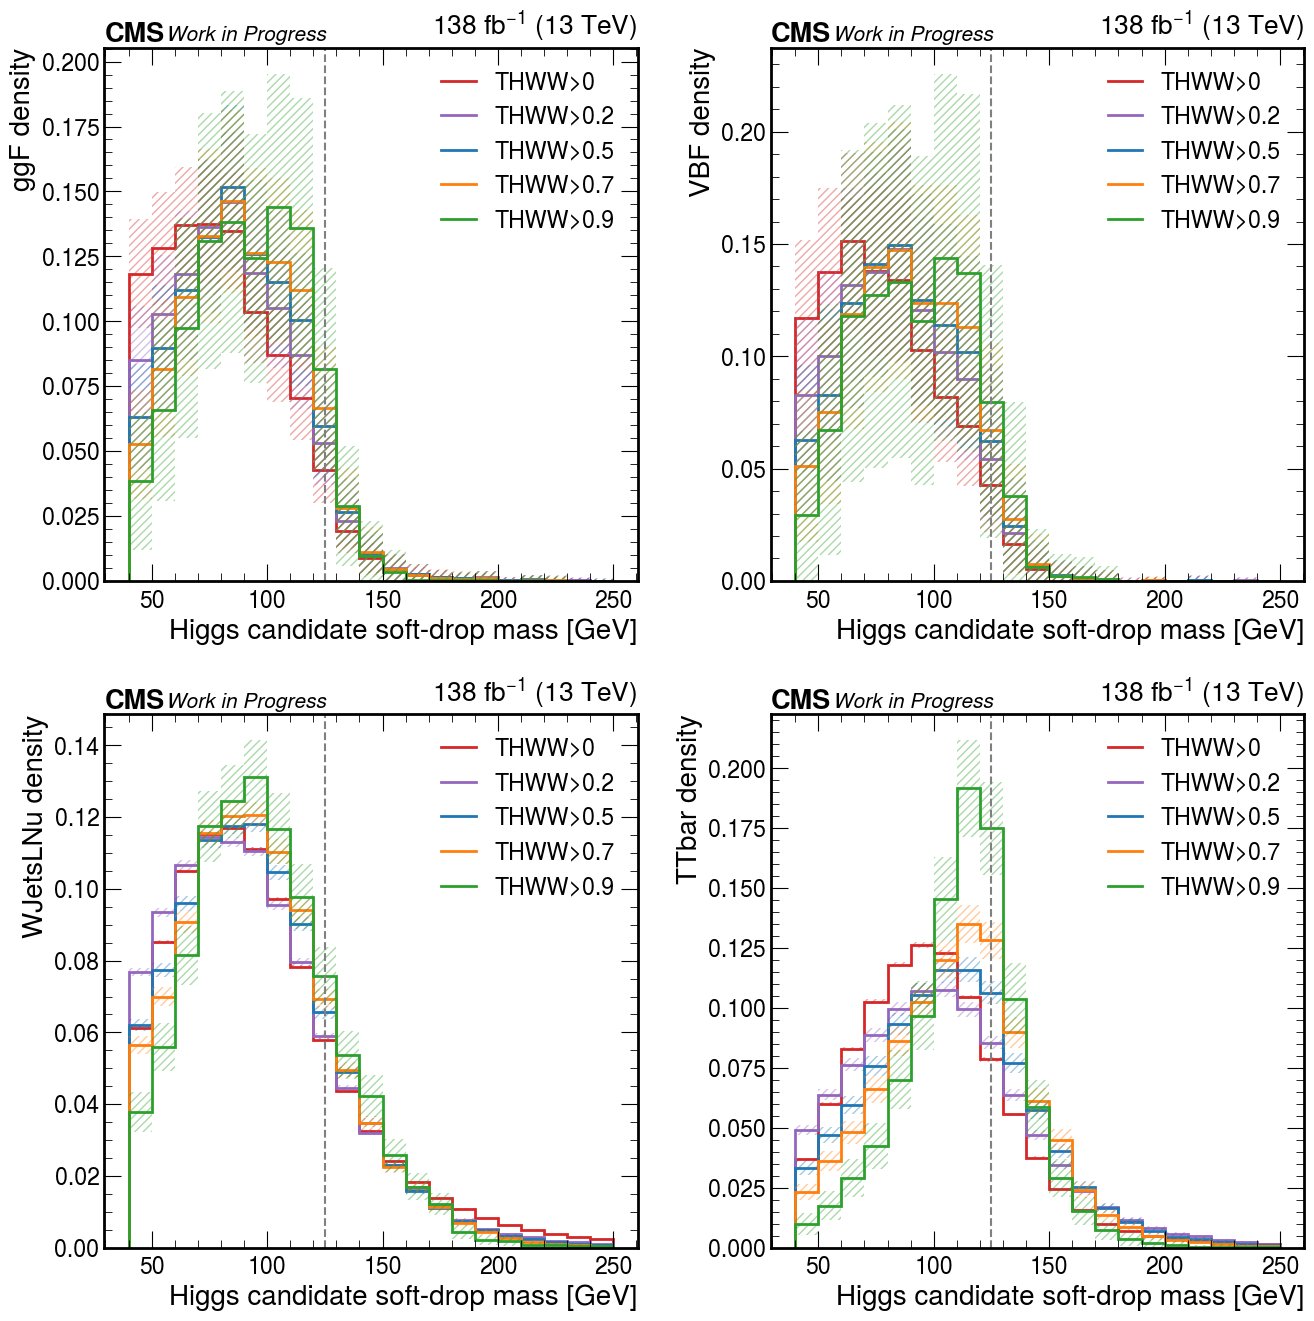

In [244]:
color_region = {
    "THWW>0": "tab:red",
    "THWW>0.2": "tab:purple",
    "THWW>0.5": "tab:brown",    
    "THWW>0.5": "tab:blue",
    "THWW>0.7": "tab:orange",
    "THWW>0.9": "tab:green",
}

def errps(cut):
    return {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": color_region[cut],
        "linewidth": 0,
        "alpha": 0.4,
    }


fig, axes = plt.subplots(figsize=(15,15), nrows=2, ncols=2)

for sample, axi in {
    "ggF": (0,0),
    "VBF": (0,1),
    "WJetsLNu": (1,0),
    "TTbar": (1,1),
}.items():
    
    h = hists[sample]

#     fig, ax = plt.subplots(figsize=(8, 8))
    for region in list(h.axes["THWW"]):

        bkg = h[{"THWW": region}].project("var")    

        bkg2 = bkg.values()/bkg.values().sum()
        hep.histplot(
    #         bkg,
            bkg2,
            bins=bkg.axes[0].edges,        
            ax=axes[axi[0],axi[1]],
    #         density=True,
            linewidth=2,
            label=region,
            flow="none",
            color=color_region[region]
        )

        axes[axi[0],axi[1]].stairs(
            values=(bkg.values() + np.sqrt(bkg.values()))/bkg.values().sum(),
            baseline=(bkg.values() - np.sqrt(bkg.values()))/bkg.values().sum(),
            edges=bkg.axes[0].edges,
            **errps(region),
    #         label="Stat. unc.",
        )

    axes[axi[0],axi[1]].legend()

    axes[axi[0],axi[1]].set_xlabel(bkg.axes.label[0])
    axes[axi[0],axi[1]].set_ylabel(f"{sample} density")

    axes[axi[0],axi[1]].set_ylim(0)
    # ax.set_yscale("log")
    
    axes[axi[0],axi[1]].axvline(125, color="grey", linestyle="--")

    hep.cms.lumitext("%.0f " % get_lumi(years, channels) + r"fb$^{-1}$ (13 TeV)", ax=axes[axi[0],axi[1]], fontsize=20)
    hep.cms.text("Work in Progress", ax=axes[axi[0],axi[1]], fontsize=15);
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.25, hspace=0.25)

plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/masscultping_{var}.pdf")

# Mass distribution

In [276]:
samples = [
    "ggF",
    "VBF",
    "TTbar",
    "WJetsLNu",
]


regions = {
    "Pre-selection": f"(fj_mass>40)",   # dummy   
    "Signal region": f"(THWW>0.9)",   # dummy
}

channels = ["ele", "mu"]
# channels = ["ele"]
years = ["2018", "2017", "2016", "2016APV"]
# years = ["2018"]

import utils

massbin = 10

var = "rec_higgs_m"
# var = "fj_ParT_mass"
# var = "fj_mass"
var = "rec_W_qq_m"
# var = "rec_W_lnu_m"

hists = {}
for region in regions:
    if var == "rec_higgs_m":
        hists[region] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            hist2.axis.Variable(list(range(45, 255, massbin)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True),
            storage=hist2.storage.Weight(),
        )
    elif var == "fj_ParT_mass":
        hists[region] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            hist2.axis.Variable(list(range(55, 255, massbin)), name="var", label=r"ParT mass [GeV]", overflow=True),
            storage=hist2.storage.Weight(),
        )
    elif var == "fj_mass":
        hists[region] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            hist2.axis.Variable(list(range(40, 255, massbin)), name="var", label=r"Higgs candidate soft-drop mass [GeV]", overflow=True),
            storage=hist2.storage.Weight(),
        )
    elif var == "rec_W_qq_m":
        hists[region] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            hist2.axis.Regular(20, 0, 160, name="var", label=r"Reconstructed $W_{qq}$ mass [GeV]", overflow=True),
            storage=hist2.storage.Weight(),
        )        
    elif var == "rec_W_lnu_m":
        hists[region] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            hist2.axis.Regular(20, 0, 160, name="var", label=r"Reconstructed $W_{\ell \nu}$ mass [GeV]", overflow=True),
            storage=hist2.storage.Weight(),
        )
    else:
        continue    

    for sample in samples:

        for year in years:
            for ch in channels:
                if ch=="mu":
                    if sample=="Fake":
                        continue

                df = events_dict[year][ch][sample]

                if "TTbar" in sample:
                    df["nominal"] *= df["top_reweighting"]
                    
                df1 = df.query(regions[region])

                x = df1[var]
                w = df1["event_weight"]

                hists[region].fill(
                    samples=sample,
                    var=x,
                    weight=w,
                )

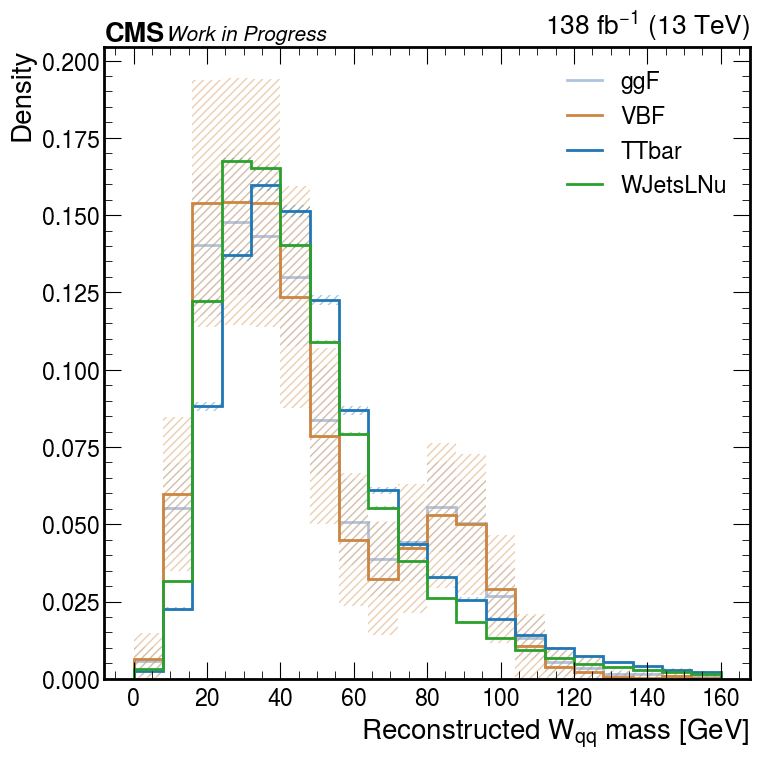

In [277]:
color_region = {
    "ggF": utils.color_by_sample["ggF"],
    "VBF": utils.color_by_sample["VBF"],
    "TTbar": utils.color_by_sample["TTbar"],
    "WJetsLNu": utils.color_by_sample["WJetsLNu"],
}

def errps(cut):
    return {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": color_region[cut],
        "linewidth": 0,
        "alpha": 0.4,
    }


fig, ax = plt.subplots(figsize=(8,8))

region = "Pre-selection"

h = hists[region]

#     fig, ax = plt.subplots(figsize=(8, 8))
for sample in list(h.axes["samples"]):

    bkg = h[{"samples": sample}].project("var")    

    bkg2 = bkg.values()/bkg.values().sum()
    hep.histplot(
#         bkg,
        bkg2,
        bins=bkg.axes[0].edges,        
        ax=ax,
#         density=True,
        linewidth=2,
        label=sample,
        flow="none",
        color=color_region[sample]
    )

    ax.stairs(
        values=(bkg.values() + np.sqrt(bkg.values()))/bkg.values().sum(),
        baseline=(bkg.values() - np.sqrt(bkg.values()))/bkg.values().sum(),
        edges=bkg.axes[0].edges,
        **errps(sample),
#         label="Stat. unc.",
    )

ax.legend()

ax.set_xlabel(bkg.axes.label[0])
ax.set_ylabel(f"Density")

ax.set_ylim(0)
# ax.set_yscale("log")

#     axes[axi].set_title(region, pad=35)

if var in ["rec_higgs_m", "fj_ParT_mass", "fj_mass"]:
    ax.axvline(125, color="grey", linestyle="--")

hep.cms.lumitext("%.0f " % get_lumi(years, channels) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15);
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.25, hspace=0.25)

plt.tight_layout()
plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/mass_{var}_{region}.pdf")

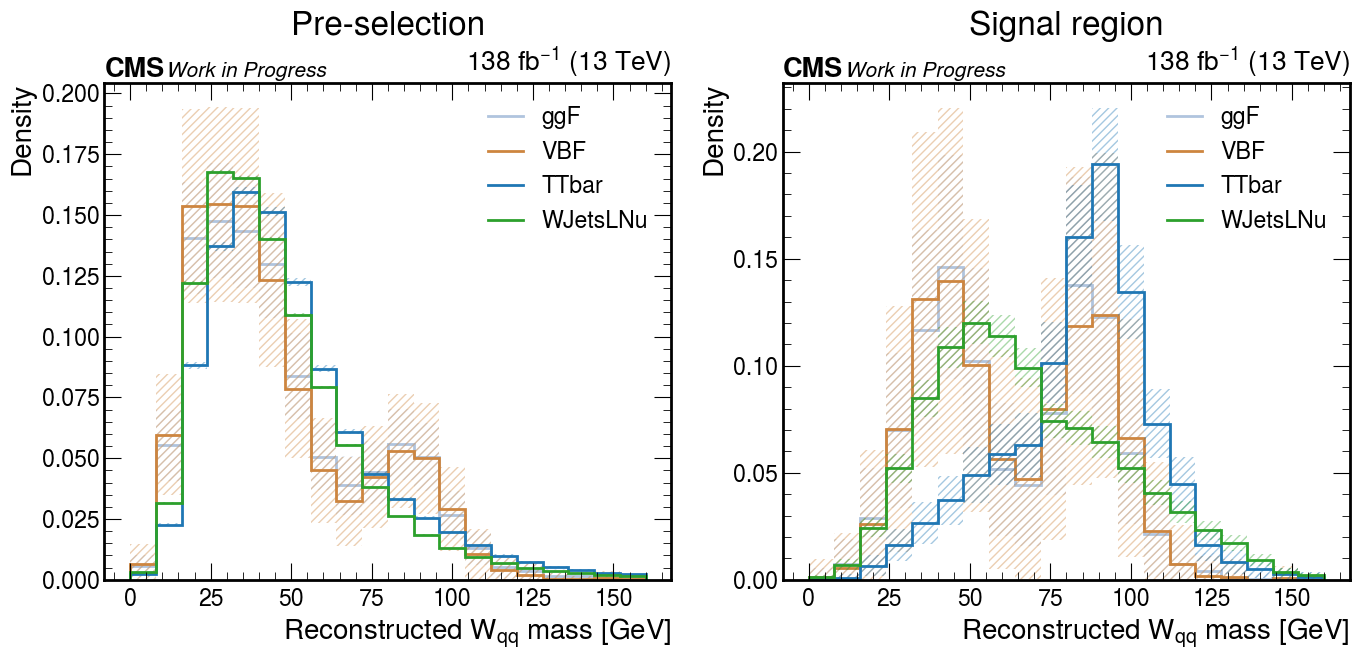

In [278]:
color_region = {
    "ggF": utils.color_by_sample["ggF"],
    "VBF": utils.color_by_sample["VBF"],
    "TTbar": utils.color_by_sample["TTbar"],
    "WJetsLNu": utils.color_by_sample["WJetsLNu"],
}

def errps(cut):
    return {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": color_region[cut],
        "linewidth": 0,
        "alpha": 0.4,
    }


fig, axes = plt.subplots(figsize=(14,7), nrows=1, ncols=2)

for region, axi in {
    "Pre-selection": 0,
    "Signal region": 1,
}.items():
    
    h = hists[region]

#     fig, ax = plt.subplots(figsize=(8, 8))
    for sample in list(h.axes["samples"]):

        bkg = h[{"samples": sample}].project("var")    

        bkg2 = bkg.values()/bkg.values().sum()
        hep.histplot(
    #         bkg,
            bkg2,
            bins=bkg.axes[0].edges,        
            ax=axes[axi],
    #         density=True,
            linewidth=2,
            label=sample,
            flow="none",
            color=color_region[sample]
        )

        axes[axi].stairs(
            values=(bkg.values() + np.sqrt(bkg.values()))/bkg.values().sum(),
            baseline=(bkg.values() - np.sqrt(bkg.values()))/bkg.values().sum(),
            edges=bkg.axes[0].edges,
            **errps(sample),
    #         label="Stat. unc.",
        )

    axes[axi].legend()

    axes[axi].set_xlabel(bkg.axes.label[0])
    axes[axi].set_ylabel(f"Density")

    axes[axi].set_ylim(0)
    # ax.set_yscale("log")
    
    axes[axi].set_title(region, pad=35)
    
    if var in ["rec_higgs_m", "fj_ParT_mass", "fj_mass"]:
        axes[axi].axvline(125, color="grey", linestyle="--")

    hep.cms.lumitext("%.0f " % get_lumi(years, channels) + r"fb$^{-1}$ (13 TeV)", ax=axes[axi], fontsize=20)
    hep.cms.text("Work in Progress", ax=axes[axi], fontsize=15);
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.25, hspace=0.25)

    plt.tight_layout()
plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/mass_{var}_doubleplot.pdf")

In [ ]:
presel = {
    "Pre-selection": f"(THWW>0.5) & (fj_mass>40)",   # dummy    
}

channels = ["ele", "mu"]
# channels = ["ele"]
years = ["2018", "2017", "2016", "2016APV"]
# years = ["2018"]

import utils

massbin = 10

samples = [
    "ggF",
    "VBF",
    "TTbar",
    "WJetsLNu",
]

hists = {}
for sample in samples:

    hists[sample] = hist2.Hist(
        hist2.axis.StrCategory([], name="THWW", growth=True),
        hist2.axis.Variable(list(range(55, 255, massbin)), name="var", label=r"ParT mass [GeV]", overflow=True),
        storage=hist2.storage.Weight(),
    )      
        
        
    for year in years:
        for ch in channels:
            if ch=="mu":
                if sample=="Fake":
                    continue
            region, sel = list(presel.items())[0]

            df = events_dict[year][ch][sample]
            df = df.query(sel)

            if "TTbar" in sample:
                df["nominal"] *= df["top_reweighting"]

            for cut in [0.5, 0.7, 0.9]:
                msk = df["THWW"]>cut

                x = df[var][msk]
                w = df["nominal"][msk]

                hists[sample].fill(
                    THWW=f"THWW>{cut}",
                    var=x,
                    weight=w,
                )

In [163]:
var

'rec_higgs_m'

In [161]:
samples_to_plot = [
    'WJetsToLNu_HT-70To100',
    'WJetsToLNu_HT-100To200',
    'WJetsToLNu_HT-200To400',
    'WJetsToLNu_HT-400To600',
    'WJetsToLNu_HT-600To800',
    'WJetsToLNu_HT-800To1200',
    'WJetsToLNu_HT-1200To2500',
    'WJetsToLNu_HT-2500ToInf',    
]

In [181]:
tagger = "fj_ParT_score_finetuned"
presel = {
#     "Pre-selection": f"fj_pt>0",       

    "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20)",
}

channels = ["ele", "mu"]
years = ["2018", "2017", "2016", "2016APV"]

# fill histograms
hists = {}

# var = "rec_higgs_m"
var = "fj_pt"
# var = "event_weight"
if var=="rec_higgs_m":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Variable(list(range(50, 240, 20)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True)
    )  
elif var == "fj_pt":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Variable(list(range(200, 800, 30)), name="var", label=r"Jet $p_T$ [GeV]", overflow=True)
    )      

corr = "new_corrections_wjets"
ev = events_dict[corr]

for sample in samples_to_plot:
    for year in years:
        for ch in channels:

            region, sel = list(presel.items())[0]

            try:
                df = ev[year][ch][sample]
                df = df.query(sel)
                if "MET>X" in region:
                    if ch=="ele":
                        df = df[df["met_pt"]>70]
                    else:
                        df = df[df["met_pt"]>50]
                x = df[var]                            
                if len(x)==0:
                    x = 0   
                w = df["nominal"]
                
            except:
                print(f"{sample} does not exist in {corr}")
                x = 0
                w = 0
                
            h.fill(
                samples=sample, var=x, weight=w,
            )

WJetsToLNu_HT-70To100 does not exist in new_corrections_wjets
WJetsToLNu_HT-70To100 does not exist in new_corrections_wjets
WJetsToLNu_HT-70To100 does not exist in new_corrections_wjets


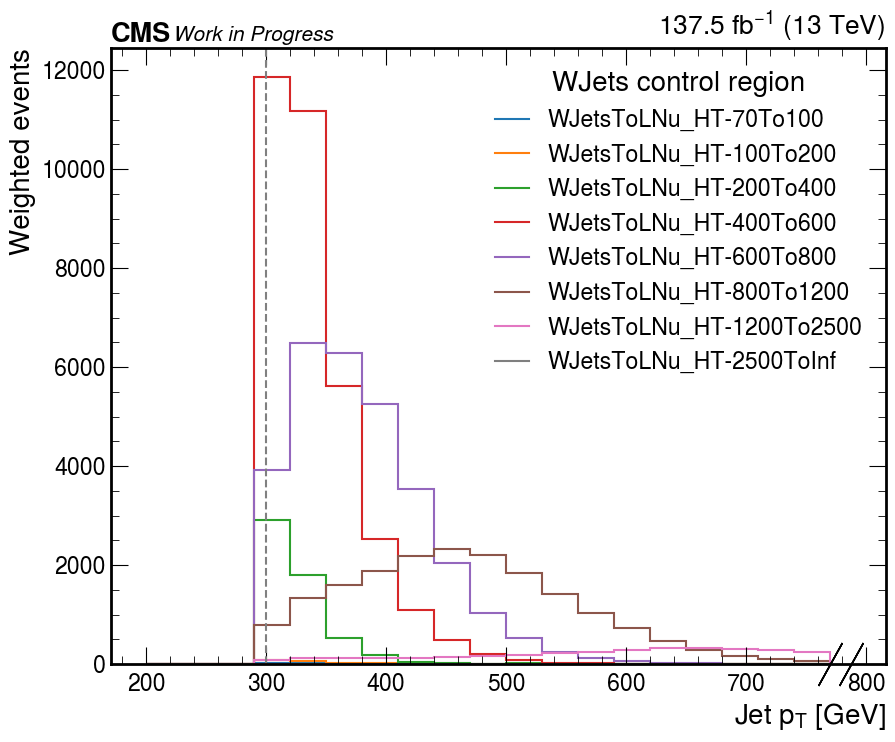

In [182]:
fig, ax = plt.subplots(figsize=(10, 8))
for sample in samples_to_plot:
    hep.histplot(h[{"samples": sample}].project("var"),
        label=sample,
#         density=True,
#         yerr=False,
    )
ax.axvline(300, linestyle="--", color="grey")
ax.legend(title=region, loc="upper right")
ax.set_ylabel("Weighted events")
# ax.set_ylim(0.01, 10e4)
# ax.set_ylim(0, 2500)
# ax.set_yscale("log")

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku5/wjetscorr.pdf")     

# High qcd weights

In [1855]:
samples_to_plot = list(events_dictqcd["signal_region"]["2017"]["ele"].keys())
samples_to_plot

['QCD_Pt_3200toInf',
 'QCD_Pt_1800to2400',
 'QCD_Pt_2400to3200',
 'QCD_Pt_1000to1400',
 'QCD_Pt_600to800',
 'QCD_Pt_300to470',
 'QCD_Pt_170to300',
 'QCD_Pt_800to1000',
 'QCD_Pt_470to600',
 'QCD_Pt_1400to1800']

In [1856]:
tagger = "fj_ParT_score_finetuned"
presel = {
    "Pre-selection": f"fj_pt>0",       

#     "High purity signal region": f"({tagger}>0.97)",
#     "High purity signal region + MET>X": f"({tagger}>0.97)",
    
#     "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",
#     "Medium purity signal region + MET>X": f"({tagger}<0.97) & ({tagger}>0.85)",
    
#     "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)",   
#     "WJets control region + MET>X": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)",   
    
}

channels = ["ele", "mu"]
years = ["2018", "2017", "2016", "2016APV"]

# fill histograms
hists = {}

# var = "rec_higgs_m"
var = "fj_pt"
# var = "event_weight"
if var=="rec_higgs_m":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Variable(list(range(50, 240, 20)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True)
    )  
elif var == "fj_pt":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Variable(list(range(200, 800, 30)), name="var", label=r"Jet $p_T$ [GeV]", overflow=True)
    )      
else:
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Variable(list(range(0, 500, 20)), name="var", label=r"Event weight", overflow=True)
    )      

for sample in samples_to_plot:
    for year in years:
        for ch in channels:

            region, sel = list(presel.items())[0]

            df = events_dictqcd["signal_region"][year][ch][sample]
            df = df.query(sel)

            if "MET>X" in region:
                if ch=="ele":
                    df = df[df["met_pt"]>70]
                else:
                    df = df[df["met_pt"]>50]

            x = df[var]
            if len(x)==0:
                x = 0   
                
            if var=="event_weight":
                h.fill(
                    samples=sample, var=x,
                )

            else:
                h.fill(
                    samples=sample, var=x, weight=df["nominal"],
                )

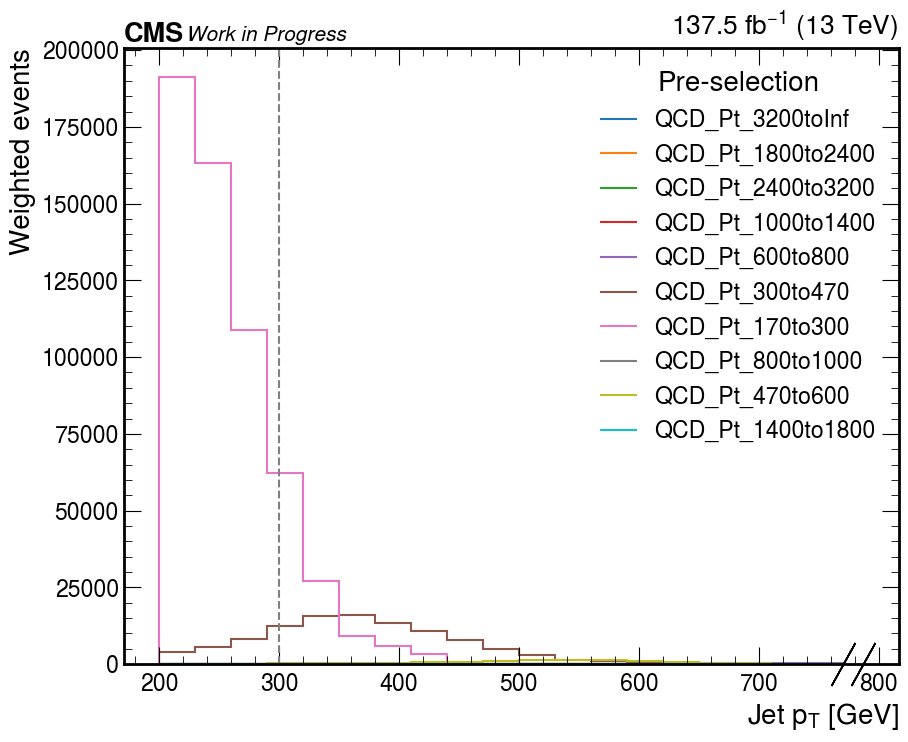

In [1857]:
fig, ax = plt.subplots(figsize=(10, 8))
for sample in samples_to_plot:
    hep.histplot(h[{"samples": sample}].project("var"),
        label=sample,
#         density=True,
#         yerr=False,
    )
ax.axvline(300, linestyle="--", color="grey")
ax.legend(title=region, loc="upper right")
ax.set_ylabel("Weighted events")
# ax.set_ylim(0.01, 10e4)
# ax.set_ylim(0, 2500)
# ax.set_yscale("log")

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku5/qcd_high_weights_wjets_jetpt.pdf")     

# soverb

In [149]:
dominant_backgrounds = ["WJetsLNu", "TTbar", "QCD", "DYJets"]

In [150]:
samples

['ggF',
 'VH',
 'VBF',
 'ttH',
 'QCD',
 'DYJets',
 'WJetsLNu',
 'WZQQ',
 'TTbar',
 'SingleTop',
 'Diboson',
 'Data']

In [333]:
# tagger = "ParT_finetuned"
tagger = "fj_ParT_score_finetuned"

presel = {
#     "High purity signal region": f"({tagger}>0.97)",
#     "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",
    
#     "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)", 
    "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20)", 

#     "WJets control region + dR>0.2": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0) & (lep_fj_dr>0.2)",    

#     "Top control region": f"({tagger}<0.2) & (n_bjets_T>0)",  
#     "Top control region + dR>0.1": f"({tagger}<0.20) & (n_bjets_T>0) & (lep_fj_dr>0.1)",      

#     "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  
#     "Lep iso": f"fj_pt>0",
}

categories_sel = {
#     "VBF_pt200toinf": "( (mjj>1000) & (deta>3.5) )",
#     "ggF_pt200to300": "( (mjj<1000) | (deta<3.5) ) & (fj_pt<300)",    
#     "ggF_pt300toinf": "( (mjj<1000) | (deta<3.5) ) & (fj_pt>300)",
    
}

mass_window = [80, 160]

years = ["2018", "2017", "2016APV", "2016"]
channels = ["ele", "mu"]

num_sig = {
    "ggF": 0, 
    "ttH": 0, 
    "VH": 0,
    "VBF": 0,
}
num_bkg = {
    "WJetsLNu": 0, 
    "TTbar": 0, 
    "QCD": 0,
    "DYJets": 0,
    "Others": 0,
}

deno_sig, deno_bkg = 0, 0
s, b = 0, 0

for year in years:
    for ch in channels:
        for sample in samples:
            if sample=="Data":
                continue

            for k, v in presel.items():
                if "QCD" in k:
                    df = events_dict["qcd_region"][year][ch][sample]
                else:
                    df = events_dict["signal_region"][year][ch][sample]

                df = df.query(v)  
                
#                 if "High" in k:
#                     if sample == "QCD":
#                         df = df[df["nominal"]<140]
#                 if "Medium" in k:
#                     if sample == "QCD":
#                         df = df[df["nominal"]<200]
            
#             for category, category_sel in categories_sel.items():
#                 df = df.query(category_sel)            
            
#             if sample == "QCD":
#                 df = df[df["nominal"]<50]
                
#             if ch=="ele":
#                 df = df[df["met_pt"]>70]
#             else:
#                 df = df[df["met_pt"]>50]
                
#             df = df[df["n_bjets_L"]==0]
#             df = df[df["lep_fj_dr"]>0.2]
            df = df[df["lep_met_mt"]>40]
    
#             df = df[(df["fj_pt"]/df["lep_pt"])<3]

#             df = df[np.abs(df["met_fj_dphi"])<2.5]

#             df = df[df["fj_ParT_mass"]<50]

#             df = df[df["fj_pt"]>250]
            ######################## composition start
            if sample in utils.signals:
                
                deno_sig += df["nominal"].sum()
                num_sig[sample] += df["nominal"].sum()
            else:
                deno_bkg += df["nominal"].sum()
                
                if sample in dominant_backgrounds:
                    num_bkg[sample] += df["nominal"].sum()
                else:
                    num_bkg["Others"] += df["nominal"].sum()     
            ######################## composition end
            
            ######################## soverb start
            df = df[(df["rec_higgs_m"]>=mass_window[0]) & (df["rec_higgs_m"]<=mass_window[1])]
    
            if sample in utils.signals:                
                s += df["nominal"].sum()
            else:
                b += df["nominal"].sum()
            ######################## soverb end

In [334]:
num_sig = dict(sorted(num_sig.items(), key=lambda item: item[1]))
num_bkg = dict(sorted(num_bkg.items(), key=lambda item: item[1]))

if len(years) == 4:
    lab = "Run2"
else:
    lab = "_".join(years)

print("\033[1m" + f"{list(presel.keys())[0]} ({lab}):" + '\033[0m')
# print("Category:", category)

print("------------------------")

if "purity" in list(presel.keys())[0]:
    print("\033[1m" + rf"s/sqrt(b) in [{mass_window[0]},{mass_window[1]}]: {s/math.sqrt(b):.2f}" + '\033[0m')
    print("------------------------")

print(f"Signal: {deno_sig:.2f}")
for sample in num_sig:
    print(f"- {sample}: {100*(num_sig[sample]/deno_sig):.0f}%")
    
print("------------------------")
print(f"Background: {deno_bkg:.2f}")
for sample in num_bkg:
    if sample=="":
        print("\033[1m" + f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%")
    else:
        print(f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%") 

WJets control region (Run2):
------------------------
Signal: 475.17
- ttH: 16%
- VH: 17%
- VBF: 20%
- ggF: 47%
------------------------
Background: 497404.16
- Others: 2%
- QCD: 5%
- DYJets: 15%
- TTbar: 18%
- WJetsLNu: 59%


In [587]:
(0.74**2 + 0.81**2 + 0.59**2)**0.5   # VBF / ggF200-300 / ggF300-450 / ggF450-inf

1.2457126474432216

# WJetsLNu region

In [455]:
tagger = "fj_ParT_score_finetuned_v2_nor2"

# mass_window = [50, 200]

years = ["2018", "2017"]
# years = ["2017"]
channels = ["ele", "mu"]

num_sig = {
    "ggF": 0, 
    "ttH": 0, 
    "VH": 0,
    "VBF": 0,
}
num_bkg = {
    "WJetsLNu": 0, 
    "TTbar": 0, 
    "QCD": 0,
    "Others": 0,
}
deno_sig, deno_bkg = 0, 0

# tagger_cuts = [0.01, 0.02, 0.03, 0.04, 0.07, 0.09, 0.1, 0.2, 0.8]
# tagger_cuts = np.linspace(0.01, 0.8, 21)
tagger_cuts = np.linspace(0.01, 0.3, 21)
ttt = []
for tagger_cut in tagger_cuts:
    for year in years:
        for ch in channels:
            for sample in samples:
                if sample=="Data":
                    continue

                df = events_dict[year][ch][sample]

    #             df = df[(df["rec_higgs_m"]>mass_window[0]) & (df["rec_higgs_m"]<mass_window[1])]

                df = df[df["event_weight"]<140]
                df = df[df[tagger]<0.85]
                df = df[df[tagger]>tagger_cut]
                df = df[df["n_bjets_L"]==0]                


                if sample in utils.signals:
                    deno_sig += df["event_weight"].sum()
                    num_sig[sample] += df["event_weight"].sum()
                else:
                    deno_bkg += df["event_weight"].sum()
                    if sample in dominant_backgrounds:
                        num_bkg[sample] += df["event_weight"].sum()
                    else:
                        num_bkg["Others"] += df["event_weight"].sum()
                        
    ttt.append(100*(num_bkg["WJetsLNu"]/deno_bkg))  

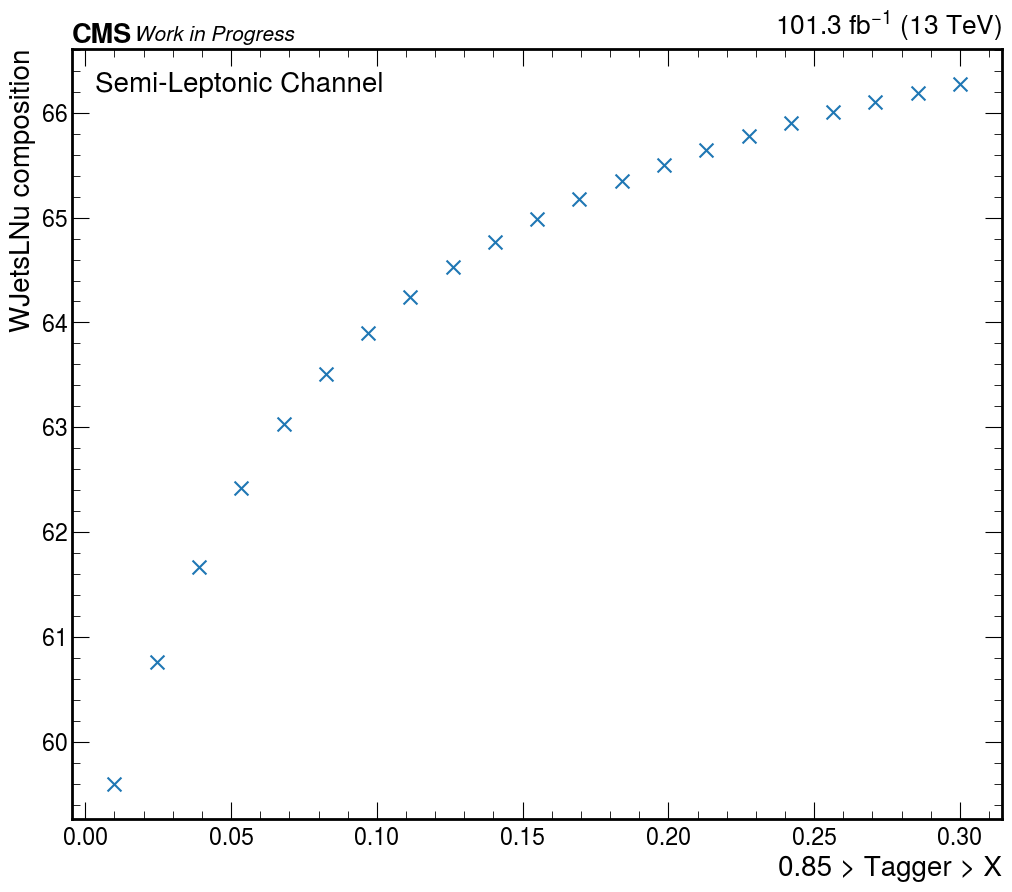

In [456]:
years = ["2018", "2017"]
fig, ax = plt.subplots(figsize=(12, 10))
ax.scatter(tagger_cuts, ttt, marker="x", s=100)

# ax.axvline(0.85, color="grey", linestyle="--")#, label=rf"125 GeV")

# ax.set_ylim(0, 1.4)
ax.legend(title=f"Semi-Leptonic Channel")
ax.set_ylabel(r"WJetsLNu composition");
ax.set_xlabel(r"0.85 > Tagger > X")
# ax.set_xlabel(rf"{wp} > Tagger > X")
# ax.set_xticks(tagger_cuts)
# ax.set_xticks([0.9, 0.92, 0.94, 0.96, 0.97, 0.98])

lum_ = 0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku/soverb_W_region4.pdf")  

# Sculpting

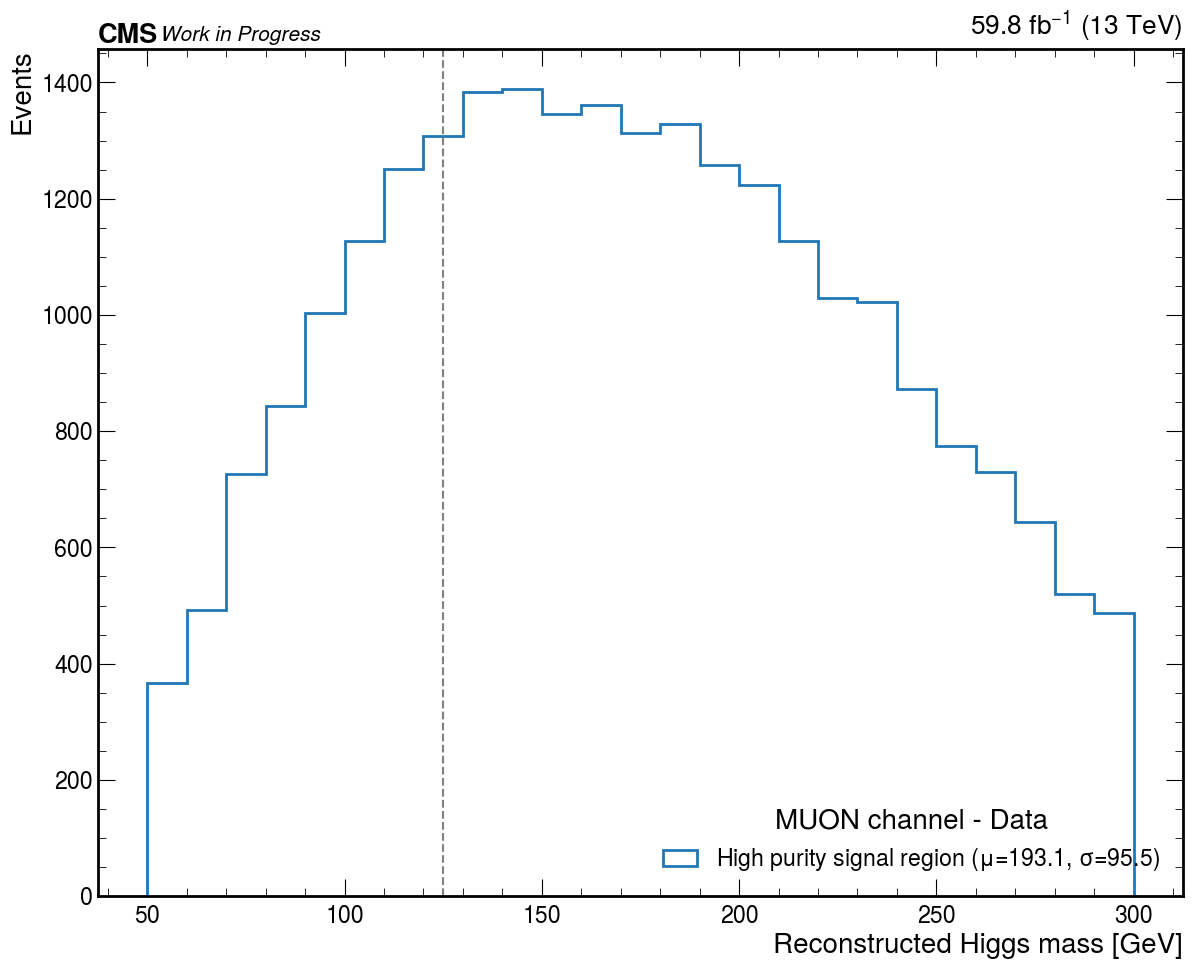

In [531]:
plt.rcParams.update({"font.size": 20})

# tagger = "fj_ParT_score_finetuned_v2_10_12"
tagger = "fj_ParT_score"
# tagger = "fj_ParT_score_finetuned"
presel = {
    "High purity signal region": f"({tagger}>0.97)",
#     "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",    
#     "Low purity signal region": f"({tagger}<0.85) & ({tagger}>0.20)",   
    
#     "Top control region": f"({tagger}<0.30) & (n_bjets_T>0)",  

#     "Top control region + dR>0.1": f"({tagger}<0.3) & (n_bjets_T>0) & (lep_fj_dr>0.1)",
#     "Top control region + dR>0.2": f"({tagger}<0.3) & (n_bjets_T>0) & (lep_fj_dr>0.2)",
#     "Top control region + dR>0.3": f"({tagger}<0.3) & (n_bjets_T>0) & (lep_fj_dr>0.3)",
#     "Top control region + dR>0.4": f"({tagger}<0.9) & (n_bjets_T>0) & (lep_fj_dr>0.4)",
    
#     "WJets control region": f"({tagger}<0.80) & ({tagger}>0.20) & (n_bjets_L==0)",

#     "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  
    
#     "ParT-finetuned>0.97": f"(fj_ParT_score_finetuned_v2_nor2>0.97)",
#     "ParT>0.99": f"(fj_ParT_score>0.99)"
    
    
}

nice_ch = {
    "ele": "ELECTRON",
    "mu": "MUON",
}

sample = "Data"
channels = ["mu"]#, "ele"]
years = ["2018"]#, "2017"]

fig, ax = plt.subplots(figsize=(14, 11))
for k, v in presel.items():
    
    for year in years:

        if "QCD" in k:
            region="qcd_region"
        else:
            region="signal_region"

        df1 = events_dict[region][year]["mu"][sample]    
        df2 = events_dict[region][year]["ele"][sample]

        df = pd.concat([df1, df2])

        if len(years) > 1:
            df1 = events_dict[region][years[1]]["mu"][sample]    
            df2 = events_dict[region][years[1]]["ele"][sample]

            df11 = pd.concat([df1, df2])

            df = pd.concat([df, df11])
            break
            
    bins = 26

    df1 = df.copy().query(v)

    x = df1["rec_higgs_m"]
#     w = df1["event_weight"]

    ax.hist(
        x, 
        bins=np.linspace(50,300,bins), 
#         weights=w,
#         density=True, 
        histtype="step", 
        linewidth=2, 
        label=rf"{k} ($\mu$={np.mean(x):.1f}, $\sigma$={np.std(x):.1f})"
    )

ax.axvline(125, color="grey", linestyle="--")#, label=rf"125 GeV")

if len(channels) > 1:
    ax.legend(title=f"{sample}")    
else:
    ax.legend(title=f"{nice_ch[ch]} channel - {sample}")


ax.set_ylabel("Events")
ax.set_xlabel(f"Reconstructed Higgs mass [GeV]")
ax.set_ylim(0)

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku/mass_sculpting_{sample}.pdf")        

In [514]:
all_files = glob.glob("ttt/*")
log_files = glob.glob("ttt/log*")

In [505]:
all_files

['ttt/t', 'ttt/log.txt', 'ttt/a.txt']

In [506]:
log_files

['ttt/log.txt']

# Data

In [803]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [804]:
################### option 2
def blindBins(h, blind_region, blind_samples=[]):
    """
    Blind (i.e. zero) bins in histogram ``h``.
    If ``blind_samples`` specified, only blind those samples, else blinds all.

    CAREFUL: assumes axis=0 is samples, axis=3 is mass_axis

    """

    h = h.copy()

    massbins = h.axes["mass_observable"].edges

    lv = int(np.searchsorted(massbins, blind_region[0], "right"))
    rv = int(np.searchsorted(massbins, blind_region[1], "left") + 1)

    if blind_samples:
        for blind_sample in blind_samples:
            sample_index = np.argmax(np.array(list(h.axes[0])) == blind_sample)
            h.view(flow=True)[sample_index, :, :, lv:rv] = 0

    else:
        h.view(flow=True)[:, :, :, lv:rv] = 0

    return h

plt.rcParams.update({"font.size": 20})

# tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

regions_sel = {
#     "Pre-selection": f"{tagger}>0.5",    
    "SR1 (tagger>0.97 + nbjetsT==0)": f"({tagger}>0.97) & (n_bjets_T==0)",
#     "SR2 (0.97>tagger>0.85 + nbjetsT==0)": f"({tagger}<0.97) & ({tagger}>0.85) & (n_bjets_T==0)",
#     "WJets CR (0.85>tagger>0.50 + nbjetsT==0)": f"({tagger}<0.85) & ({tagger}>0.50) & (n_bjets_T==0)",    
#     "Top CR (tagger>0.85 + nbjetsT>0)": f"({tagger}>0.85) & (n_bjets_T>0)", 
    
}

categories_sel = {
    "VBF category": "(mjj>1000) & (deta>3.5)",
#     rf"ggF category ($p_T$ $\in$ [200, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>200) & (fj_pt<450)",
    rf"ggF category ($p_T$ $\in$ [300, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>300)",
}

samples = ["Data", "ggF", "VBF"]
channels = ["ele", "mu"]
# channels = ["mu"]
blind = True
blind_region = (90, 160)

years = ["2018", "2017", "2016", "2016APV"]
lum = 0
for year in years:
    lum += luminosity[ch][year] / 1000.0
    

# fill histograms
hists = hist2.Hist(
    hist2.axis.StrCategory([], name="samples", growth=True),            
    hist2.axis.StrCategory([], name="regions", growth=True),
    hist2.axis.StrCategory([], name="categories", growth=True),    
    hist2.axis.Variable(
        list(range(50, 240, 20)), name="mass_observable", label=r"Higgs reconstructed mass [GeV]", overflow=True
    ),
)        

mult = {
    "SR1 (tagger>0.97 + nbjetsT==0)": 10,
#     "SR2 (0.97>tagger>0.85 + nbjetsT==0)": 100,
}

for sample in samples:
    for year in years:
        for ch in channels:
            df = ev[year][ch][sample]
            for region, region_sel in regions_sel.items():
                for category, category_sel in categories_sel.items():
                    df1 = df.copy().query(region_sel)
                    df1 = df1.query(category_sel)

                    if ((sample=="ggF") or (sample=="VBF")):
                        df1["event_weight"]=df1["event_weight"]*mult[region]

                    hists.fill(
                        samples=sample,
                        regions=region,
                        categories=category,
                        mass_observable=df1["rec_higgs_m"],
                        weight=df1["event_weight"],
                    )

INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral


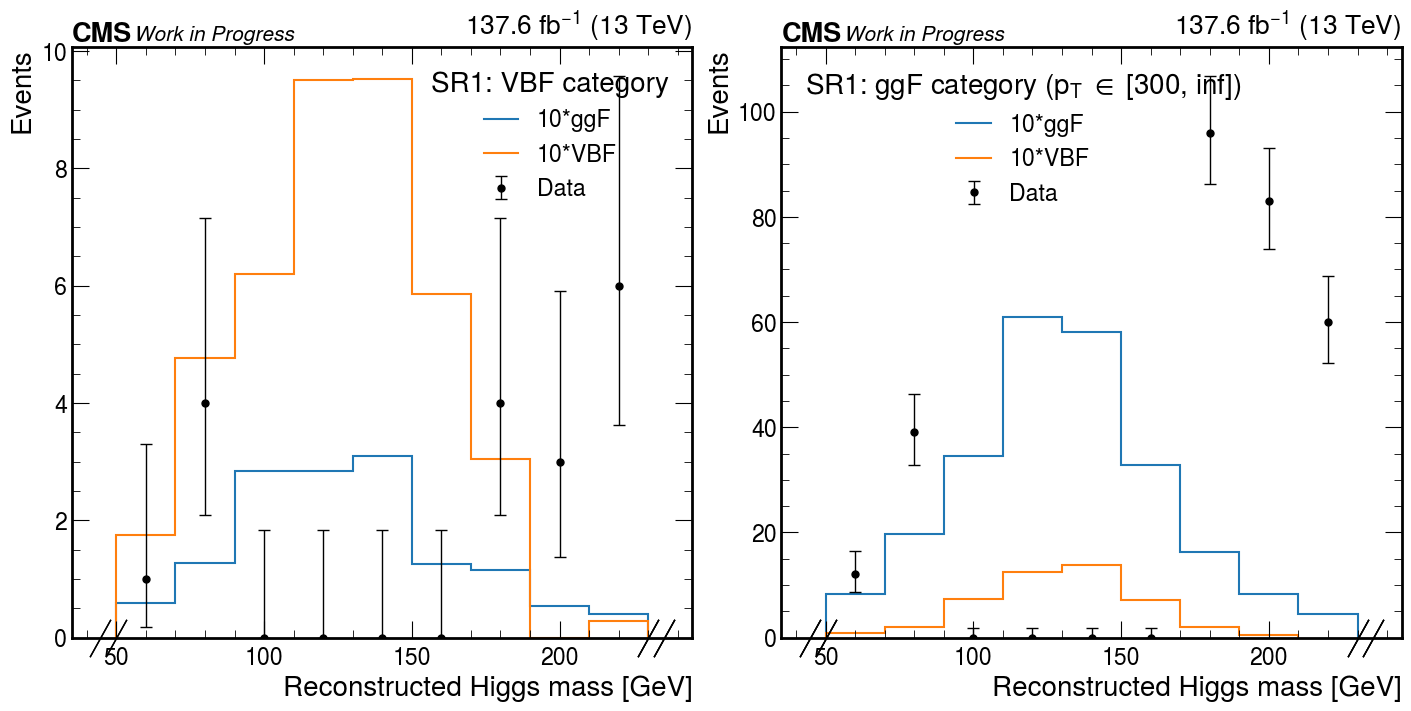

In [805]:
fig, axs = plt.subplots(1, 2, figsize=(14,7), constrained_layout=True)

region = list(regions_sel.items())[0][0]
for i, category in enumerate(categories_sel):
    for sample in samples:
        
        
        if sample == "Data":
            if blind:
                hists = blindBins(hists, (blind_region[0],blind_region[1]), blind_samples=["Data"])
            
            hep.histplot(
                hists[{"samples": sample, "regions": region, "categories": category}],
                ax=axs[i],
                label=sample,
                histtype="errorbar",
                color="k",
                capsize=4,           
            )   
            
        else:
            if mult[region]==1:
                lab = sample            
            else:
                lab = f"{mult[region]}*{sample}"
            
            hep.histplot(
                hists[{"samples": sample, "regions": region, "categories": category}],
                ax=axs[i],
                histtype="step",
                label=lab,
            )    
                

    axs[i].legend(title=f"SR1: {category}")
    axs[i].set_ylabel(f"Events")
    axs[i].set_xlabel(f"Reconstructed Higgs mass [GeV]")
    axs[i].set_ylim(0)    
    hep.cms.lumitext("%.1f " % lum + r"fb$^{-1}$ (13 TeV)", ax=axs[i], fontsize=20)
    hep.cms.text("Work in Progress", ax=axs[i], fontsize=15)
#     if i==2:
#         axs[i].set_yticks([0,4,8,12,16])
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku5/ww3.pdf")

In [1099]:
################### option 2
def blindBins(h, blind_region, blind_samples=[]):
    """
    Blind (i.e. zero) bins in histogram ``h``.
    If ``blind_samples`` specified, only blind those samples, else blinds all.

    CAREFUL: assumes axis=0 is samples, axis=3 is mass_axis

    """

    h = h.copy()

    massbins = h.axes["mass_observable"].edges

    lv = int(np.searchsorted(massbins, blind_region[0], "right"))
    rv = int(np.searchsorted(massbins, blind_region[1], "left") + 1)

    if blind_samples:
        for blind_sample in blind_samples:
            sample_index = np.argmax(np.array(list(h.axes[0])) == blind_sample)
            h.view(flow=True)[sample_index, :, :, lv:rv] = 0

    else:
        h.view(flow=True)[:, :, :, lv:rv] = 0

    return h

plt.rcParams.update({"font.size": 20})

# tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

regions_sel = {
#     "Pre-selection": f"{tagger}>0.5",    
    "SR1": f"({tagger}>0.98) & (n_bjets_T==0)",
#     "SR2": f"({tagger}>0.97) & ({tagger}<0.98) & (n_bjets_T==0)",

    
#     "SR1 (tagger>0.97 + nbjetsT==0)": f"({tagger}>0.97) & (n_bjets_T==0)",
#     "SR2 (0.97>tagger>0.85 + nbjetsT==0)": f"({tagger}<0.97) & ({tagger}>0.85) & (n_bjets_T==0)",
#     "WJets CR (0.85>tagger>0.50 + nbjetsT==0)": f"({tagger}<0.85) & ({tagger}>0.50) & (n_bjets_T==0)",    
#     "Top CR (tagger>0.85 + nbjetsT>0)": f"({tagger}>0.85) & (n_bjets_T>0)", 
    
}

categories_sel = {
    "VBF category": "(mjj>1000) & (deta>3.5)",
    rf"ggF category ($p_T$ $\in$ [300, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>300) & (fj_pt<450)",
    rf"ggF category ($p_T$ $\in$ [450, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>450)",
    
#     rf"ggF category ($p_T$ $\in$ [300, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>300) & (fj_pt<450)",
#     rf"ggF category ($p_T$ $\in$ [450, 650])": "(mjj<1000) & (deta<3.5) & (fj_pt>450) & (fj_pt<650)",
#     rf"ggF category ($p_T$ $\in$ [650, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>650)",        
}

samples = ["Data", "ggF", "VBF"]
channels = ["ele", "mu"]
blind = True
blind_region = (90, 160)

years = ["2018", "2017", "2016", "2016APV"]
lum = 0
for year in years:
    lum += luminosity[ch][year] / 1000.0
    

# fill histograms
hists = hist2.Hist(
    hist2.axis.StrCategory([], name="samples", growth=True),            
    hist2.axis.StrCategory([], name="regions", growth=True),
    hist2.axis.StrCategory([], name="categories", growth=True),    
    hist2.axis.Variable(
        list(range(50, 240, 20)), name="mass_observable", label=r"Higgs reconstructed mass [GeV]", overflow=True
    ),
)        

mult = {
    "SR1": 10,
    "SR2": 100,
}

for sample in samples:
    for year in years:
        for ch in channels:
            df = ev[year][ch][sample]
            for region, region_sel in regions_sel.items():
                for category, category_sel in categories_sel.items():
                    df1 = df.copy().query(region_sel)
                    df1 = df1.query(category_sel)

                    if ((sample=="ggF") or (sample=="VBF")):
                        df1["event_weight"]=df1["event_weight"]*mult[region]

                    hists.fill(
                        samples=sample,
                        regions=region,
                        categories=category,
                        mass_observable=df1["rec_higgs_m"],
                        weight=df1["event_weight"],
                    )

INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral


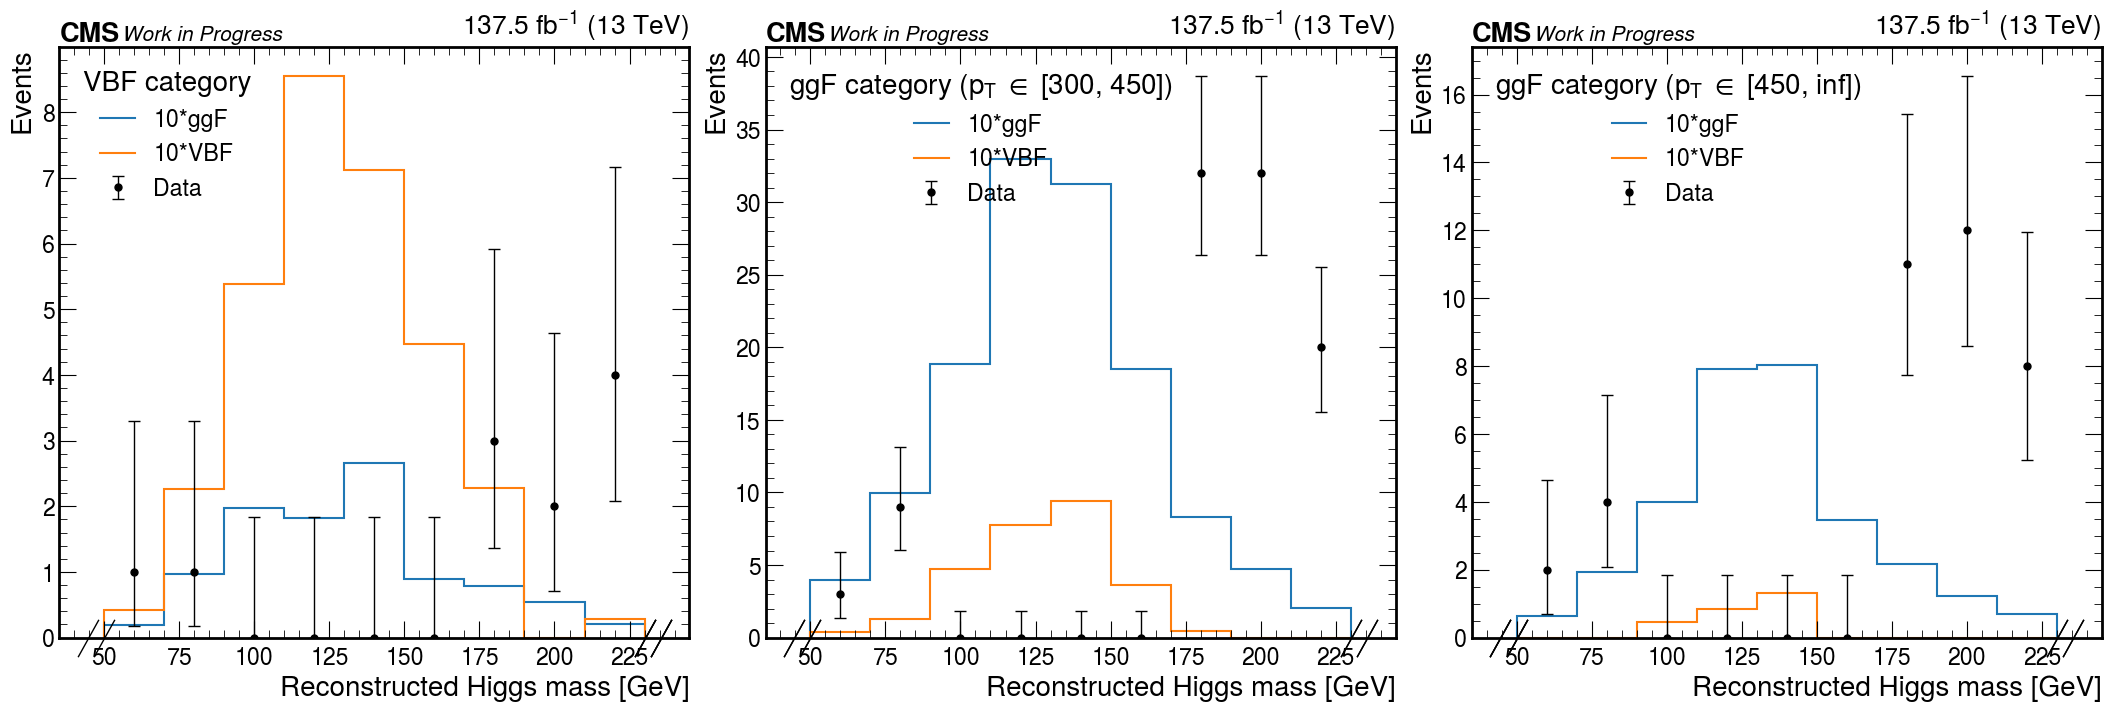

In [1100]:
fig, axs = plt.subplots(1, 3, figsize=(21,7), constrained_layout=True)

region = list(regions_sel.items())[0][0]
for i, category in enumerate(categories_sel):
    for sample in samples:
        
        
        if sample == "Data":
            if blind:
                hists = blindBins(hists, (blind_region[0],blind_region[1]), blind_samples=["Data"])
            
            hep.histplot(
                hists[{"samples": sample, "regions": region, "categories": category}],
                ax=axs[i],
                label=sample,
                histtype="errorbar",
                color="k",
                capsize=4,           
            )   
            
        else:
            if mult[region]==1:
                lab = sample            
            else:
                lab = f"{mult[region]}*{sample}"
            
            hep.histplot(
                hists[{"samples": sample, "regions": region, "categories": category}],
                ax=axs[i],
                histtype="step",
                label=lab,
            )    
            
    axs[i].legend(title=category)
    axs[i].set_ylabel(f"Events")
    axs[i].set_xlabel(f"Reconstructed Higgs mass [GeV]")
    axs[i].set_ylim(0)    
    hep.cms.lumitext("%.1f " % lum + r"fb$^{-1}$ (13 TeV)", ax=axs[i], fontsize=20)
    hep.cms.text("Work in Progress", ax=axs[i], fontsize=15)
#     if i==2:
#         axs[i].set_yticks([0,4,8,12,16])
plt.savefig(f"/Users/fmokhtar/Desktop/AN/ww2.pdf")

In [25]:
################### option 2
def blindBins(h, blind_region, blind_samples=[]):
    """
    Blind (i.e. zero) bins in histogram ``h``.
    If ``blind_samples`` specified, only blind those samples, else blinds all.

    CAREFUL: assumes axis=0 is samples, axis=3 is mass_axis

    """

    h = h.copy()

    massbins = h.axes["mass_observable"].edges

    lv = int(np.searchsorted(massbins, blind_region[0], "right"))
    rv = int(np.searchsorted(massbins, blind_region[1], "left") + 1)

    if blind_samples:
        for blind_sample in blind_samples:
            sample_index = np.argmax(np.array(list(h.axes[0])) == blind_sample)
            h.view(flow=True)[sample_index, :, :, lv:rv] = 0

    else:
        h.view(flow=True)[:, :, :, lv:rv] = 0

    return h

plt.rcParams.update({"font.size": 20})

# tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

regions_sel = {
#     "Pre-selection": f"{tagger}>0.5",   
    
    "SR1": f"(n_bjets_T==0)",
    
#     "SR1": f" & (n_bjets_T==0)",
#     "SR2": f"({tagger}>0.97) & ({tagger}<0.98) & (n_bjets_T==0)",

    
#     "SR1 (tagger>0.97 + nbjetsT==0)": f"({tagger}>0.97) & (n_bjets_T==0)",
#     "SR2 (0.97>tagger>0.85 + nbjetsT==0)": f"({tagger}<0.97) & ({tagger}>0.85) & (n_bjets_T==0)",
#     "WJets CR (0.85>tagger>0.50 + nbjetsT==0)": f"({tagger}<0.85) & ({tagger}>0.50) & (n_bjets_T==0)",    
#     "Top CR (tagger>0.85 + nbjetsT>0)": f"({tagger}>0.85) & (n_bjets_T>0)", 
    
}

# categories_sel = {
#     "VBF category": "(mjj>1000) & (deta>3.5)",
#     rf"ggF category ($p_T$ $\in$ [300, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>300) & (fj_pt<450)",
#     rf"ggF category ($p_T$ $\in$ [450, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>450)",
    
# #     rf"ggF category ($p_T$ $\in$ [300, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>300) & (fj_pt<450)",
# #     rf"ggF category ($p_T$ $\in$ [450, 650])": "(mjj<1000) & (deta<3.5) & (fj_pt>450) & (fj_pt<650)",
# #     rf"ggF category ($p_T$ $\in$ [650, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>650)",        
# }

categories_sel = {
    "SR1": {
        "VBF": f"({tagger}>0.97) & (mjj>1000) & (deta>3.5)",
        rf"ggF $p_T$ $\in$ [250, 300]": f"({tagger}>0.98) & (mjj<1000) & (deta<3.5) & (fj_pt>250) & (fj_pt<300)",        
        rf"ggF $p_T$ $\in$ [300, 450]": f"({tagger}>0.98) & (mjj<1000) & (deta<3.5) & (fj_pt>300) & (fj_pt<450)",
        rf"ggF $p_T$ $\in$ [450, Inf]": f"({tagger}>0.98) & (mjj<1000) & (deta<3.5) & (fj_pt>450)",
    },
    
    "SR2": {
    rf"all inclusive": "(mjj<1000) & (deta<3.5)",
    }
}
#     "VBF category": "(mjj>1000) & (deta>3.5)",
#     rf"ggF category ($p_T$ $\in$ [300, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>300) & (fj_pt<450)",
#     rf"ggF category ($p_T$ $\in$ [450, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>450)",
    
#     rf"ggF category ($p_T$ $\in$ [300, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>300) & (fj_pt<450)",
#     rf"ggF category ($p_T$ $\in$ [450, 650])": "(mjj<1000) & (deta<3.5) & (fj_pt>450) & (fj_pt<650)",
#     rf"ggF category ($p_T$ $\in$ [650, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>650)",        


samples = ["Data", "ggF", "VBF"]
channels = ["ele", "mu"]
blind = True
blind_region = (90, 160)

years = ["2018", "2017", "2016", "2016APV"]
lum = 0
for year in years:
    lum += luminosity[ch][year] / 1000.0
    

# fill histograms
hists = hist2.Hist(
    hist2.axis.StrCategory([], name="samples", growth=True),            
    hist2.axis.StrCategory([], name="regions", growth=True),
    hist2.axis.StrCategory([], name="categories", growth=True),    
    hist2.axis.Variable(
        list(range(50, 240, 20)), name="mass_observable", label=r"Higgs reconstructed mass [GeV]", overflow=True
    ),
)        

mult = {
    "SR1": 10,
    "SR2": 10,
}

for sample in samples:
    for year in years:
        for ch in channels:
            df = ev[year][ch][sample]
            for region, region_sel in regions_sel.items():

                for category, category_sel in categories_sel[region].items():
                    df1 = df.copy().query(region_sel)
                    df1 = df1.query(category_sel)

                    if ((sample=="ggF") or (sample=="VBF")):
                        df1["event_weight"]=df1["event_weight"]*mult[region]

                    hists.fill(
                        samples=sample,
                        regions=region,
                        categories=category,
                        mass_observable=df1["rec_higgs_m"],
                        weight=df1["event_weight"],
                    )

INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral


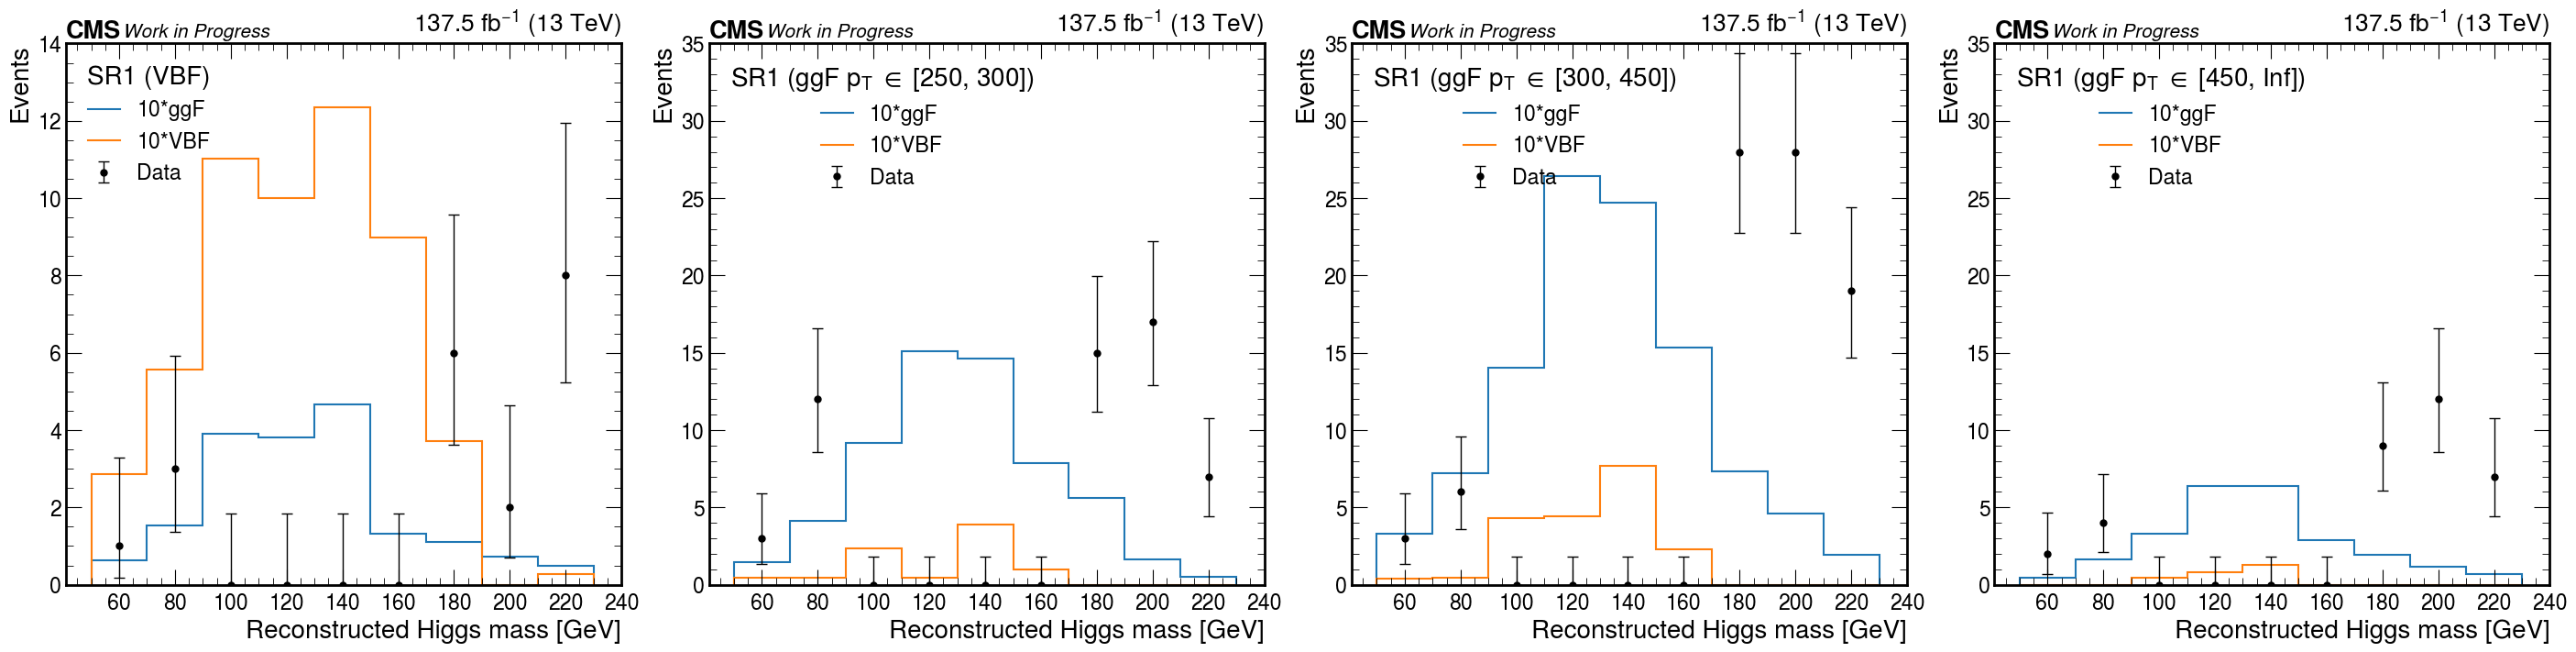

In [31]:
fig, axs = plt.subplots(1, 4, figsize=(28,7), constrained_layout=True)

for region in regions_sel:
    for i, category in enumerate(categories_sel[region]):
        if region=="SR2":
            i=3
        for sample in samples:


            if sample == "Data":
                if blind:
                    hists = blindBins(hists, (blind_region[0],blind_region[1]), blind_samples=["Data"])

                hep.histplot(
                    hists[{"samples": sample, "regions": region, "categories": category}],
                    ax=axs[i],
                    label=sample,
                    histtype="errorbar",
                    color="k",
                    capsize=4,   
                    flow="none"                    
                    
                )   

            else:
                if mult[region]==1:
                    lab = sample            
                else:
                    lab = f"{mult[region]}*{sample}"

                hep.histplot(
                    hists[{"samples": sample, "regions": region, "categories": category}],
                    ax=axs[i],
                    histtype="step",
                    label=lab,
                    flow="none"
                )    
#         if i==3:
#             axs[i].legend(title=f"{region}", loc="upper left")
#         else:
#             axs[i].legend(title=f"{region} ({category})", loc="upper left")

        axs[i].legend(title=f"{region} ({category})", loc="upper left")                

            
        if i==0:
            axs[i].set_ylim(0,14)
        if i==1:
            axs[i].set_ylim(0,35)
        if i==2:
            axs[i].set_ylim(0,35)            
        if i==3:
            axs[i].set_ylim(0,35)
            
            
        axs[i].set_ylabel(f"Events")
        axs[i].set_xlabel(f"Reconstructed Higgs mass [GeV]")
        axs[i].set_ylim(0)    
        hep.cms.lumitext("%.1f " % lum + r"fb$^{-1}$ (13 TeV)", ax=axs[i], fontsize=20)
        hep.cms.text("Work in Progress", ax=axs[i], fontsize=15)
        
        axs[i].set_xticks(np.array(list(range(50, 240, 20))) + 10)
    plt.savefig(f"/Users/fmokhtar/Desktop/AN/ww2.pdf")

# QCD

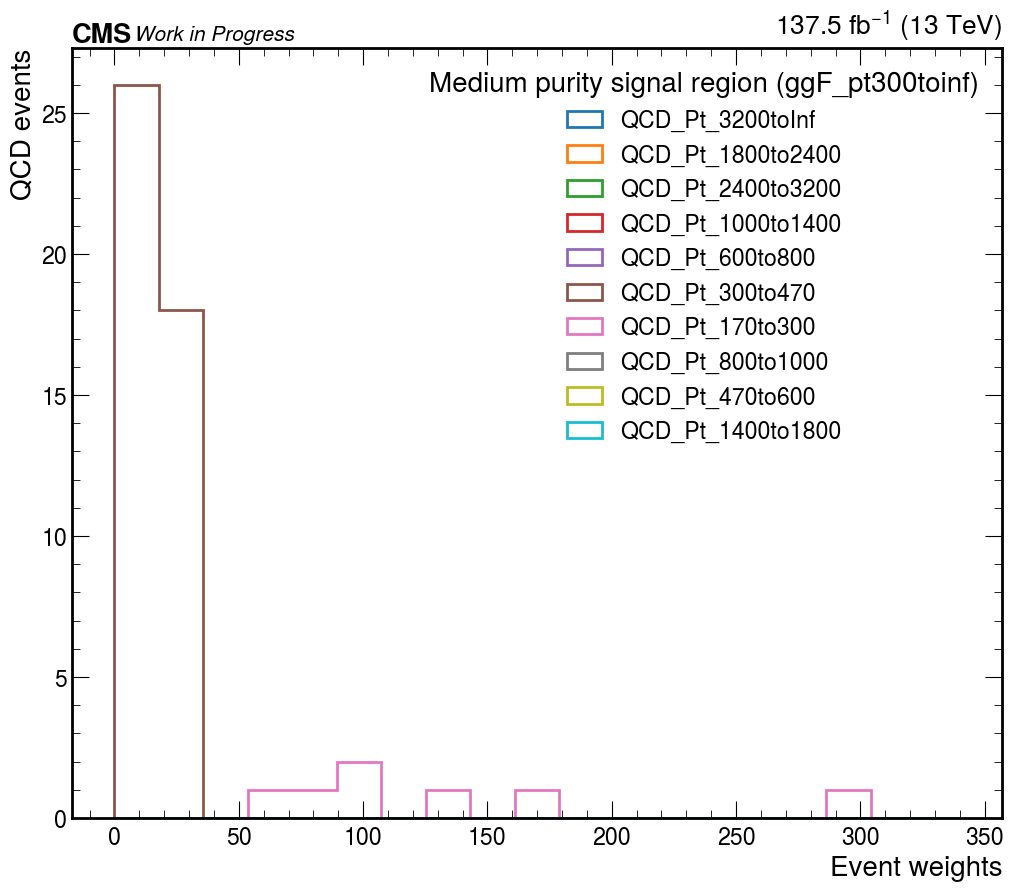

In [573]:
################### option 1
plt.rcParams.update({"font.size": 20})
nice_ch = {
    "ele": "Electron",
    "mu": "Muon",
}

# tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

region_sel = {
#     "High purity signal region": f"({tagger}>0.97)",
    "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",    
#     "Low purity signal region": f"({tagger}<0.85) & ({tagger}>0.20)",   
    
#     "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)",
#     "Top control region": f"({tagger}<0.30) & (n_bjets_T>0)",  
#     "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  
}
categories_sel = {
#     "VBF_pt200toinf": "( (mjj>1000) & (deta>3.5) )",
#     "ggF_pt200to300": "( (mjj<1000) & (deta<3.5) & (fj_pt<300) )",
    "ggF_pt300toinf": "( (mjj<1000) & (deta<3.5) & (fj_pt>300) )",
    
}
blind = True
blind_region = (80, 160)
mult = 10

years = ["2018", "2017", "2016APV", "2016"]
sample="QCD"

fig, ax = plt.subplots(figsize=(12,10))    

ws = {}

for sample in events_dict2["signal_region"]["2017"][ch]:
    ws[sample] = []
    for year in years:
        for ch in ["ele", "mu"]:
            try:
                df = events_dict2["signal_region"][year][ch][sample]
            except:
                continue

            for region, sel in region_sel.items():
                df = df.query(sel)

            for category, category_sel in categories_sel.items():
                df = df.query(category_sel)

            w = df[f"event_weight"]
            ws[sample] += w.tolist() 
    
    ws[sample] = np.array(ws[sample])
    ws[sample] = ws[sample][ws[sample]>10]

    bins = 20
    ax.hist(
        ws[sample],
        bins=np.linspace(0,340,bins), 
        histtype="step", 
        linewidth=2, 
        label=sample
    )
#     break

lum = 0
for year in years:
    lum += luminosity[ch][year] / 1000.0

ax.legend(title=f"{region} ({category})", loc="upper right")

ax.set_ylabel(f"QCD events")
ax.set_xlabel(f"Event weights")  
ax.set_ylim(0)

hep.cms.lumitext("%.1f " % lum + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku2/WWW_QCD_weights_medium_{category}.pdf")        

In [441]:
def plot_ratio(h, years, region1 = "Medium_signal_region", region2 = "QCD_region", sample="QCD", category="VBF", tag=""):
    
    fig, (ax, rax) = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=(10, 10),
        gridspec_kw={"height_ratios": (4, 2), "hspace": 0.07},
        sharex=True,
    )

    hep.histplot(
        h[{"region": region1, "categories": category}],
        ax=ax,
#         histtype="step",
        histtype="errorbar",        
        label=region1,
        density=True
    )
    hep.histplot(
        h[{"region": region2, "categories": category}],
        ax=ax,
        histtype="step",
        label=region2,
        density=True    
    )

    from hist.intervals import ratio_uncertainty

    data_val = h[{"region": region1, "categories": category}].values()
    tot_val = h[{"region": region2, "categories": category}].values()
    yerr = ratio_uncertainty(data_val, tot_val, "poisson")
    

    data_val /= data_val.sum()
    tot_val /= tot_val.sum()

    print(tot_err_MC)
    hep.histplot(
        data_val / tot_val,
        h[{"region": region1, "categories": category}].axes.edges[0],
        yerr=yerr,
        ax=rax,
        histtype="step",
        color="k",
#         capsize=4,
    )
    
    
    
    
    
    ax.set_xlabel("")
    rax.set_xlabel(f"{h.axes[-1].label}")  # assumes the variable to be plotted is at the last axis

    rax.set_ylabel("Ratio", fontsize=20, loc="center")

    
#     rax.set_ylim(0, 0.004)
#     rax.set_yticks([0, 0.4, 1, 1.4])
    
    rax.axhline(1, ls="--", color="k")    
#     rax.set_ylim(0, 2.5)
#     rax.set_yticks([0, 0.4, 1, 1.4])

    ax.legend(title=category)
    
    lum_ = 0
    for year in years:
        lum = 0
        for ch in ["ele", "mu"]:
            with open("../fileset/luminosity.json") as f:
                lum += json.load(f)[ch][year] / 1000.0

        lum_ += lum / len(channels)

    hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)

    hep.cms.text("Work in Progress", ax=ax, fontsize=15)
    
    
    ax.set_ylabel(f"Normalized {sample} events")
    
    if tag:
        plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku3/ratio_{sample}_{tag}.pdf")        
    else:
        plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku3/ratio_{sample}.pdf")   

In [442]:
tagger = "fj_ParT_score_finetuned"
presel = {
    "High purity signal region": f"({tagger}>0.97)",
    "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",
    "Low purity signal region": f"({tagger}<0.85) & ({tagger}>0.20)",
    "0.85>Tagger>0.20": f"({tagger}<0.85) & ({tagger}>0.20)",

#     "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)",   
    
#     "Top control region": f"({tagger}<0.20) & (n_bjets_T>0)",  
    "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  

}

categories_sel = {
    "VBF_pt200toinf": "( (mjj>1000) & (deta>3.5) )",
    "ggF_pt200to300": "( (mjj<1000) & (deta<3.5) & (fj_pt<300) )",
    "ggF_pt300toinf": "( (mjj<1000) & (deta<3.5) & (fj_pt>300) )",
    
}
            
channels = ["ele", "mu"]
years = ["2018", "2017", "2016", "2016APV"]

sample = "QCD"

# fill histograms
hists = {}
for var in vars_to_plot:
            
    if var == "rec_higgs_m":
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="region", growth=True),
            hist2.axis.StrCategory([], name="categories", growth=True),            
            hist2.axis.Variable(
                list(range(50, 240, 20)), name="mass_observable", label=r"Higgs reconstructed mass [GeV]", overflow=True
            )
        )
    else:
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="region", growth=True),
            utils.axis_dict[var],
        )
        
    for year in years:
        for ch in channels:
                
            for region, region_sel in presel.items():
                for category, category_sel in categories_sel.items():
                
                    if "QCD control region" in region:
                        df = events_dict["qcd_region"][year][ch][sample]
                    else:
                        df = events_dict["signal_region"][year][ch][sample]

                    if "High" in region:
                        if sample == "QCD":
                            df = df[df["event_weight"]<140]
                    elif "Medium" in region:
                        if sample == "QCD":
                            df = df[df["event_weight"]<200]

                    df = df.query(region_sel)
                    df = df.query(category_sel)

                    hists[var].fill(
                        region=region,
                        categories=category,
                        mass_observable=df[var],
                        weight=df["event_weight"],
                    )     

KeyError: 'signal_region'

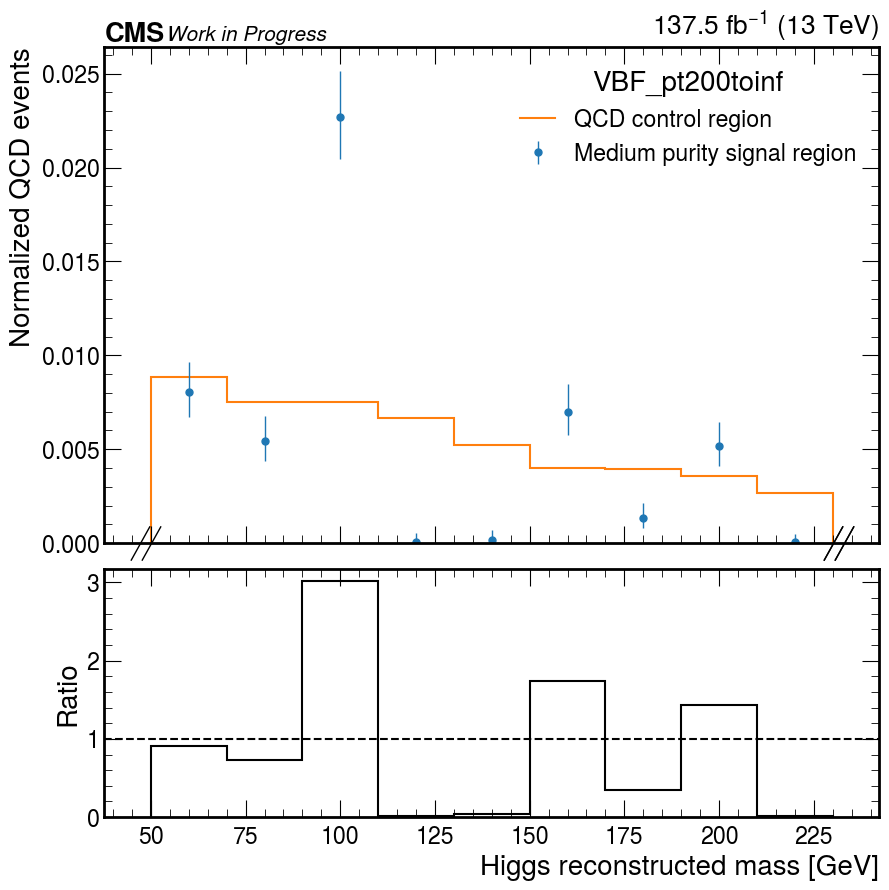

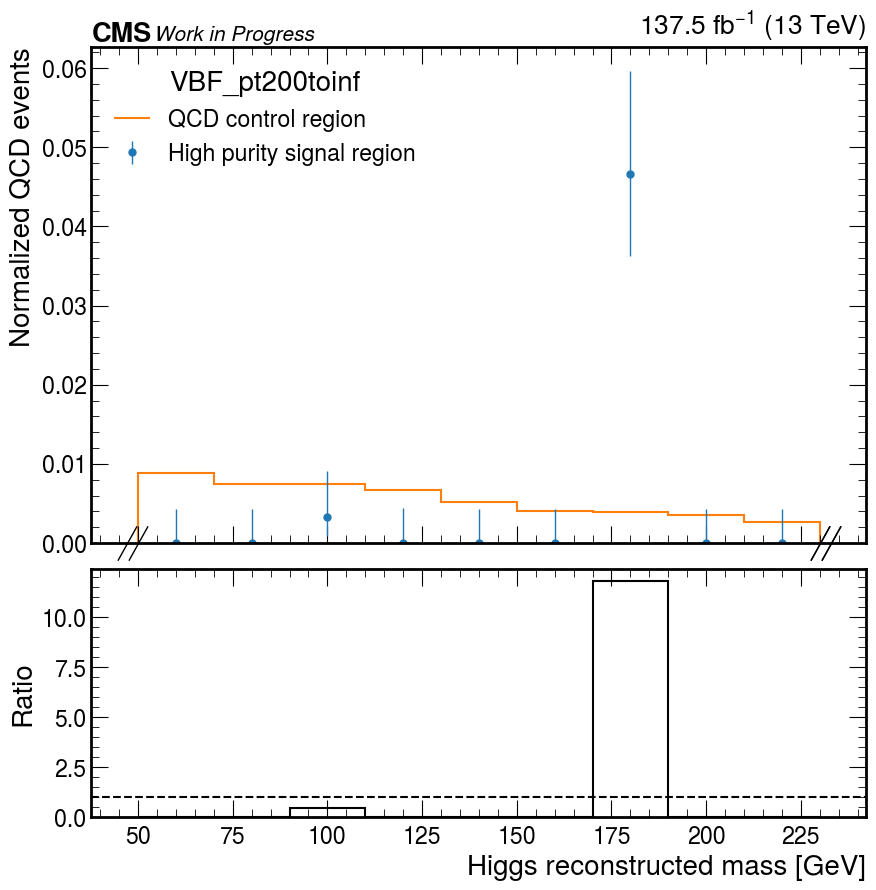

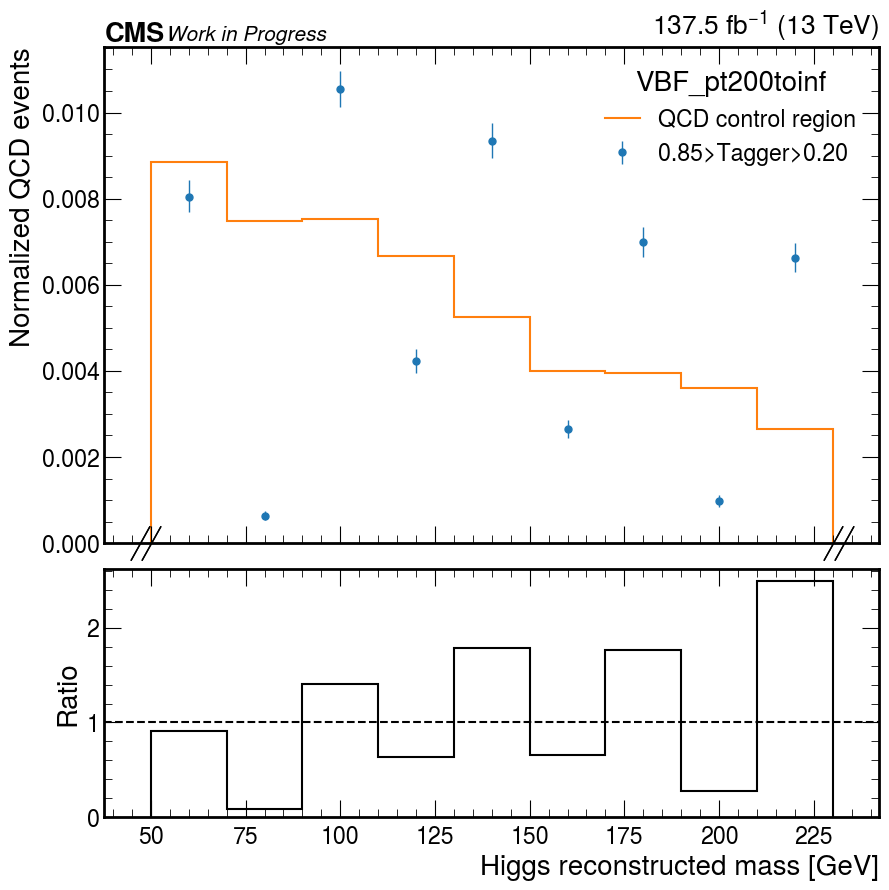

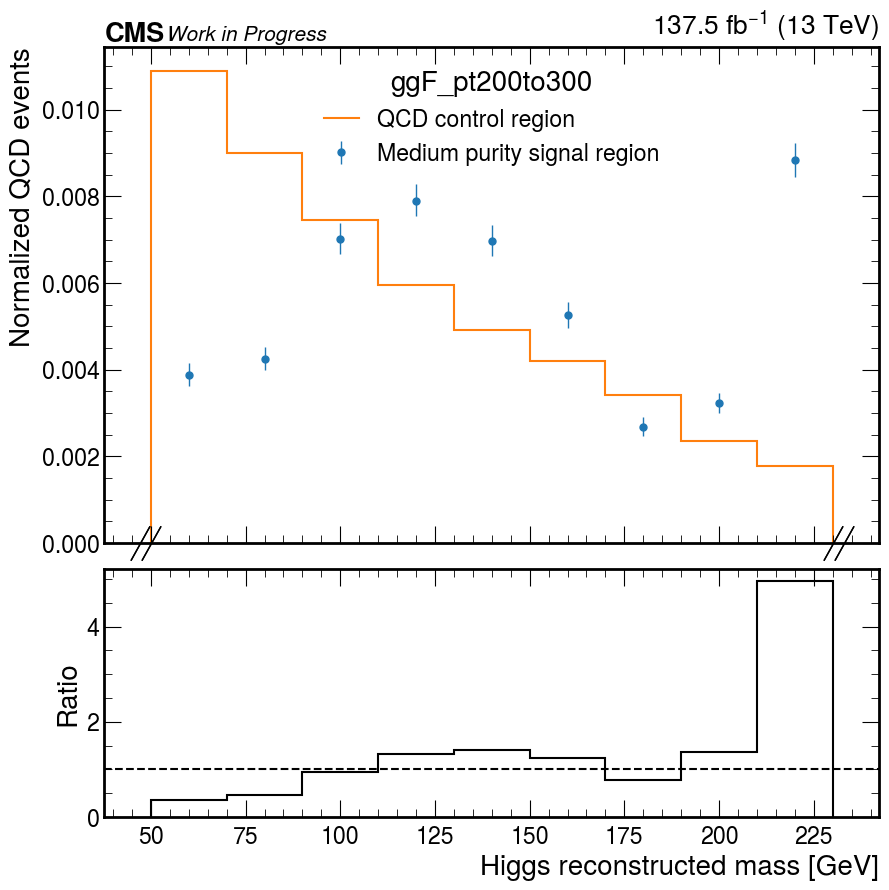

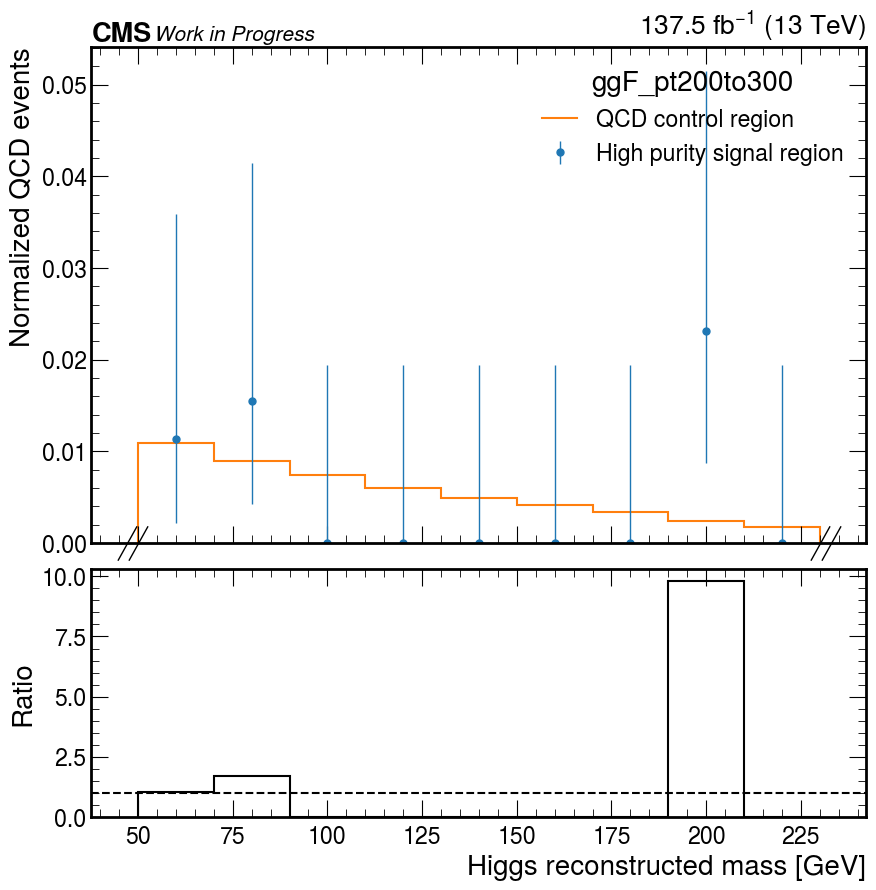

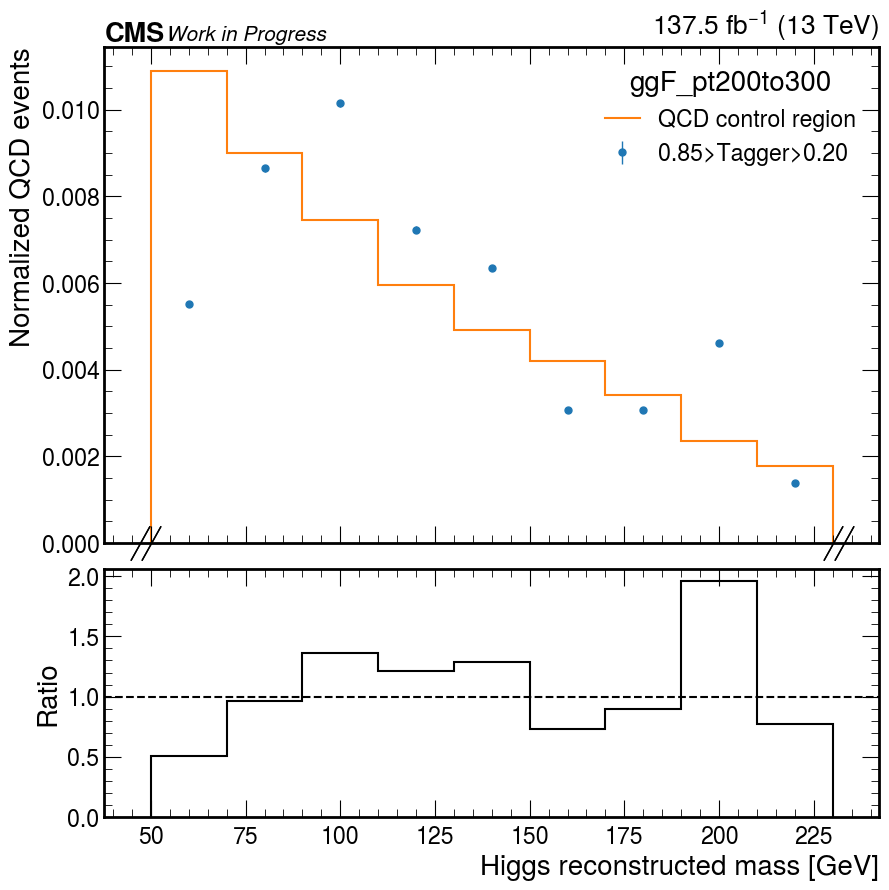

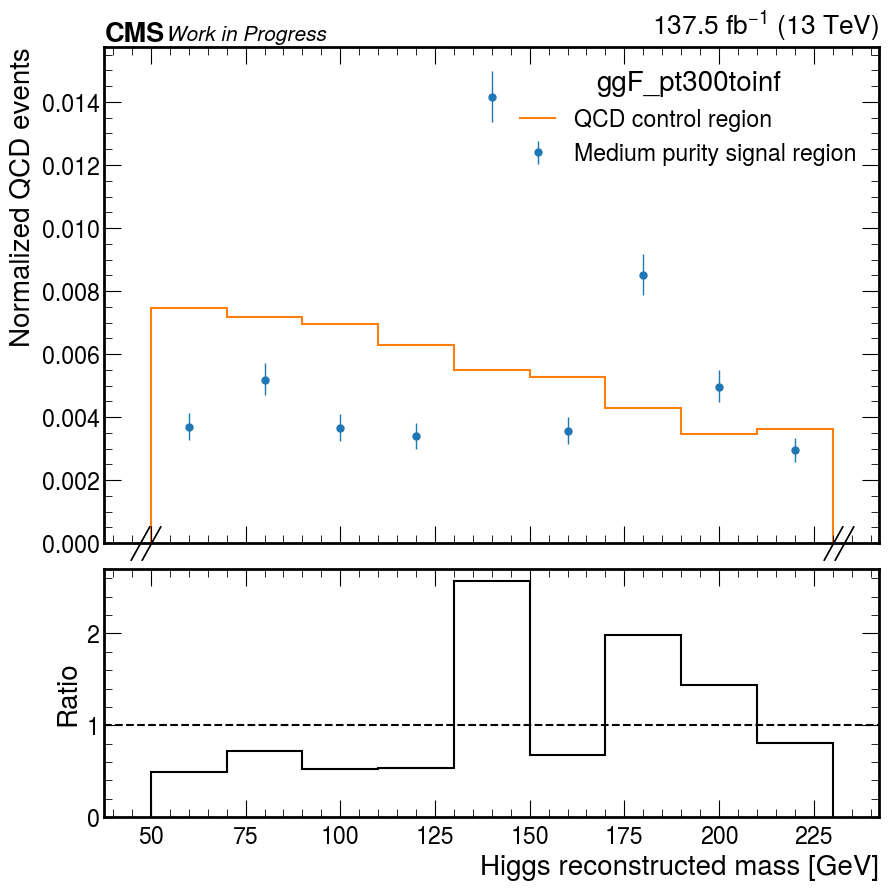

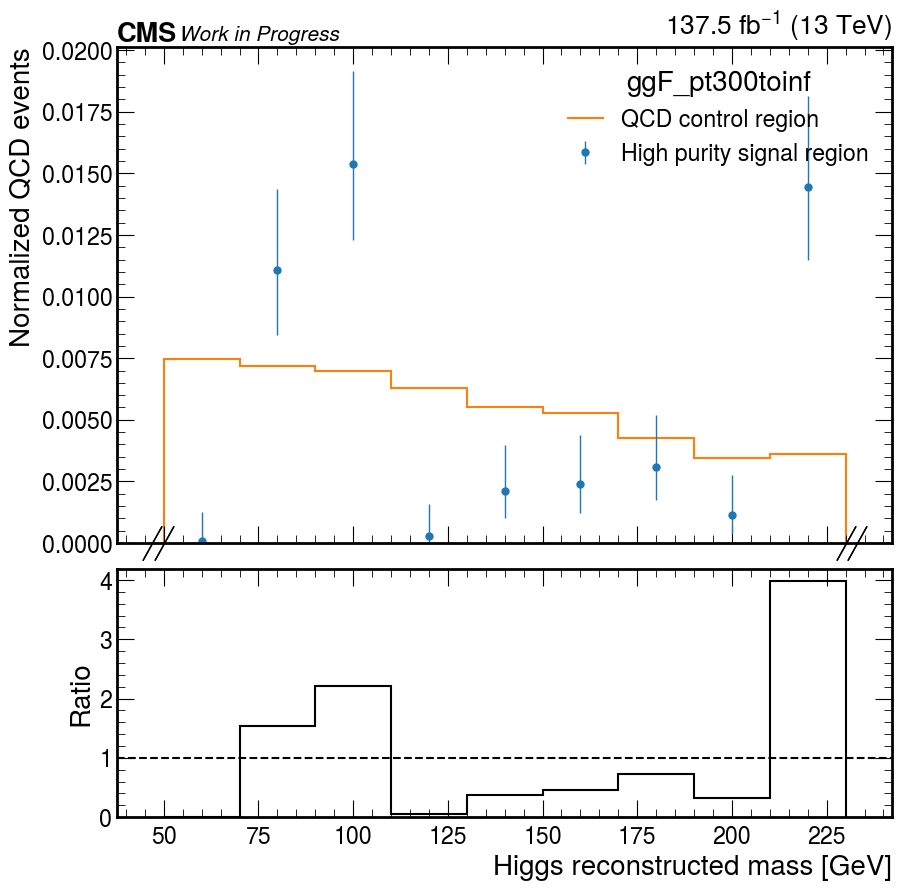

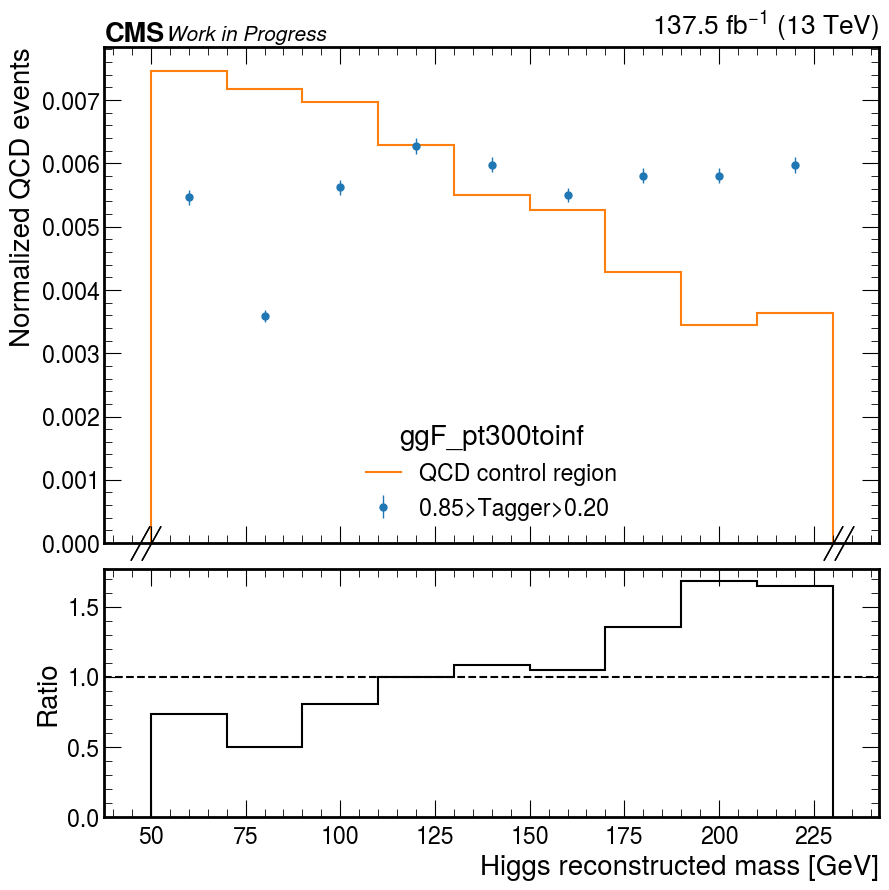

In [754]:
region_dic = {
    "Medium purity signal region": "medium",
    "High purity signal region": "high",
    "0.85>Tagger>0.20": "low",    
}

for category in ["VBF_pt200toinf", "ggF_pt200to300", "ggF_pt300toinf"]:
    
    for region in region_dic:
        plot_ratio(hists["rec_higgs_m"], 
                   years, 
                   region1 = region,
                   region2 = "QCD control region",
                   sample=sample,
                   category=category,
                   tag=f"{category}_{region_dic[region]}"
                  )

In [ ]:
fig, ax = plt.subplots(figsize=(14, 11))
ax.hist(
    x, 
    bins=np.linspace(50,300,bins), 
    weights=w,
    density=True, 
    histtype="step", 
    linewidth=2, 
    label=rf"{k} ($\mu$={np.mean(x):.1f}, $\sigma$={np.std(x):.1f})"
)

ax.axvline(125, color="grey", linestyle="--", label=rf"125 GeV")

if len(channels) > 1:
    ax.legend(title=f"{sample}")    
else:
    ax.legend(title=f"{nice_ch[ch]} channel - {sample}")


ax.set_ylabel("Events")
ax.set_xlabel(f"Reconstructed Higgs mass [GeV]")
ax.set_ylim(0)

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku/mass_sculpting_{sample}.pdf")        

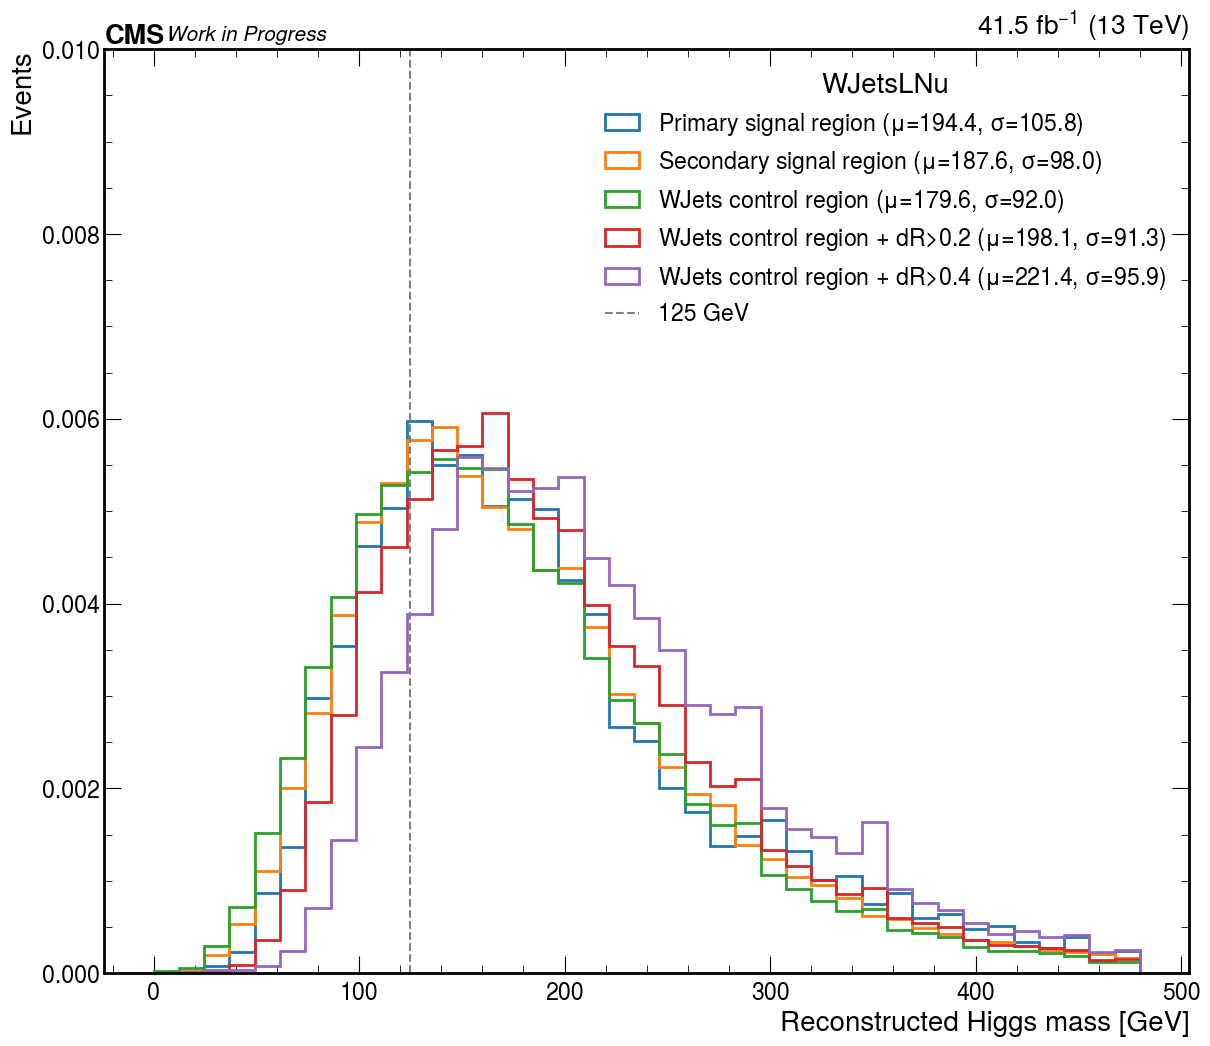

In [140]:
fig, ax = plt.subplots(figsize=(14, 12))
for region, sel in presel.items():

    df1 = df.copy().query(sel)

    x = df1["rec_higgs_m"]
    ax.hist(
        x, 
        bins=np.linspace(0,480,bins), 
        weights=df1["weight"],
        density=True, 
        histtype="step", 
        linewidth=2, 
        label=rf"{region} ($\mu$={np.mean(x):.1f}, $\sigma$={np.std(x):.1f})"
    )

ax.axvline(125, color="grey", linestyle="--", label=rf"125 GeV")

if len(channels) > 1:
    ax.legend(title=f"{sample}")    
else:
    ax.legend(title=f"{nice_ch[ch]} channel - {sample}")


ax.set_ylabel("Events")
ax.set_xlabel(f"Reconstructed Higgs mass [GeV]")
ax.set_ylim(0, 0.01)

luminosity = 0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    luminosity += lum / len(channels)    
        
hep.cms.lumitext("%.1f " % luminosity + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakiko/{sample}.pdf")  